In [147]:
#Bibliotecas e Variaveis Uteis
#!pip install requirements.txt -r
import geopandas as gpd
from calendar import monthrange
from collections import defaultdict
import shutil
import matplotlib.pyplot as plt
from glob import glob
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy import stats
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import gc
import pandas as pd
import numpy as np
import xarray as xr
import pyarrow.parquet as pa_parquet
import cdsapi, backoff, zipfile, shutil, time
import os, json
import time
from glob import glob
from tqdm import tqdm
import netCDF4
import h5netcdf
import requests
import fastparquet
import dask.dataframe as dd
import unicodedata
from pathlib import Path
import polars as pl
import hvplot.pandas
from polars import selectors as cs
from shapely.geometry import Point
import seaborn as sns

pasta_dados = r'C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados'

# 2. Lista de todas as pastas que precisam existir
# Extraímos apenas o diretório de cada caminho de arquivo definido
pastas_necessarias = [
    pasta_dados,
    os.path.join(pasta_dados, 'ERA5_Bruto'),
    os.path.join(pasta_dados, 'EDA'),
    os.path.join(pasta_dados, 'Potencia_ONS'),
    os.path.join(pasta_dados, 'Dados_Intermediário'),
    os.path.join(pasta_dados, 'Model_Data'),
    os.path.join(pasta_dados, 'experimentos')
]

# 3. Loop para criar as pastas automaticamente
print("Verificando e criando diretórios...")
for pasta in pastas_necessarias:
    os.makedirs(pasta, exist_ok=True)
    print(f"OK: {pasta}")

#Caminhos ruins
caminho_series_temporais = os.path.join(pasta_dados, 'Series_Temporais', 'series_temporais_bruto.parquet')
caminho_dados_estaticos = os.path.join(pasta_dados, 'Dataset_Locais.csv')
caminho_dataset_final = os.path.join(pasta_dados, 'Dataset_Final_Para_Modelagem.parquet')
caminho_dataset_intermediario = os.path.join(pasta_dados, 'Dataset_Intermediario.parquet')
output_path = os.path.join(pasta_dados, 'Series_Temporais')

#Limpo
pasta_era5 = os.path.join(pasta_dados, 'ERA5_Bruto')
serie_temporal = os.path.join(pasta_dados, 'Series_Temporais')
tratado_era5 = os.path.join(serie_temporal,  'series_temporais_bruto.parquet')
dataset_locais = os.path.join(pasta_dados, 'Dataset_Locais.csv')
#dataset_locais = os.path.join(pasta_dados, 'dataset_locais_semNaN.csv')
pot_ons = os.path.join(pasta_dados, 'Potencia_ONS')
data_intermed = os.path.join(pasta_dados, 'Dados_Intermediário')

pq = pasta_dados + "//Series_Temporais//series_temporais_*.parquet"
PARQUETS = glob(pq)

#Limpeza e Trat dos dados
EDA_DIR = os.path.join(pasta_dados, 'EDA') #"/content/drive/MyDrive/PUC/IC/ColetaEra5/Dados/EDA"
os.makedirs(EDA_DIR, exist_ok=True)

#Modelos
model_dir = os.path.join(pasta_dados, 'Model_Data')
EXPERIMENTOS_DIR = os.path.join(pasta_dados, 'experimentos')





#Variaveis Uteis

# Configuração de download
anos = range(2010, 2026); meses = [str(m).zfill(2) for m in range(1, 13)]
k = 10  # Numero de clusters espaciais para agregar celulas ERA5 (reduz de 225 para k)
#anos = [2024]; meses = ['06']



subsistema_nordeste_ufs = [
    'MA',  # Maranhão
    'PI',  # Piauí
    'CE',  # Ceará
    'RN',  # Rio Grande do Norte
    'PB',  # Paraíba
    'PE',  # Pernambuco
    'AL',  # Alagoas
    'SE',  # Sergipe
    'BA'   # Bahia
]

status_operacional = [
    'Operação', 'Construção não iniciada', 'Construção', 'DRO'
    ]
#DRO -> Despacho de Requerimento de Outorga -> Entrara no longo prazo (talvez mais de 5 anos)
#Construção não iniciada -> Entrara no médio prazo (menos de 5 anos)
#Construção -> Entrara no curto prazo (de 1-3 anos)



Verificando e criando diretórios...
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\ERA5_Bruto
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\EDA
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\Potencia_ONS
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\Dados_Intermediário
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\Model_Data
OK: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\experimentos


## Coleta de Dados

In [148]:
##Coleta ONS
#Fato de Capacidade fora da analise.


BASE_S3 = "https://ons-aws-prod-opendata.s3.amazonaws.com/dataset"
OUT_DIR = pot_ons
os.makedirs(os.path.dirname(OUT_DIR), exist_ok=True)

def downloadFile(anos, alvo, url_spec):

    for y in anos:
        name = f"{alvo}_{y}.csv"
        url = f"{BASE_S3}/{url_spec}/{alvo}_{y}.csv"
        out_path = os.path.join(OUT_DIR, name)
        
        
        if os.path.exists(out_path):
            print(f"Arquivo {name} existe")
            continue
        
        
        with requests.get(url, stream=True, timeout=120) as r:
            if r.status_code == 404:
                return "not_found"
            r.raise_for_status()

            tmp = out_path + ".part"
            with open(tmp, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
            os.replace(tmp, out_path)
        



lst_alvos = [["BALANCO_ENERGIA_SUBSISTEMA", 'balanco_energia_subsistema_ho' ],[ "CARGA_ENERGIA", 'carga_energia_di'], ["CURVA_CARGA", 'curva-carga-ho']]




max_workers = 6
results = {"ok": 0, "skip": 0, "not_found": 0, "fail": 0}

with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futures = {}
    for alvo in lst_alvos:
        downloadFile(anos, alvo[0], alvo[1])

print("\nResumo download:", results)
print("Pasta cache ONS:", os.path.abspath(OUT_DIR))


Arquivo BALANCO_ENERGIA_SUBSISTEMA_2010.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2011.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2012.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2013.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2014.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2015.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2016.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2017.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2018.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2019.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2020.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2021.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2022.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2023.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2024.csv existe
Arquivo BALANCO_ENERGIA_SUBSISTEMA_2025.csv existe
Arquivo CARGA_ENERGIA_2010.csv existe
Arquivo CARGA_ENERGIA_2011.csv existe
Arquivo CARGA_ENERGIA_2012.csv existe
Arquivo CARGA_ENERGIA_2013.csv existe
Arquivo CARGA_ENERGIA_2014.csv e

In [149]:
## Coleta ERA5 - Médias Mensais por Célula do Grid

import pandas as pd
import numpy as np
import cdsapi
import os
from glob import glob
from tqdm import tqdm
import time
import backoff

print("="*100)
print("COLETA ERA5 - DADOS METEOROLOGICOS MENSAIS")
print("="*100)

# ==============================================================================
# CONSTANTES E VARIÁVEIS
# ==============================================================================
RES = 0.25  # Resolução do grid ERA5 (0.25°)

# Variáveis a coletar (mesmas do código original)
vars = [
    "100m_u_component_of_wind",
    "100m_v_component_of_wind",
    "2m_temperature",
    "sea_surface_temperature",
    "surface_pressure",
    "total_precipitation",
    "friction_velocity"
]

# CORREÇÃO: Adicionar definição de meses que estava faltando
meses = [str(m).zfill(2) for m in range(1, 13)]  # ['01', '02', ..., '12']

lst_errors = []

# ==============================================================================
# FUNÇÕES UTILITÁRIAS (COPIADAS DO ORIGINAL)
# ==============================================================================

def snap_to_era5_grid(lat, lon, res=RES):
    """Arredonda lat/lon para o grid ERA5 mais próximo"""
    lat_era5 = round(lat / res) * res
    lon_era5 = round(lon / res) * res
    return lat_era5, lon_era5

def criar_cell_key(lat_era5, lon_era5):
    """Cria identificador único para célula do grid"""
    lat_str = f"latm{abs(lat_era5):.2f}".replace(".", "p")
    lon_str = f"lonm{abs(lon_era5):.2f}".replace(".", "p")
    return f"{lat_str}_{lon_str}"

def bbox_single_cell(lat_era5: float, lon_era5: float, res: float = RES):
    """Cria bounding box de uma célula do grid"""
    half_res = res / 2.0
    norte = lat_era5 + half_res
    sul = lat_era5 - half_res
    oeste = lon_era5 - half_res
    leste = lon_era5 + half_res
    return [norte, oeste, sul, leste]

def parse_cell_key(cell_key: str):
    """Extrai lat/lon de um cell_key"""
    # Ex: "latm10p00_lonm38p75" -> (-10.00, -38.75)
    parts = cell_key.split("_")
    lat_str = parts[0].replace("latm", "-").replace("p", ".")
    lon_str = parts[1].replace("lonm", "-").replace("p", ".")
    return float(lat_str), float(lon_str)

# ==============================================================================
# FUNÇÃO DE DOWNLOAD (COPIADA DO ORIGINAL)
# ==============================================================================

# Cliente CDS API
c = cdsapi.Client()

def retrieve_year_monthly_means(ano: int, bbox: list, output_file: str):
    """Baixa médias mensais do ERA5 para um ano e uma bbox"""
    c.retrieve(
        "reanalysis-era5-single-levels-monthly-means",
        {
            "product_type": "monthly_averaged_reanalysis",
            "variable": vars,
            "year": str(ano),
            "month": meses,  # ['01', '02', ..., '12']
            "time": "00:00",
            "area": bbox,
            "format": "netcdf",
            "grid": "0.25/0.25",
        },
        output_file
    )

# Função para tratar erros e fazer retry
def sleep_por_erro(e: Exception):
    """Define tempo de espera baseado no erro"""
    msg = str(e).lower()

    if "429" in msg or "too many requests" in msg:
        return 300  # 5 minutos
    elif "503" in msg or "service unavailable" in msg:
        return 180  # 3 minutos
    elif "connection" in msg or "timeout" in msg:
        return 60   # 1 minuto
    else:
        return 30   # 30 segundos

@backoff.on_exception(
    backoff.expo,
    Exception,
    max_tries=5,
    giveup=lambda e: "404" in str(e).lower()
)
def download_com_retry(ano, bbox, output_file):
    """Download com retry automático"""
    try:
        retrieve_year_monthly_means(ano, bbox, output_file)
        return True
    except Exception as e:
        sleep_time = sleep_por_erro(e)
        print(f"   ERRO: {e}")
        print(f"   Aguardando {sleep_time}s antes de retry...")
        time.sleep(sleep_time)
        raise

# ==============================================================================
# 1. CARREGAR E PREPARAR DADOS DOS PARQUES
# ==============================================================================
print("\n1. Carregando dados dos parques...")

df_locais = pd.read_csv(dataset_locais)
print(f"   Total de registros: {len(df_locais)}")

# Normalizar CEG (remover pontos, último ponto vira hífen)
def normalizar_ceg(ceg):
    """Normaliza CEG para buscar em CAPACIDADE_GERACAO"""
    if pd.isna(ceg):
        return None
    s = str(ceg).strip().upper()
    if s in {"", "-"}:
        return None
    
    last_dot_idx = s.rfind('.')
    if last_dot_idx != -1:
        s = s[:last_dot_idx] + '-' + s[last_dot_idx+1:]
    
    s = s.replace(".", "")
    s = s.replace(" ", "")
    return s

df_locais['CEG_norm'] = df_locais['CEG'].apply(normalizar_ceg)

# Filtrar apenas NE
df_locais_ne = df_locais[df_locais['uf'].isin(subsistema_nordeste_ufs)].copy()
print(f"   Registros no NE: {len(df_locais_ne)}")

# Agrupar por parque (CEG único, coordenadas do parque)
df_parques = df_locais_ne.groupby(
    ['CEG_norm', 'nome_parque', 'longitude_parque', 'latitude_parque', 'uf'],
    as_index=False
).agg({
    'qtd_aerogeradores': 'first',
    'potencia_turbina_mw': 'sum',  # Soma das turbinas do parque
})

print(f"   Parques únicos no NE: {len(df_parques)}")

# ==============================================================================
# 2. BUSCAR CAPACIDADE EM CAPACIDADE_GERACAO.CSV
# ==============================================================================
print("\n2. Buscando capacidade instalada em CAPACIDADE_GERACAO.csv...")

arquivo_cap = os.path.join(pot_ons, "CAPACIDADE_GERACAO.csv")
df_cap = pd.read_csv(arquivo_cap, sep=';')
print(f"   Total de registros: {len(df_cap)}")

# Filtrar apenas eólicas no NE
df_cap_eol_ne = df_cap[
    (df_cap['nom_tipousina'].str.upper().str.contains('EOLI', na=False)) &
    (df_cap['nom_subsistema'].str.upper().str.contains('NORDESTE', na=False))
].copy()

print(f"   Registros eólicos no NE: {len(df_cap_eol_ne)}")

# Normalizar CEG
df_cap_eol_ne['ceg_norm'] = df_cap_eol_ne['ceg'].apply(normalizar_ceg)

# Converter potência
df_cap_eol_ne['val_potenciaefetiva'] = pd.to_numeric(
    df_cap_eol_ne['val_potenciaefetiva'], errors='coerce'
)

# Agregar capacidade por CEG
capacidade_por_ceg = df_cap_eol_ne.groupby('ceg_norm')['val_potenciaefetiva'].sum()

print(f"   CEGs únicos com capacidade: {len(capacidade_por_ceg)}")

# Merge com df_parques
df_parques['capacidade_mw'] = df_parques['CEG_norm'].map(capacidade_por_ceg)

# CORREÇÃO: Usar fillna sem inplace para evitar FutureWarning
df_parques['capacidade_mw'] = df_parques['capacidade_mw'].fillna(df_parques['potencia_turbina_mw'])

print(f"   Capacidade total NE: {df_parques['capacidade_mw'].sum():.2f} MW")
print(f"   Parques sem capacidade: {df_parques['capacidade_mw'].isna().sum()}")

# Remover parques sem capacidade
df_parques = df_parques[df_parques['capacidade_mw'].notna()].copy()

print(f"   Parques finais: {len(df_parques)}")

# ==============================================================================
# 3. CRIAR CELL_KEYS (CÉLULAS DO GRID ERA5)
# ==============================================================================
print("\n3. Criando cell_keys (células do grid ERA5)...")

# Snap para grid ERA5
df_parques[['lat_era5', 'lon_era5']] = df_parques.apply(
    lambda r: pd.Series(snap_to_era5_grid(r['latitude_parque'], r['longitude_parque'])),
    axis=1
)

# Criar cell_key
df_parques['cell_key'] = df_parques.apply(
    lambda r: criar_cell_key(r['lat_era5'], r['lon_era5']),
    axis=1
)

print(f"   Cell_keys únicos: {df_parques['cell_key'].nunique()}")

# DataFrame de células únicas
df_cells = df_parques[['cell_key', 'lat_era5', 'lon_era5']].drop_duplicates().reset_index(drop=True)

print(f"   Células a baixar: {len(df_cells)}")
print(f"\n   Primeiras 5 células:")
print(df_cells.head().to_string())

# Salvar mapeamento parque -> cell_key para uso posterior
mapeamento_file = os.path.join(pasta_dados, 'mapeamento_parques_cells.csv')
df_parques.to_csv(mapeamento_file, index=False)
print(f"\n   Mapeamento salvo: {mapeamento_file}")

# ==============================================================================
# 4. DOWNLOAD DOS DADOS ERA5
# ==============================================================================
print("\n4. Baixando dados ERA5...")

# Para cada célula, baixar dados de todos os anos
total_downloads = len(df_cells) * len(list(anos))
downloads_ok = 0
downloads_skip = 0
downloads_erro = 0

for _, cell_row in tqdm(df_cells.iterrows(), total=len(df_cells), desc="Células"):
    cell_key = cell_row['cell_key']
    lat_era5 = cell_row['lat_era5']
    lon_era5 = cell_row['lon_era5']

    bbox = bbox_single_cell(lat_era5, lon_era5)

    for ano in anos:
        # Criar diretório para o ano
        ano_dir = os.path.join(pasta_era5, f"ano={ano}")
        os.makedirs(ano_dir, exist_ok=True)

        # Nome do arquivo
        output_file = os.path.join(ano_dir, f"Era5M_NE-{cell_key}_{ano}.nc")

        # Verificar se já existe
        if os.path.exists(output_file):
            downloads_skip += 1
            continue

        # Download
        try:
            download_com_retry(ano, bbox, output_file)
            downloads_ok += 1
            print(f"   OK: {cell_key} - {ano}")
            time.sleep(1)  # Pausa para não sobrecarregar API

        except Exception as e:
            downloads_erro += 1
            lst_errors.append({
                'cell_key': cell_key,
                'ano': ano,
                'erro': str(e)
            })
            print(f"   ERRO: {cell_key} - {ano}: {e}")

# ==============================================================================
# 5. RESUMO
# ==============================================================================
print("\n" + "="*100)
print("RESUMO DO DOWNLOAD")
print("="*100)
print(f"\nTotal esperado: {total_downloads}")
print(f"  - Downloads OK: {downloads_ok}")
print(f"  - Já existiam: {downloads_skip}")
print(f"  - Erros: {downloads_erro}")

if lst_errors:
    print(f"\n⚠️  {len(lst_errors)} downloads falharam:")
    df_errors = pd.DataFrame(lst_errors)
    print(df_errors.to_string())

    # Salvar erros
    error_file = os.path.join(pasta_dados, 'erros_download_era5.csv')
    df_errors.to_csv(error_file, index=False)
    print(f"\n   Erros salvos em: {error_file}")

print(f"\nArquivos salvos em: {pasta_era5}/ano=YYYY/")
print(f"Próximo passo: Executar célula de Tratamento ERA5")
print("="*100)




COLETA ERA5 - DADOS METEOROLOGICOS MENSAIS

1. Carregando dados dos parques...
   Total de registros: 17758
   Registros no NE: 17758
   Parques únicos no NE: 2422

2. Buscando capacidade instalada em CAPACIDADE_GERACAO.csv...
   Total de registros: 5464
   Registros eólicos no NE: 1938
   CEGs únicos com capacidade: 946
   Capacidade total NE: 62060.86 MW
   Parques sem capacidade: 0
   Parques finais: 2422

3. Criando cell_keys (células do grid ERA5)...
   Cell_keys únicos: 225
   Células a baixar: 225

   Primeiras 5 células:
              cell_key  lat_era5  lon_era5
0   latm9p00_lonm37p75     -9.00    -37.75
1   latm9p25_lonm39p00     -9.25    -39.00
2   latm9p00_lonm39p00     -9.00    -39.00
3   latm9p00_lonm41p50     -9.00    -41.50
4  latm12p25_lonm42p25    -12.25    -42.25

   Mapeamento salvo: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\mapeamento_parques_cells.csv

4. Baixando dados ERA5...


Células: 100%|██████████| 225/225 [00:02<00:00, 86.66it/s] 


RESUMO DO DOWNLOAD

Total esperado: 3600
  - Downloads OK: 0
  - Já existiam: 3600
  - Erros: 0

Arquivos salvos em: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\ERA5_Bruto/ano=YYYY/
Próximo passo: Executar célula de Tratamento ERA5


## Tratamento de Dados e Geração de Estatisticas

In [150]:
## Processamento ONS

print("="*100)
print("UNIFICACAO DOS DADOS ONS - DADOS MENSAIS AGREGADOS PARA O NE")
print("="*100)

# Diretorio base
data_dir = pot_ons

# Anos disponiveis
anos_range = list(range(2015, 2026))  # 2015 a 2025

# ==============================================================================
# 1. PROCESSAR BALANCO_ENERGIA_SUBSISTEMA - Geracao eolica mensal NE
# ==============================================================================
print("\n1. Processando BALANCO_ENERGIA_SUBSISTEMA...")
balanco_frames = []

for ano in anos_range:
    arquivo = os.path.join(data_dir, f"BALANCO_ENERGIA_SUBSISTEMA_{ano}.csv")
    if not os.path.exists(arquivo):
        print(f"   [AVISO] Arquivo nao encontrado: {arquivo}")
        continue

    print(f"   Lendo: {ano}...")
    df = pd.read_csv(arquivo, sep=';')

    # Filtrar apenas NORDESTE
    df_ne = df[df['nom_subsistema'].str.upper().str.contains('NORDESTE', na=False)].copy()

    # Converter data
    df_ne['din_instante'] = pd.to_datetime(df_ne['din_instante'], errors='coerce')
    df_ne['ano'] = df_ne['din_instante'].dt.year
    df_ne['mes'] = df_ne['din_instante'].dt.month

    # Converter valores
    df_ne['val_gereolica'] = pd.to_numeric(df_ne['val_gereolica'], errors='coerce')
    df_ne['val_carga'] = pd.to_numeric(df_ne['val_carga'], errors='coerce')

    # Agregar por mes
    df_mensal = df_ne.groupby(['ano', 'mes'], as_index=False).agg({
        'val_gereolica': 'mean',  # Media mensal em MWmed
        'val_carga': 'mean'       # Carga media mensal do NE em MWmed
    })

    df_mensal.rename(columns={
        'val_gereolica': 'geracao_eolica_ne_mwmed',
        'val_carga': 'carga_ne_mwmed'
    }, inplace=True)

    balanco_frames.append(df_mensal)
    print(f"      -> {len(df_mensal)} meses processados")

df_balanco = pd.concat(balanco_frames, ignore_index=True)
print(f"\n   Total: {len(df_balanco)} registros mensais (geracao eolica + carga NE)")

# ==============================================================================
# 2. PROCESSAR CAPACIDADE_GERACAO - Capacidade instalada eolica NE (COM DESATIVAÇÃO)
# ==============================================================================
print("\n2. Processando CAPACIDADE_GERACAO (considerando entrada E desativação)...")
arquivo_cap = os.path.join(data_dir, "CAPACIDADE_GERACAO.csv")

df_cap = pd.read_csv(arquivo_cap, sep=';')
print(f"   Total de registros: {len(df_cap)}")

# Filtrar apenas EOLICA no NORDESTE
df_cap_eol_ne = df_cap[
    (df_cap['nom_tipousina'].str.upper().str.contains('EOLI', na=False)) &
    (df_cap['nom_subsistema'].str.upper().str.contains('NORDESTE', na=False))
].copy()

print(f"   Registros eolicos no NE: {len(df_cap_eol_ne)}")

# Converter datas de ENTRADA e DESATIVAÇÃO
df_cap_eol_ne['dat_entradaoperacao'] = pd.to_datetime(df_cap_eol_ne['dat_entradaoperacao'], errors='coerce')
df_cap_eol_ne['dat_desativacao'] = pd.to_datetime(df_cap_eol_ne['dat_desativacao'], errors='coerce')

# Converter potencia
df_cap_eol_ne['val_potenciaefetiva'] = pd.to_numeric(df_cap_eol_ne['val_potenciaefetiva'], errors='coerce')

# Remover registros sem data de entrada ou potencia
df_cap_eol_ne = df_cap_eol_ne.dropna(subset=['dat_entradaoperacao', 'val_potenciaefetiva'])

print(f"   Registros com data de entrada: {len(df_cap_eol_ne)}")
print(f"   Registros com data de desativação: {df_cap_eol_ne['dat_desativacao'].notna().sum()}")

# Criar um DataFrame com todos os meses de 2015 a 2025
todos_meses = []
for ano in range(2015, 2026):
    for mes in range(1, 13):
        todos_meses.append({'ano': ano, 'mes': mes})
df_meses = pd.DataFrame(todos_meses)

# Para cada mes, calcular capacidade de usinas ATIVAS
capacidades = []
for _, row in df_meses.iterrows():
    ano_ref = row['ano']
    mes_ref = row['mes']
    
    # Data de referência do mês
    data_ref = pd.Timestamp(year=ano_ref, month=mes_ref, day=1)
    
    # Filtro: usina ATIVA neste mês
    # Ativa = data_ref >= dat_entradaoperacao AND (dat_desativacao is NULL OR data_ref < dat_desativacao)
    mask = (
        (df_cap_eol_ne['dat_entradaoperacao'] <= data_ref) &
        (
            df_cap_eol_ne['dat_desativacao'].isna() |
            (df_cap_eol_ne['dat_desativacao'] > data_ref)
        )
    )
    
    cap_ativa = df_cap_eol_ne[mask]['val_potenciaefetiva'].sum()
    capacidades.append(cap_ativa)

df_meses['capacidade_eolica_ne_mw'] = capacidades

print(f"   Capacidade calculada para {len(df_meses)} meses")
print(f"   Capacidade em 2015-01: {df_meses[(df_meses['ano']==2015) & (df_meses['mes']==1)]['capacidade_eolica_ne_mw'].values[0]:.2f} MW")
print(f"   Capacidade em 2025-12: {df_meses[(df_meses['ano']==2025) & (df_meses['mes']==12)]['capacidade_eolica_ne_mw'].values[0]:.2f} MW")

# ==============================================================================
# 3. PROCESSAR CARGA_ENERGIA - Demanda mensal SIN completo
# ==============================================================================
print("\n3. Processando CARGA_ENERGIA (SIN completo)...")
carga_frames = []

for ano in anos_range:
    arquivo = os.path.join(data_dir, f"CARGA_ENERGIA_{ano}.csv")
    if not os.path.exists(arquivo):
        print(f"   [AVISO] Arquivo nao encontrado: {arquivo}")
        continue

    print(f"   Lendo: {ano}...")
    df = pd.read_csv(arquivo, sep=';')

    # Converter data
    df['din_instante'] = pd.to_datetime(df['din_instante'], errors='coerce')
    df['ano'] = df['din_instante'].dt.year
    df['mes'] = df['din_instante'].dt.month

    # Converter valor
    df['val_cargaenergiamwmed'] = pd.to_numeric(df['val_cargaenergiamwmed'], errors='coerce')

    # Agregar por dia (soma de todos subsistemas)
    df_dia = df.groupby(['ano', 'mes', 'din_instante'], as_index=False).agg({
        'val_cargaenergiamwmed': 'sum'
    })

    # Agregar por mes (media mensal)
    df_mensal = df_dia.groupby(['ano', 'mes'], as_index=False).agg({
        'val_cargaenergiamwmed': 'mean'
    })

    df_mensal.rename(columns={'val_cargaenergiamwmed': 'demanda_sin_mwmed'}, inplace=True)
    carga_frames.append(df_mensal)
    print(f"      -> {len(df_mensal)} meses processados")

df_carga = pd.concat(carga_frames, ignore_index=True)
print(f"\n   Total: {len(df_carga)} registros mensais (demanda SIN)")

# ==============================================================================
# 4. PROCESSAR CURVA_CARGA - Demanda maxima mensal SIN
# ==============================================================================
print("\n4. Processando CURVA_CARGA...")
curva_frames = []

for ano in anos_range:
    arquivo = os.path.join(data_dir, f"CURVA_CARGA_{ano}.csv")
    if not os.path.exists(arquivo):
        print(f"   [AVISO] Arquivo nao encontrado: {arquivo}")
        continue

    print(f"   Lendo: {ano}...")
    df = pd.read_csv(arquivo, sep=';')

    # Converter data
    df['din_instante'] = pd.to_datetime(df['din_instante'], errors='coerce')
    df['ano'] = df['din_instante'].dt.year
    df['mes'] = df['din_instante'].dt.month

    # Converter valor
    df['val_cargaenergiahomwmed'] = pd.to_numeric(df['val_cargaenergiahomwmed'], errors='coerce')

    # Para cada hora, somar todos os subsistemas (SIN total)
    df_hora = df.groupby(['ano', 'mes', 'din_instante'], as_index=False).agg({
        'val_cargaenergiahomwmed': 'sum'
    })

    # Para cada mes, pegar o maximo (pico de demanda)
    df_mensal = df_hora.groupby(['ano', 'mes'], as_index=False).agg({
        'val_cargaenergiahomwmed': 'max'
    })

    df_mensal.rename(columns={'val_cargaenergiahomwmed': 'demanda_max_sin_mw'}, inplace=True)
    curva_frames.append(df_mensal)
    print(f"      -> {len(df_mensal)} meses processados")

df_curva = pd.concat(curva_frames, ignore_index=True)
print(f"\n   Total: {len(df_curva)} registros mensais (demanda maxima SIN)")

# ==============================================================================
# 5. UNIFICAR TUDO
# ==============================================================================
print("\n5. Unificando dados...")

# Comecar com balanco (geracao eolica + carga NE)
df_final = df_balanco.copy()

# Merge com capacidade
df_final = df_final.merge(df_meses[['ano', 'mes', 'capacidade_eolica_ne_mw']],
                           on=['ano', 'mes'], how='left')

# Merge com carga SIN
df_final = df_final.merge(df_carga, on=['ano', 'mes'], how='left')

# Merge com curva (demanda maxima)
df_final = df_final.merge(df_curva, on=['ano', 'mes'], how='left')

# Adicionar coluna de subsistema
df_final['subsistema'] = 'NE'

# ==============================================================================
# 6. FEATURES DERIVADAS
# ==============================================================================
print("\n6. Calculando features derivadas...")

# Corte eolico (curtailment) - quando capacidade > geracao
# Em teoria, a capacidade maxima de geracao (assumindo 100% de CF) seria capacidade_mw
# Na pratica, com vento bom, um CF de ~50% e alto. Vamos usar uma estimativa conservadora:
# Potencial maximo mensal (horas no mes * capacidade * fator de disponibilidade ~95%)

# Horas no mes
df_final['dias_no_mes'] = df_final.apply(
    lambda row: pd.Timestamp(year=int(row['ano']), month=int(row['mes']), day=1).days_in_month,
    axis=1
)
df_final['horas_no_mes'] = df_final['dias_no_mes'] * 24

# Potencial maximo teorico (MWh) = capacidade_mw * horas * 0.95 (disponibilidade)
df_final['potencial_max_mwh'] = df_final['capacidade_eolica_ne_mw'] * df_final['horas_no_mes'] * 0.95

# Geracao efetiva (MWh) = geracao_mwmed * horas
df_final['geracao_efetiva_mwh'] = df_final['geracao_eolica_ne_mwmed'] * df_final['horas_no_mes']

# Corte eolico = potencial - efetivo (quando positivo)
# Na verdade, o corte e mais complexo, mas uma proxy e:
# Se capacity_factor muito baixo quando vento e bom = corte
# Vamos usar uma abordagem simples: assumir que CF > 40% e raro sem corte
# Corte estimado (MWmed) = max(0, capacidade * 0.40 - geracao)
# Mas isso e simplificacao. Melhor e deixar o modelo aprender.

# Por enquanto, vamos calcular o "corte potencial" como:
# Se geracao < capacidade * 0.30 (muito baixo, provavelmente sem vento, nao e corte)
# Se geracao entre 30-50% da capacidade, pode ser vento normal
# Se geracao > 50%, improvavel ter corte significativo
# O corte real viria de dados de restrições operativas do ONS que nao temos

# Vamos fazer uma estimativa conservadora:
# corte_estimado_mwmed = max(0, (capacidade * 0.45) - geracao)
# Onde 0.45 e um CF "alvo" razoavel para NE

df_final['corte_eolica_ne_mwmed'] = np.maximum(
    0,
    (df_final['capacidade_eolica_ne_mw'] * 0.45) - df_final['geracao_eolica_ne_mwmed']
)

# Capacity Factor (%)
df_final['capacity_factor_ne'] = (
    df_final['geracao_eolica_ne_mwmed'] / df_final['capacidade_eolica_ne_mw'].replace(0, np.nan)
) * 100

# Penetracao eolica no NE (%)
df_final['penetracao_eolica_ne'] = (
    df_final['geracao_eolica_ne_mwmed'] / df_final['carga_ne_mwmed'].replace(0, np.nan)
) * 100

# Penetracao eolica no SIN (%)
df_final['penetracao_eolica_sin'] = (
    df_final['geracao_eolica_ne_mwmed'] / df_final['demanda_sin_mwmed'].replace(0, np.nan)
) * 100

# Crescimento de capacidade (MW adicionados no mes)
df_final = df_final.sort_values(['ano', 'mes']).reset_index(drop=True)
df_final['crescimento_capacidade_mw'] = df_final['capacidade_eolica_ne_mw'].diff().fillna(0)

# Indice sazonal (mes do ano)
df_final['mes_sazonal'] = df_final['mes']

# Trimestre
df_final['trimestre'] = ((df_final['mes'] - 1) // 3) + 1

# ==============================================================================
# 7. ORDENAR E SELECIONAR COLUNAS FINAIS
# ==============================================================================
colunas_finais = [
    'ano', 'mes', 'subsistema',
    'geracao_eolica_ne_mwmed',
    'capacidade_eolica_ne_mw',
    'carga_ne_mwmed',
    'demanda_sin_mwmed',
    'demanda_max_sin_mw',
    'corte_eolica_ne_mwmed',
    'capacity_factor_ne',
    'penetracao_eolica_ne',
    'penetracao_eolica_sin',
    'crescimento_capacidade_mw',
    'trimestre'
]

df_final = df_final[colunas_finais]
df_final = df_final.sort_values(['ano', 'mes']).reset_index(drop=True)

print(f"\nDataset final: {df_final.shape}")
print(f"\nPrimeiras 10 linhas:")
print(df_final.head(10).to_string())
print(f"\nUltimas 10 linhas:")
print(df_final.tail(10).to_string())

print(f"\nEstatisticas:")
print(df_final.describe())

print(f"\nValores nulos por coluna:")
print(df_final.isnull().sum())

# ==============================================================================
# 8. SALVAR
# ==============================================================================
output_file = os.path.join(data_intermed, "dados_operacao_ONS.csv")
df_final.to_csv(output_file, index=False)

print(f"\n" + "="*100)
print(f"ARQUIVO SALVO: {output_file}")
print(f"Total de registros: {len(df_final)}")
print(f"Periodo: {df_final['ano'].min()}-{df_final['mes'].min():02d} ate {df_final['ano'].max()}-{df_final['mes'].max():02d}")
print(f"\n✅ CORREÇÃO APLICADA:")
print(f"  - Capacidade agora considera entrada E desativação de usinas")
print(f"  - Apenas usinas ATIVAS em cada mês são contabilizadas")
print(f"\nColunas criadas:")
for col in colunas_finais:
    print(f"  - {col}")
print("="*100)



UNIFICACAO DOS DADOS ONS - DADOS MENSAIS AGREGADOS PARA O NE

1. Processando BALANCO_ENERGIA_SUBSISTEMA...
   Lendo: 2015...
      -> 12 meses processados
   Lendo: 2016...
      -> 12 meses processados
   Lendo: 2017...
      -> 12 meses processados
   Lendo: 2018...
      -> 12 meses processados
   Lendo: 2019...
      -> 12 meses processados
   Lendo: 2020...
      -> 12 meses processados
   Lendo: 2021...
      -> 12 meses processados
   Lendo: 2022...
      -> 12 meses processados
   Lendo: 2023...
      -> 12 meses processados
   Lendo: 2024...
      -> 12 meses processados
   Lendo: 2025...
      -> 12 meses processados

   Total: 132 registros mensais (geracao eolica + carga NE)

2. Processando CAPACIDADE_GERACAO (considerando entrada E desativação)...
   Total de registros: 5464
   Registros eolicos no NE: 1938
   Registros com data de entrada: 1938
   Registros com data de desativação: 0
   Capacidade calculada para 132 meses
   Capacidade em 2015-01: 3397.43 MW
   Capacidade

In [151]:
## Processamento ERA5 - Extracao de Dados por Parque
## Apenas vento a 100m (u100, v100)

import pandas as pd
import numpy as np
import xarray as xr
import os
import zipfile
import tempfile
import shutil
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("PROCESSAMENTO ERA5 - EXTRACAO DE DADOS POR PARQUE")
print("="*100)

# ==============================================================================
# FUNCAO PARA ABRIR ARQUIVOS ERA5 (ZIP OU NETCDF)
# ==============================================================================
def abrir_era5_arquivo(arquivo_path):
    """
    Abre arquivo ERA5 que pode ser ZIP (com 3 NetCDFs) ou NetCDF direto.
    Normaliza timestamps para apenas data (remove hora) antes de combinar.
    """
    with open(arquivo_path, 'rb') as f:
        header = f.read(4)

    if header[:2] == b'PK':  # E um arquivo ZIP
        temp_dir = tempfile.mkdtemp()
        try:
            with zipfile.ZipFile(arquivo_path, 'r') as z:
                z.extractall(temp_dir)

            datasets = []
            for nc_file in glob(os.path.join(temp_dir, '*.nc')):
                ds = xr.open_dataset(nc_file, engine='netcdf4')
                if 'valid_time' in ds.coords:
                    new_times = pd.to_datetime(ds['valid_time'].values).normalize()
                    ds = ds.assign_coords(valid_time=new_times)
                datasets.append(ds)

            ds_combined = xr.merge(datasets, compat='override', join='exact')
            ds_memory = ds_combined.load()

            for ds in datasets:
                ds.close()
            ds_combined.close()

            return ds_memory
        finally:
            shutil.rmtree(temp_dir, ignore_errors=True)
    else:
        return xr.open_dataset(arquivo_path, engine='netcdf4')

# ==============================================================================
# 1. CARREGAR MAPEAMENTO PARQUES -> CELLS E ADICIONAR DATAS DE OPERACAO
# ==============================================================================
print("\n1. Carregando mapeamento parques -> celulas...")

mapeamento_file = os.path.join(pasta_dados, 'mapeamento_parques_cells.csv')

if not os.path.exists(mapeamento_file):
    print(f"   ERRO: Arquivo de mapeamento nao encontrado: {mapeamento_file}")
    raise FileNotFoundError(mapeamento_file)

df_parques = pd.read_csv(mapeamento_file)

print(f"   Total de parques: {len(df_parques)}")
print(f"   Cell_keys unicos: {df_parques['cell_key'].nunique()}")
print(f"   Periodo de processamento: {min(anos)} a {max(anos)}")

# ==============================================================================
# 1.1. ADICIONAR DATAS DE OPERACAO DO CAPACIDADE_GERACAO.CSV
# ==============================================================================
print("\n1.1. Adicionando datas de operacao dos parques...")

def normalizar_ceg(ceg):
    if pd.isna(ceg):
        return None
    s = str(ceg).strip().upper()
    if s in {"", "-"}:
        return None
    last_dot_idx = s.rfind('.')
    if last_dot_idx != -1:
        s = s[:last_dot_idx] + '-' + s[last_dot_idx+1:]
    s = s.replace(".", "")
    s = s.replace(" ", "")
    return s

arquivo_cap = os.path.join(pot_ons, "CAPACIDADE_GERACAO.csv")
df_cap = pd.read_csv(arquivo_cap, sep=';')

df_cap_eol_ne = df_cap[
    (df_cap['nom_tipousina'].str.upper().str.contains('EOLI', na=False)) &
    (df_cap['nom_subsistema'].str.upper().str.contains('NORDESTE', na=False))
].copy()

df_cap_eol_ne['ceg_norm'] = df_cap_eol_ne['ceg'].apply(normalizar_ceg)
df_cap_eol_ne['dat_entradaoperacao'] = pd.to_datetime(df_cap_eol_ne['dat_entradaoperacao'], errors='coerce')
df_cap_eol_ne['dat_desativacao'] = pd.to_datetime(df_cap_eol_ne['dat_desativacao'], errors='coerce')

datas_por_ceg = df_cap_eol_ne.groupby('ceg_norm').agg({
    'dat_entradaoperacao': 'min',
    'dat_desativacao': 'max'
}).reset_index()

print(f"   CEGs com datas de operacao: {len(datas_por_ceg)}")

df_parques = df_parques.merge(datas_por_ceg, left_on='CEG_norm', right_on='ceg_norm', how='left')

print(f"\n   Parques com data de entrada: {df_parques['dat_entradaoperacao'].notna().sum()}")

# ==============================================================================
# 2. VERIFICAR ARQUIVOS NETCDF DISPONIVEIS
# ==============================================================================
print("\n2. Verificando arquivos NetCDF disponiveis...")

arquivos_nc = []
for ano in anos:
    ano_dir = os.path.join(pasta_era5, f"ano={ano}")
    if os.path.exists(ano_dir):
        arquivos = glob(os.path.join(ano_dir, "Era5M_NE-*.nc"))
        arquivos_nc.extend(arquivos)

print(f"   Arquivos NetCDF encontrados: {len(arquivos_nc)}")

if len(arquivos_nc) == 0:
    raise FileNotFoundError("Nenhum arquivo NetCDF encontrado")

arquivos_por_cell = {}
for arquivo in arquivos_nc:
    nome = os.path.basename(arquivo)
    partes = nome.replace('Era5M_NE-', '').replace('.nc', '').split('_')
    cell_key = '_'.join(partes[:-1])
    ano = int(partes[-1])
    if cell_key not in arquivos_por_cell:
        arquivos_por_cell[cell_key] = {}
    arquivos_por_cell[cell_key][ano] = arquivo

print(f"   Celulas unicas com dados: {len(arquivos_por_cell)}")

# ==============================================================================
# 3. PROCESSAR ARQUIVOS E EXTRAIR DADOS POR PARQUE
# ==============================================================================
print("\n3. Extraindo dados meteorologicos por parque (apenas vento 100m)...")

dados_extraidos = []
erros_processamento = []

parques_por_cell = df_parques.groupby('cell_key')

for cell_key, grupo_parques in tqdm(parques_por_cell, desc="Processando celulas"):
    if cell_key not in arquivos_por_cell:
        continue

    arquivos_ano = arquivos_por_cell[cell_key]

    for ano in anos:
        if ano not in arquivos_ano:
            continue

        arquivo_nc = arquivos_ano[ano]

        try:
            ds = abrir_era5_arquivo(arquivo_nc)

            for _, parque in grupo_parques.iterrows():
                lat_era5 = parque['lat_era5']
                lon_era5 = parque['lon_era5']

                ponto = ds.sel(latitude=lat_era5, longitude=lon_era5, method='nearest')
                time_dim = 'valid_time' if 'valid_time' in ponto.coords else 'time'

                for t_idx, tempo in enumerate(ponto[time_dim].values):
                    timestamp = pd.Timestamp(tempo)
                    mes = timestamp.month
                    ano_ref = timestamp.year

                    dados_mes = ponto.isel({time_dim: t_idx})

                    # Apenas componentes de vento a 100m
                    u100 = float(dados_mes['u100'].values) if 'u100' in dados_mes else np.nan
                    v100 = float(dados_mes['v100'].values) if 'v100' in dados_mes else np.nan

                    # Velocidade do vento a 100m
                    vel_vento_100m = np.sqrt(u100**2 + v100**2) if not (np.isnan(u100) or np.isnan(v100)) else np.nan

                    # Outras variaveis
                    t2m = float(dados_mes['t2m'].values) if 't2m' in dados_mes else np.nan
                    sp = float(dados_mes['sp'].values) if 'sp' in dados_mes else np.nan
                    tp = float(dados_mes['tp'].values) if 'tp' in dados_mes else 0.0
                    sst = float(dados_mes['sst'].values) if 'sst' in dados_mes else np.nan
                    zust = float(dados_mes['zust'].values) if 'zust' in dados_mes else np.nan

                    # Densidade do ar (rho = P / (R * T))
                    R = 287.058
                    densidade_ar = sp / (R * t2m) if not (np.isnan(sp) or np.isnan(t2m) or t2m == 0) else np.nan

                    dados_extraidos.append({
                        'ano': ano_ref,
                        'mes': mes,
                        'nome_parque': parque['nome_parque'],
                        'CEG_norm': parque['CEG_norm'],
                        'lat': parque['latitude_parque'],
                        'lon': parque['longitude_parque'],
                        'lat_era5': lat_era5,
                        'lon_era5': lon_era5,
                        'cell_key': cell_key,
                        'peso_capacidade_mw': parque['capacidade_mw'],
                        'dat_entradaoperacao': parque['dat_entradaoperacao'],
                        'dat_desativacao': parque['dat_desativacao'],
                        'uf': parque['uf'],
                        'u100': u100,
                        'v100': v100,
                        'vel_vento_100m': vel_vento_100m,
                        't2m': t2m,
                        'sp': sp,
                        'tp': tp,
                        'sst': sst,
                        'zust': zust,
                        'densidade_ar': densidade_ar,
                    })

            ds.close()

        except Exception as e:
            erros_processamento.append({
                'cell_key': cell_key, 'ano': ano, 'arquivo': arquivo_nc, 'erro': str(e)
            })
            continue

# ==============================================================================
# 4. CRIAR DATAFRAME FINAL
# ==============================================================================
print("\n4. Criando DataFrame final...")

df_era5_parques = pd.DataFrame(dados_extraidos)

if len(df_era5_parques) == 0:
    raise ValueError("Nenhum dado extraido dos arquivos NetCDF")

print(f"   Total de registros extraidos: {len(df_era5_parques)}")
print(f"   Parques unicos: {df_era5_parques['nome_parque'].nunique()}")
print(f"   Periodo: {df_era5_parques['ano'].min()}/{df_era5_parques['mes'].min():02d} a {df_era5_parques['ano'].max()}/{df_era5_parques['mes'].max():02d}")

df_era5_parques = df_era5_parques.sort_values(['ano', 'mes', 'nome_parque']).reset_index(drop=True)

# ==============================================================================
# 5. VERIFICAR QUALIDADE DOS DADOS
# ==============================================================================
print("\n5. Verificando qualidade dos dados...")

print(f"\n   Valores nulos por coluna:")
nulos = df_era5_parques.isnull().sum()
if nulos.sum() > 0:
    print(nulos[nulos > 0])

print(f"\n   Estatisticas das principais variaveis:")
cols_stats = ['vel_vento_100m', 't2m', 'sp', 'densidade_ar', 'peso_capacidade_mw']
print(df_era5_parques[cols_stats].describe())

# ==============================================================================
# 6. SALVAR DADOS PROCESSADOS
# ==============================================================================
print("\n6. Salvando dados processados...")

output_file = os.path.join(data_intermed, "dados_era5_parques_ne.csv") 
df_era5_parques.to_csv(output_file, index=False)

print(f"\n" + "="*100)
print("DADOS ERA5 PROCESSADOS COM SUCESSO!")
print("="*100)
print(f"\nResumo:")
print(f"  - Arquivo salvo: {output_file}")
print(f"  - Total de registros: {len(df_era5_parques)}")
print(f"  - Parques unicos: {df_era5_parques['nome_parque'].nunique()}")
print(f"  - Variaveis de vento: apenas 100m (u100, v100, vel_vento_100m)")
print("="*100)



PROCESSAMENTO ERA5 - EXTRACAO DE DADOS POR PARQUE

1. Carregando mapeamento parques -> celulas...
   Total de parques: 2422
   Cell_keys unicos: 225
   Periodo de processamento: 2010 a 2025

1.1. Adicionando datas de operacao dos parques...
   CEGs com datas de operacao: 946

   Parques com data de entrada: 927

2. Verificando arquivos NetCDF disponiveis...
   Arquivos NetCDF encontrados: 3600
   Celulas unicas com dados: 225

3. Extraindo dados meteorologicos por parque (apenas vento 100m)...


Processando celulas: 100%|██████████| 225/225 [06:52<00:00,  1.83s/it]



4. Criando DataFrame final...
   Total de registros extraidos: 465024
   Parques unicos: 2403
   Periodo: 2010/01 a 2025/12

5. Verificando qualidade dos dados...

   Valores nulos por coluna:
dat_entradaoperacao    287040
dat_desativacao        465024
sst                    407040
dtype: int64

   Estatisticas das principais variaveis:
       vel_vento_100m            t2m             sp   densidade_ar  \
count   465024.000000  465024.000000  465024.000000  465024.000000   
mean         6.127357     298.797676   96327.143671       1.122980   
std          1.844376       1.943061    3024.050323       0.031877   
min          0.713009     290.461090   89433.000000       1.048865   
25%          4.871908     297.658478   93911.906250       1.098065   
50%          6.079625     299.112305   95746.812500       1.115044   
75%          7.453229     300.211365   99183.625000       1.153253   
max         11.903348     304.864441  101538.898438       1.189545   

       peso_capacidade_mw  
c

In [152]:
## Tratamento Dados ERA5 - Agregacao com Media Ponderada por Capacidade
## Apenas vento a 100m

import pandas as pd
import numpy as np
import os

print("="*100)
print("AGREGACAO ERA5 - MEDIA PONDERADA POR CAPACIDADE INSTALADA (DINAMICA)")
print("="*100)

# ==============================================================================
# 1. CARREGAR DADOS ERA5 POR PARQUE
# ==============================================================================
print("\n1. Carregando dados ERA5 por parque...")

arquivo_era5 = os.path.join(data_intermed, "dados_era5_parques_ne.csv")

if not os.path.exists(arquivo_era5):
    print(f"   ERRO: Arquivo nao encontrado: {arquivo_era5}")
    raise FileNotFoundError(arquivo_era5)

df_era5_parques = pd.read_csv(arquivo_era5)

df_era5_parques['dat_entradaoperacao'] = pd.to_datetime(df_era5_parques['dat_entradaoperacao'], errors='coerce')
df_era5_parques['dat_desativacao'] = pd.to_datetime(df_era5_parques['dat_desativacao'], errors='coerce')

print(f"   Total de registros: {len(df_era5_parques)}")
print(f"   Parques unicos: {df_era5_parques['nome_parque'].nunique()}")
print(f"   Periodo: {df_era5_parques['ano'].min()}/{df_era5_parques['mes'].min():02d} a {df_era5_parques['ano'].max()}/{df_era5_parques['mes'].max():02d}")

# ==============================================================================
# 2. FILTRAR PARQUES POR DATA DE OPERACAO (PESO DINAMICO)
# ==============================================================================
print("\n2. Aplicando filtro temporal (parques ativos por mes)...")

df_era5_parques['data_ref'] = pd.to_datetime(
    df_era5_parques['ano'].astype(str) + '-' + df_era5_parques['mes'].astype(str).str.zfill(2) + '-01'
)

registros_antes = len(df_era5_parques)

df_era5_parques['ativo'] = (
    (df_era5_parques['data_ref'] >= df_era5_parques['dat_entradaoperacao']) &
    (
        df_era5_parques['dat_desativacao'].isna() |
        (df_era5_parques['data_ref'] < df_era5_parques['dat_desativacao'])
    )
)

df_era5_ativos = df_era5_parques[df_era5_parques['ativo']].copy()

registros_depois = len(df_era5_ativos)

print(f"   Registros ANTES do filtro: {registros_antes}")
print(f"   Registros DEPOIS do filtro (ativos): {registros_depois}")
print(f"   Registros removidos (inativos): {registros_antes - registros_depois}")

if len(df_era5_ativos) == 0:
    raise ValueError("Nenhum parque ativo no periodo")

# ==============================================================================
# 3. CALCULAR MEDIA PONDERADA POR MES (PESO = CAPACIDADE INSTALADA)
# ==============================================================================
print("\n3. Calculando medias ponderadas por mes (apenas parques ativos)...")

# Variaveis meteorologicas (SEM 10m e wind_shear)
vars_meteo = [
    'vel_vento_100m',
    't2m',
    'sp',
    'tp',
    'sst',
    'zust',
    'densidade_ar'
]

def weighted_average(df, var_col, weight_col='peso_capacidade_mw'):
    valid = df[[var_col, weight_col]].dropna()
    if len(valid) == 0:
        return np.nan
    return (valid[var_col] * valid[weight_col]).sum() / valid[weight_col].sum()

df_agregado = df_era5_ativos.groupby(['ano', 'mes']).apply(
    lambda x: pd.Series({
        **{f'{var}_ne_media': weighted_average(x, var) for var in vars_meteo},
        'capacidade_total_ne_mw': x['peso_capacidade_mw'].sum(),
        'num_parques_ativos': x['nome_parque'].nunique()
    })
).reset_index()

print(f"\n   Total de meses processados: {len(df_agregado)}")

# ==============================================================================
# 4. CALCULAR PERCENTIS DE VENTO (P10, P90) - APENAS 100m
# ==============================================================================
print("\n4. Calculando percentis de vento 100m...")

def weighted_percentile(df, var_col, percentile, weight_col='peso_capacidade_mw'):
    valid = df[[var_col, weight_col]].dropna()
    if len(valid) == 0:
        return np.nan
    sorted_df = valid.sort_values(var_col)
    cumsum = sorted_df[weight_col].cumsum()
    cutoff = sorted_df[weight_col].sum() * (percentile / 100.0)
    idx = (cumsum >= cutoff).idxmax()
    return sorted_df.loc[idx, var_col]

df_percentis = df_era5_ativos.groupby(['ano', 'mes']).apply(
    lambda x: pd.Series({
        'vel_vento_100m_ne_p10': weighted_percentile(x, 'vel_vento_100m', 10),
        'vel_vento_100m_ne_p90': weighted_percentile(x, 'vel_vento_100m', 90),
    })
).reset_index()

df_agregado = df_agregado.merge(df_percentis, on=['ano', 'mes'], how='left')

print(f"   Percentis calculados para {len(df_agregado)} meses")

# ==============================================================================
# 5. ADICIONAR FEATURES DERIVADAS
# ==============================================================================
print("\n5. Calculando features derivadas...")

# Potencia do vento (0.5 * densidade * v^3)
df_agregado['potencia_vento_100m_ne'] = (
    0.5 * df_agregado['densidade_ar_ne_media'] * (df_agregado['vel_vento_100m_ne_media'] ** 3)
)

# Temperatura em Celsius
df_agregado['temp_celsius_ne'] = df_agregado['t2m_ne_media'] - 273.15

# Precipitacao mensal (m para mm)
df_agregado['precipitacao_mensal_mm'] = df_agregado['tp_ne_media'] * 1000

# Variabilidade do vento (P90 - P10)
df_agregado['variabilidade_vento_100m'] = (
    df_agregado['vel_vento_100m_ne_p90'] - df_agregado['vel_vento_100m_ne_p10']
)

print(f"   Features derivadas calculadas")

# ==============================================================================
# 6. ORDENAR E SELECIONAR COLUNAS FINAIS
# ==============================================================================
print("\n6. Preparando dataset final...")

colunas_finais = [
    'ano', 'mes',
    # Medias ponderadas
    'vel_vento_100m_ne_media',
    't2m_ne_media',
    'temp_celsius_ne',
    'sp_ne_media',
    'sst_ne_media',
    'zust_ne_media',
    'densidade_ar_ne_media',
    # Percentis
    'vel_vento_100m_ne_p10',
    'vel_vento_100m_ne_p90',
    # Derivadas
    'potencia_vento_100m_ne',
    'precipitacao_mensal_mm',
    'variabilidade_vento_100m',
    # Metadados
    'capacidade_total_ne_mw',
    'num_parques_ativos'
]

df_agregado = df_agregado[colunas_finais]
df_agregado = df_agregado.sort_values(['ano', 'mes']).reset_index(drop=True)

print(f"\n   Dataset final: {df_agregado.shape}")
print(f"\n   Primeiras 5 linhas:")
print(df_agregado.head().to_string())

print(f"\n   Valores nulos por coluna:")
print(df_agregado.isnull().sum())

# ==============================================================================
# 7. SALVAR
# ==============================================================================
output_file = os.path.join(data_intermed, "dados_era5_ne_agregado.csv")
df_agregado.to_csv(output_file, index=False)

print(f"\n" + "="*100)
print(f"ARQUIVO SALVO: {output_file}")
print(f"Total de registros: {len(df_agregado)}")
print(f"Periodo: {df_agregado['ano'].min()}/{df_agregado['mes'].min():02d} a {df_agregado['ano'].max()}/{df_agregado['mes'].max():02d}")
print(f"\nNOTA: Apenas vento a 100m (sem 10m e wind_shear)")
print("="*100)



AGREGACAO ERA5 - MEDIA PONDERADA POR CAPACIDADE INSTALADA (DINAMICA)

1. Carregando dados ERA5 por parque...
   Total de registros: 465024
   Parques unicos: 2403
   Periodo: 2010/01 a 2025/12

2. Aplicando filtro temporal (parques ativos por mes)...
   Registros ANTES do filtro: 465024
   Registros DEPOIS do filtro (ativos): 68032
   Registros removidos (inativos): 396992

3. Calculando medias ponderadas por mes (apenas parques ativos)...

   Total de meses processados: 192

4. Calculando percentis de vento 100m...
   Percentis calculados para 192 meses

5. Calculando features derivadas...
   Features derivadas calculadas

6. Preparando dataset final...

   Dataset final: (192, 16)

   Primeiras 5 linhas:
    ano  mes  vel_vento_100m_ne_media  t2m_ne_media  temp_celsius_ne    sp_ne_media  sst_ne_media  zust_ne_media  densidade_ar_ne_media  vel_vento_100m_ne_p10  vel_vento_100m_ne_p90  potencia_vento_100m_ne  precipitacao_mensal_mm  variabilidade_vento_100m  capacidade_total_ne_mw  num

In [153]:
#Juncao de datasets - Dados ONS + ERA5 com Clustering Espacial
#Agrupa celulas ERA5 em k clusters usando clustering hierarquico
#SST: exclui NaN da media ponderada e preenche clusters sem SST com vizinho mais proximo

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, cdist
import os

print("="*100)
print("DATASET FINAL - ONS + ERA5 COM CLUSTERING ESPACIAL")
print(f"Numero de clusters (k): {k}")
print("="*100)

# ==============================================================================
# 1. CARREGAR DATASETS
# ==============================================================================
print("\n1. Carregando datasets...")

arquivo_ons = os.path.join(data_intermed, 'dados_operacao_ONS.csv')
df_ons = pd.read_csv(arquivo_ons)
print(f"   Dados ONS: {df_ons.shape}")

arquivo_era5 = os.path.join(data_intermed, 'dados_era5_parques_ne.csv')
df_era5 = pd.read_csv(arquivo_era5)
print(f"   Dados ERA5 por parque: {df_era5.shape}")
print(f"   Celulas unicas: {df_era5['cell_key'].nunique()}")

# ==============================================================================
# 2. EXTRAIR COORDENADAS UNICAS DAS CELULAS
# ==============================================================================
print("\n2. Extraindo coordenadas das celulas...")

df_coords = df_era5.groupby('cell_key').agg({
    'lat_era5': 'first',
    'lon_era5': 'first'
}).reset_index()

print(f"   Celulas para clustering: {len(df_coords)}")

# ==============================================================================
# 3. CLUSTERING HIERARQUICO
# ==============================================================================
print(f"\n3. Aplicando clustering hierarquico (k={k})...")

coords = df_coords[['lat_era5', 'lon_era5']].values.astype(np.float64)
dist_matrix = pdist(coords, metric='euclidean')
Z = linkage(dist_matrix, method='ward')
clusters = fcluster(Z, k, criterion='maxclust')
df_coords['cluster'] = clusters.astype(int)

print(f"   Clusters criados: {df_coords['cluster'].nunique()}")

# ==============================================================================
# 4. CALCULAR CENTROIDES E NOMEAR CLUSTERS
# ==============================================================================
print("\n4. Calculando centroides dos clusters...")

centroides = df_coords.groupby('cluster').agg({
    'lat_era5': 'mean',
    'lon_era5': 'mean'
}).reset_index()

def coord_to_name(lat, lon):
    lat_str = f"lat{abs(lat):.1f}{'S' if lat < 0 else 'N'}"
    lon_str = f"lon{abs(lon):.1f}{'W' if lon < 0 else 'E'}"
    return f"{lat_str}_{lon_str}"

centroides['cluster_name'] = centroides.apply(
    lambda row: coord_to_name(row['lat_era5'], row['lon_era5']), axis=1
)

cluster_name_map = dict(zip(centroides['cluster'], centroides['cluster_name']))
df_coords['cluster_name'] = df_coords['cluster'].map(cluster_name_map)

# ==============================================================================
# ==============================================================================
# 5. ORDENAR CLUSTERS POR PROXIMIDADE GEOGRAFICA (TSP GULOSO)
# ==============================================================================
print("5. Ordenando clusters por proximidade geografica (nearest neighbor)...")

# Para que o CNN capture coerencia espacial, clusters com indices proximos
# devem estar geograficamente proximos. Usamos TSP guloso (nearest neighbor).

from scipy.spatial.distance import cdist

# Coordenadas dos centroides
centroide_names = centroides['cluster_name'].tolist()
centroide_coords_arr = centroides[['lat_era5', 'lon_era5']].values

# Matriz de distancias entre centroides
dist_centroides = cdist(centroide_coords_arr, centroide_coords_arr, metric='euclidean')

# TSP guloso: comecar do centroide mais ao norte-oeste
start_idx = np.argmax(centroide_coords_arr[:, 0] - centroide_coords_arr[:, 1])  # max(lat - lon)

visited = [start_idx]
remaining = set(range(len(centroide_names))) - {start_idx}

while remaining:
    current = visited[-1]
    # Encontrar o vizinho mais proximo nao visitado
    min_dist = float('inf')
    nearest = None
    for candidate in remaining:
        if dist_centroides[current, candidate] < min_dist:
            min_dist = dist_centroides[current, candidate]
            nearest = candidate
    visited.append(nearest)
    remaining.remove(nearest)

# Criar mapeamento de ordem (cluster_name -> posicao na sequencia)
cluster_order = {centroide_names[idx]: pos for pos, idx in enumerate(visited)}

print(f"   Ordem dos clusters (TSP guloso):")
for pos, idx in enumerate(visited[:10]):
    print(f"      {pos}: {centroide_names[idx]}")
if len(visited) > 10:
    print(f"      ... ({len(visited) - 10} clusters restantes)")
# 6. MAPEAR CELL_KEY PARA CLUSTER
# ==============================================================================
print("\n6. Mapeando celulas para clusters...")

cell_to_cluster = dict(zip(df_coords['cell_key'], df_coords['cluster_name']))
df_era5['cluster_name'] = df_era5['cell_key'].map(cell_to_cluster)

# ==============================================================================
# 7. CALCULAR CAPACIDADE TOTAL DO NE POR MES
# ==============================================================================
print("\n7. Calculando capacidade total do NE por mes...")

capacidade_ne_mes = df_era5.groupby(['ano', 'mes'])['peso_capacidade_mw'].sum().reset_index()
capacidade_ne_mes.columns = ['ano', 'mes', 'capacidade_total_ne']

df_era5 = df_era5.merge(capacidade_ne_mes, on=['ano', 'mes'])
df_era5['peso_normalizado'] = df_era5['peso_capacidade_mw'] / df_era5['capacidade_total_ne']

# ==============================================================================
# 8. AGREGAR POR CLUSTER COM MEDIA PONDERADA
# ==============================================================================
print("\n8. Agregando dados por cluster (media ponderada)...")

vars_meteo = ['vel_vento_100m', 't2m', 'sp', 'tp', 'sst', 'zust', 'densidade_ar']

def weighted_mean_excluding_nan(group, var, weight='peso_normalizado'):
    """
    Media ponderada excluindo NaN.
    Para SST: se valor eh NaN, exclui tanto o valor quanto o peso da conta.
    """
    # Filtrar apenas linhas onde AMBOS var e weight sao validos
    valid = group[[var, weight]].dropna()

    if len(valid) == 0 or valid[weight].sum() == 0:
        return np.nan

    # Renormalizar pesos para somar 1 dentro do grupo valido
    weights_valid = valid[weight] / valid[weight].sum()
    return (valid[var] * weights_valid).sum()

# Agregar por ano, mes, cluster
resultados = []
for (ano, mes, cluster), group in df_era5.groupby(['ano', 'mes', 'cluster_name']):
    row = {'ano': ano, 'mes': mes, 'cluster_name': cluster}
    for var in vars_meteo:
        row[var] = weighted_mean_excluding_nan(group, var)
    row['capacidade_cluster_mw'] = group['peso_capacidade_mw'].sum()
    row['num_celulas'] = group['cell_key'].nunique()
    resultados.append(row)

df_cluster = pd.DataFrame(resultados)
print(f"   Dados agregados: {df_cluster.shape}")

# ==============================================================================
# 9. PREENCHER SST FALTANTE COM CLUSTER MAIS PROXIMO
# ==============================================================================
print("\n9. Preenchendo SST faltante com cluster mais proximo...")

# Identificar clusters com SST = NaN
clusters_sem_sst = df_cluster[df_cluster['sst'].isna()]['cluster_name'].unique()
clusters_com_sst = df_cluster[df_cluster['sst'].notna()]['cluster_name'].unique()

print(f"   Clusters sem SST: {len(clusters_sem_sst)}")
print(f"   Clusters com SST: {len(clusters_com_sst)}")

if len(clusters_sem_sst) > 0 and len(clusters_com_sst) > 0:
    # Criar mapeamento cluster_name -> coordenadas do centroide
    centroide_coords = dict(zip(
        centroides['cluster_name'],
        centroides[['lat_era5', 'lon_era5']].values
    ))

    # Para cada cluster sem SST, encontrar o cluster com SST mais proximo
    cluster_sst_vizinho = {}

    for cluster_sem in clusters_sem_sst:
        coord_sem = centroide_coords[cluster_sem]

        # Calcular distancia para todos os clusters com SST
        min_dist = float('inf')
        vizinho_mais_proximo = None

        for cluster_com in clusters_com_sst:
            coord_com = centroide_coords[cluster_com]
            dist = np.sqrt((coord_sem[0] - coord_com[0])**2 + (coord_sem[1] - coord_com[1])**2)
            if dist < min_dist:
                min_dist = dist
                vizinho_mais_proximo = cluster_com

        cluster_sst_vizinho[cluster_sem] = vizinho_mais_proximo
        print(f"   {cluster_sem} -> SST de {vizinho_mais_proximo}")

    # Preencher SST faltante
    for (ano, mes), group in df_cluster.groupby(['ano', 'mes']):
        for cluster_sem, cluster_com in cluster_sst_vizinho.items():
            # Pegar SST do vizinho neste mes
            sst_vizinho = df_cluster[
                (df_cluster['ano'] == ano) &
                (df_cluster['mes'] == mes) &
                (df_cluster['cluster_name'] == cluster_com)
            ]['sst'].values

            if len(sst_vizinho) > 0 and not np.isnan(sst_vizinho[0]):
                # Preencher no cluster sem SST
                mask = (df_cluster['ano'] == ano) & \
                       (df_cluster['mes'] == mes) & \
                       (df_cluster['cluster_name'] == cluster_sem)
                df_cluster.loc[mask, 'sst'] = sst_vizinho[0]

    # Verificar se ainda ha NaN
    sst_nan_restante = df_cluster['sst'].isna().sum()
    print(f"   SST NaN restantes apos preenchimento: {sst_nan_restante}")

# ==============================================================================
# 10. PIVOT - CADA CLUSTER VIRA COLUNAS
# ==============================================================================
print("\n10. Pivotando clusters para colunas...")

sorted_clusters = sorted(df_cluster['cluster_name'].unique(),
                        key=lambda x: cluster_order.get(x, 999))

dfs_pivot = []
for var in vars_meteo + ['capacidade_cluster_mw']:
    df_pivot = df_cluster.pivot(
        index=['ano', 'mes'],
        columns='cluster_name',
        values=var
    )
    df_pivot = df_pivot[[c for c in sorted_clusters if c in df_pivot.columns]]
    df_pivot.columns = [f"{var}_{col}" for col in df_pivot.columns]
    dfs_pivot.append(df_pivot)

df_era5_wide = pd.concat(dfs_pivot, axis=1).reset_index()

print(f"   ERA5 pivotado: {df_era5_wide.shape}")

# ==============================================================================
# 11. MERGE COM DADOS ONS
# ==============================================================================
print("\n11. Fazendo merge ONS + ERA5...")

df_final = df_ons.merge(df_era5_wide, on=['ano', 'mes'], how='inner')
print(f"   Dataset apos merge: {df_final.shape}")

# ==============================================================================
# 12. CRIAR COLUNA DE DATA E ORDENAR
# ==============================================================================
print("\n12. Finalizando dataset...")

df_final['data'] = pd.to_datetime(
    df_final['ano'].astype(str) + '-' + df_final['mes'].astype(str).str.zfill(2) + '-01'
)

cols_ons = [c for c in df_ons.columns if c in df_final.columns]
cols_meteo = [c for c in df_final.columns if c not in cols_ons and c != 'data']
df_final = df_final[['data'] + cols_ons + cols_meteo]

# ==============================================================================
# 13. VERIFICAR NaN FINAIS
# ==============================================================================
print("\n13. Verificando NaN finais...")

cols_all_nan = df_final.columns[df_final.isna().all()].tolist()
cols_some_nan = df_final.columns[df_final.isna().any() & ~df_final.isna().all()].tolist()

print(f"   Colunas 100%% NaN: {len(cols_all_nan)}")
print(f"   Colunas com alguns NaN: {len(cols_some_nan)}")

if cols_all_nan:
    print(f"   ATENCAO - Colunas totalmente NaN: {cols_all_nan}")

# ==============================================================================
# 14. SALVAR
# ==============================================================================
print("\n14. Salvando...")

output_csv = os.path.join(pasta_dados, 'dataset_final_modelagem.csv')
df_final.to_csv(output_csv, index=False)
print(f"   CSV: {output_csv}")

output_parquet = os.path.join(pasta_dados, 'dataset_final_modelagem.parquet')
df_final.to_parquet(output_parquet, index=False)
print(f"   Parquet: {output_parquet}")

cluster_info = df_coords[['cell_key', 'lat_era5', 'lon_era5', 'cluster', 'cluster_name']].copy()
cluster_info.to_csv(os.path.join(data_intermed, 'mapeamento_clusters_era5.csv'), index=False)

print("\n" + "="*100)
print("DATASET FINAL CRIADO!")
print(f"Shape: {df_final.shape}")
print(f"Clusters: {k}")
print(f"SST preenchido para clusters continentais usando vizinho costeiro mais proximo")
print("="*100)



DATASET FINAL - ONS + ERA5 COM CLUSTERING ESPACIAL
Numero de clusters (k): 10

1. Carregando datasets...
   Dados ONS: (132, 14)
   Dados ERA5 por parque: (465024, 22)
   Celulas unicas: 225

2. Extraindo coordenadas das celulas...
   Celulas para clustering: 225

3. Aplicando clustering hierarquico (k=10)...
   Clusters criados: 10

4. Calculando centroides dos clusters...
5. Ordenando clusters por proximidade geografica (nearest neighbor)...
   Ordem dos clusters (TSP guloso):
      0: lat2.8S_lon42.2W
      1: lat4.0S_lon40.4W
      2: lat4.7S_lon37.8W
      3: lat6.0S_lon36.1W
      4: lat8.2S_lon36.2W
      5: lat9.4S_lon38.3W
      6: lat10.4S_lon41.0W
      7: lat11.6S_lon42.5W
      8: lat14.2S_lon42.6W
      9: lat8.4S_lon41.2W

6. Mapeando celulas para clusters...

7. Calculando capacidade total do NE por mes...

8. Agregando dados por cluster (media ponderada)...
   Dados agregados: (1920, 12)

9. Preenchendo SST faltante com cluster mais proximo...
   Clusters sem SST: 4
  

EDA COMPLETA - DATASET COM CLUSTERING ESPACIAL

1. CARREGAMENTO
----------------------------------------------------------------------------------------------------
Dataset: 132 linhas x 95 colunas
Periodo: 2015-01 a 2025-12
Clusters espaciais: 10
Exemplo: ['lat2.8S_lon42.2W', 'lat4.0S_lon40.4W', 'lat4.7S_lon37.8W']

2. ESTATISTICAS DO TARGET
----------------------------------------------------------------------------------------------------
count      132.000000
mean      6608.205194
std       3817.207393
min        916.722237
25%       3298.219409
50%       6012.275395
75%       9103.673211
max      15880.440722
Name: geracao_eolica_ne_mwmed, dtype: float64


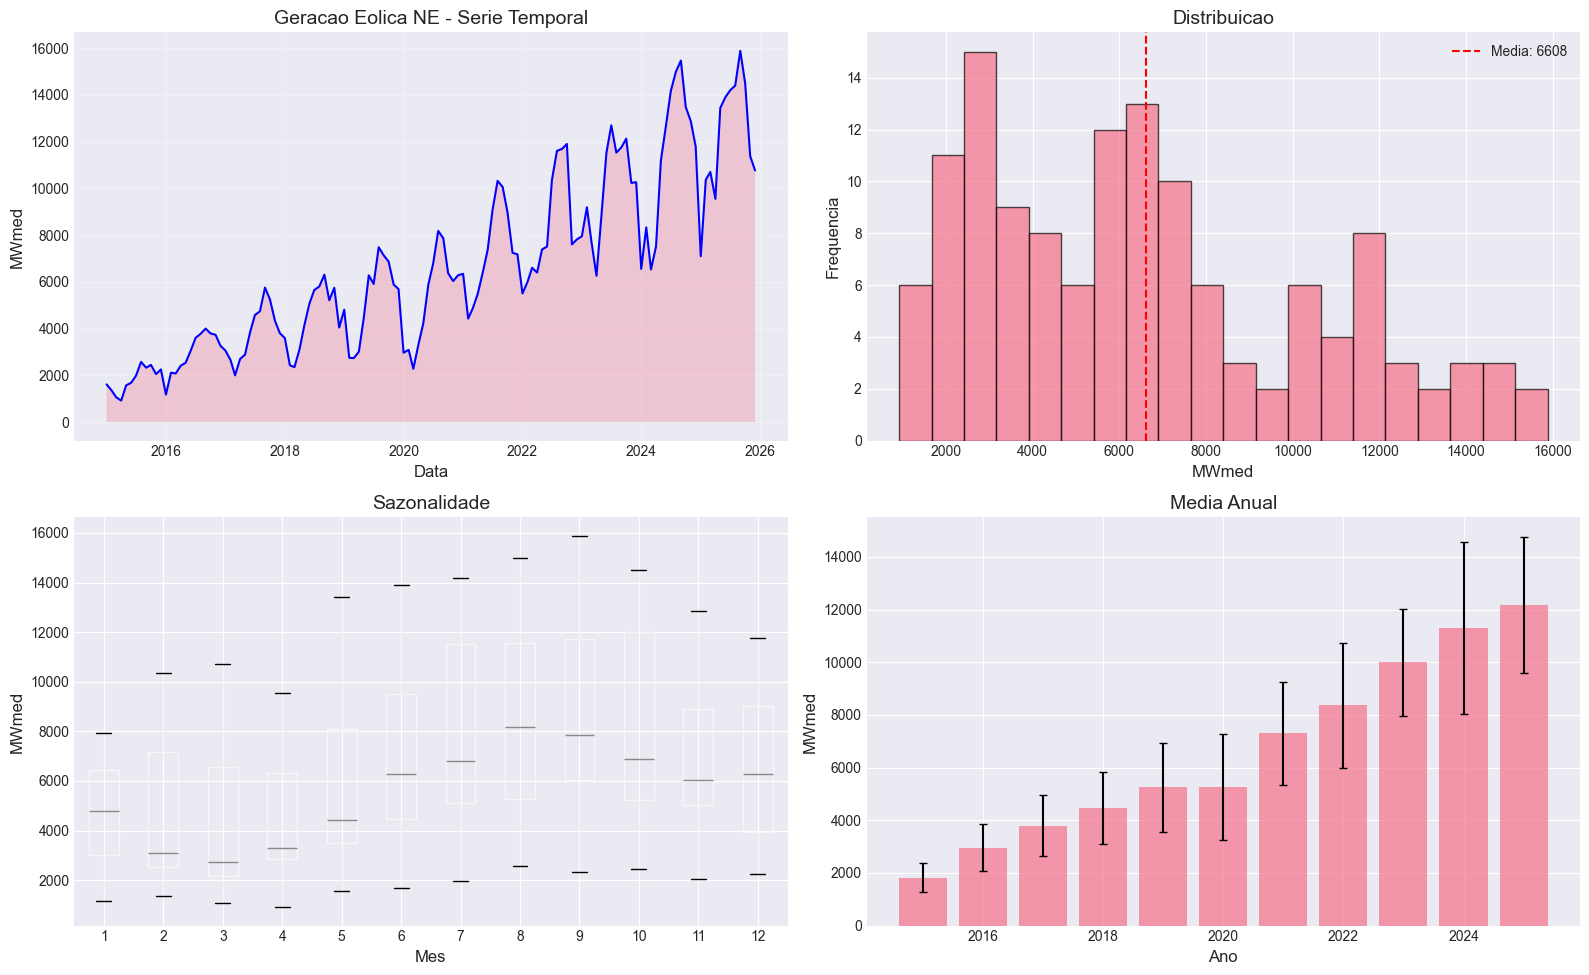


3. ANALISE POR CLUSTER
----------------------------------------------------------------------------------------------------
   Clusters analisados: 10
   Vento medio (min/max): 4.67 / 7.21 m/s


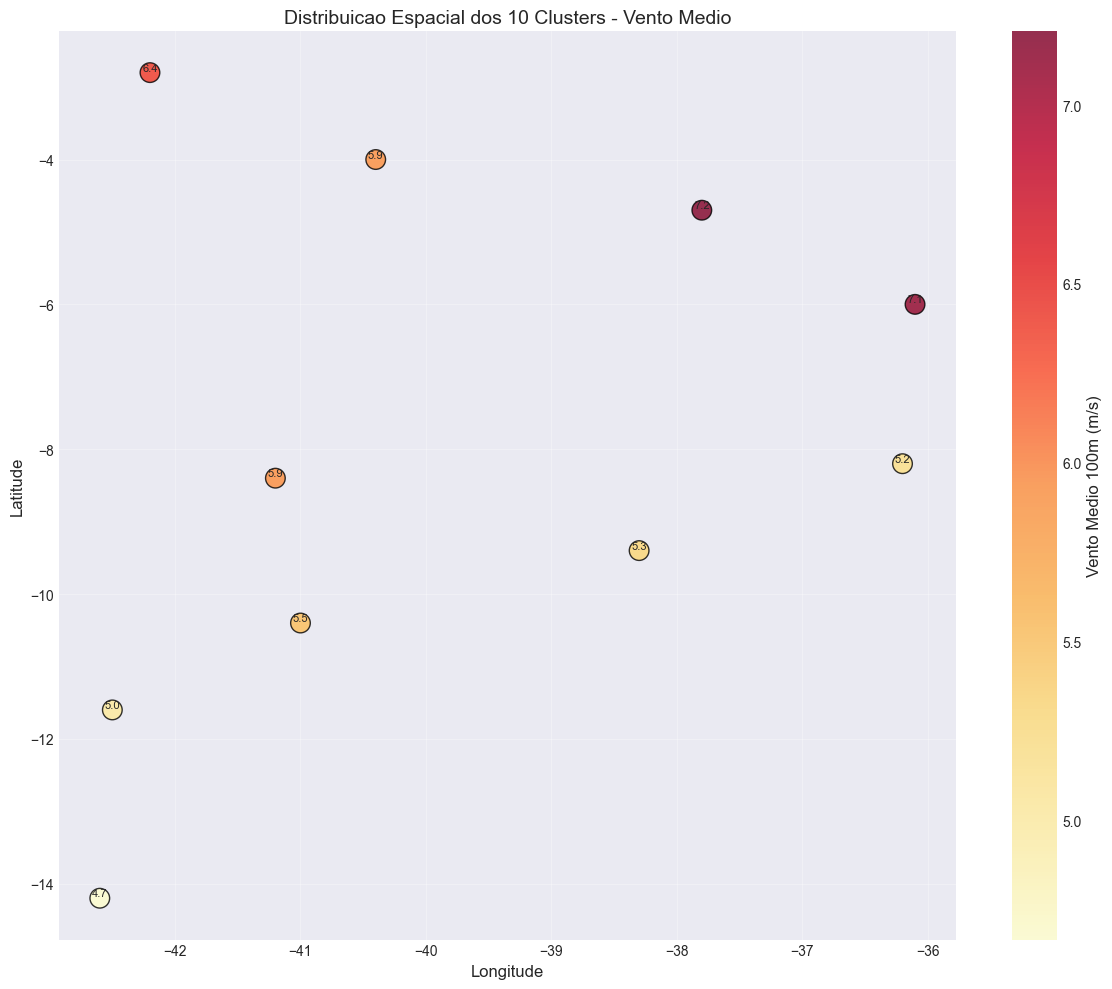


4. CORRELACAO TARGET vs VENTO
----------------------------------------------------------------------------------------------------


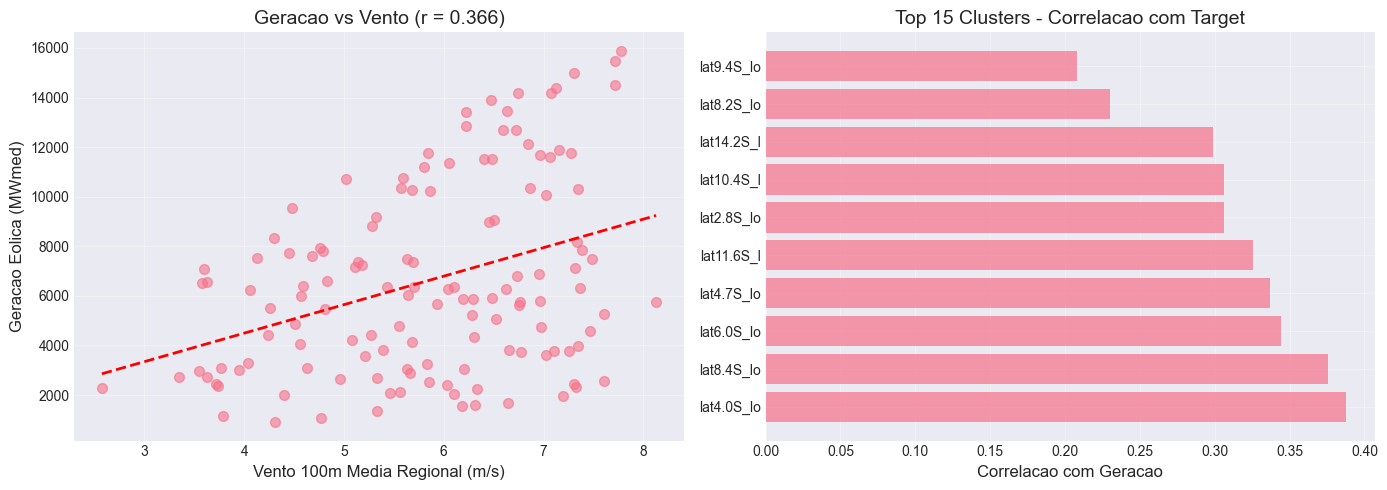

   Correlacao media regional: 0.366
   Cluster mais correlacionado: lat4.0S_lon40.4W (r=0.388)

5. DECOMPOSICAO SAZONAL
----------------------------------------------------------------------------------------------------


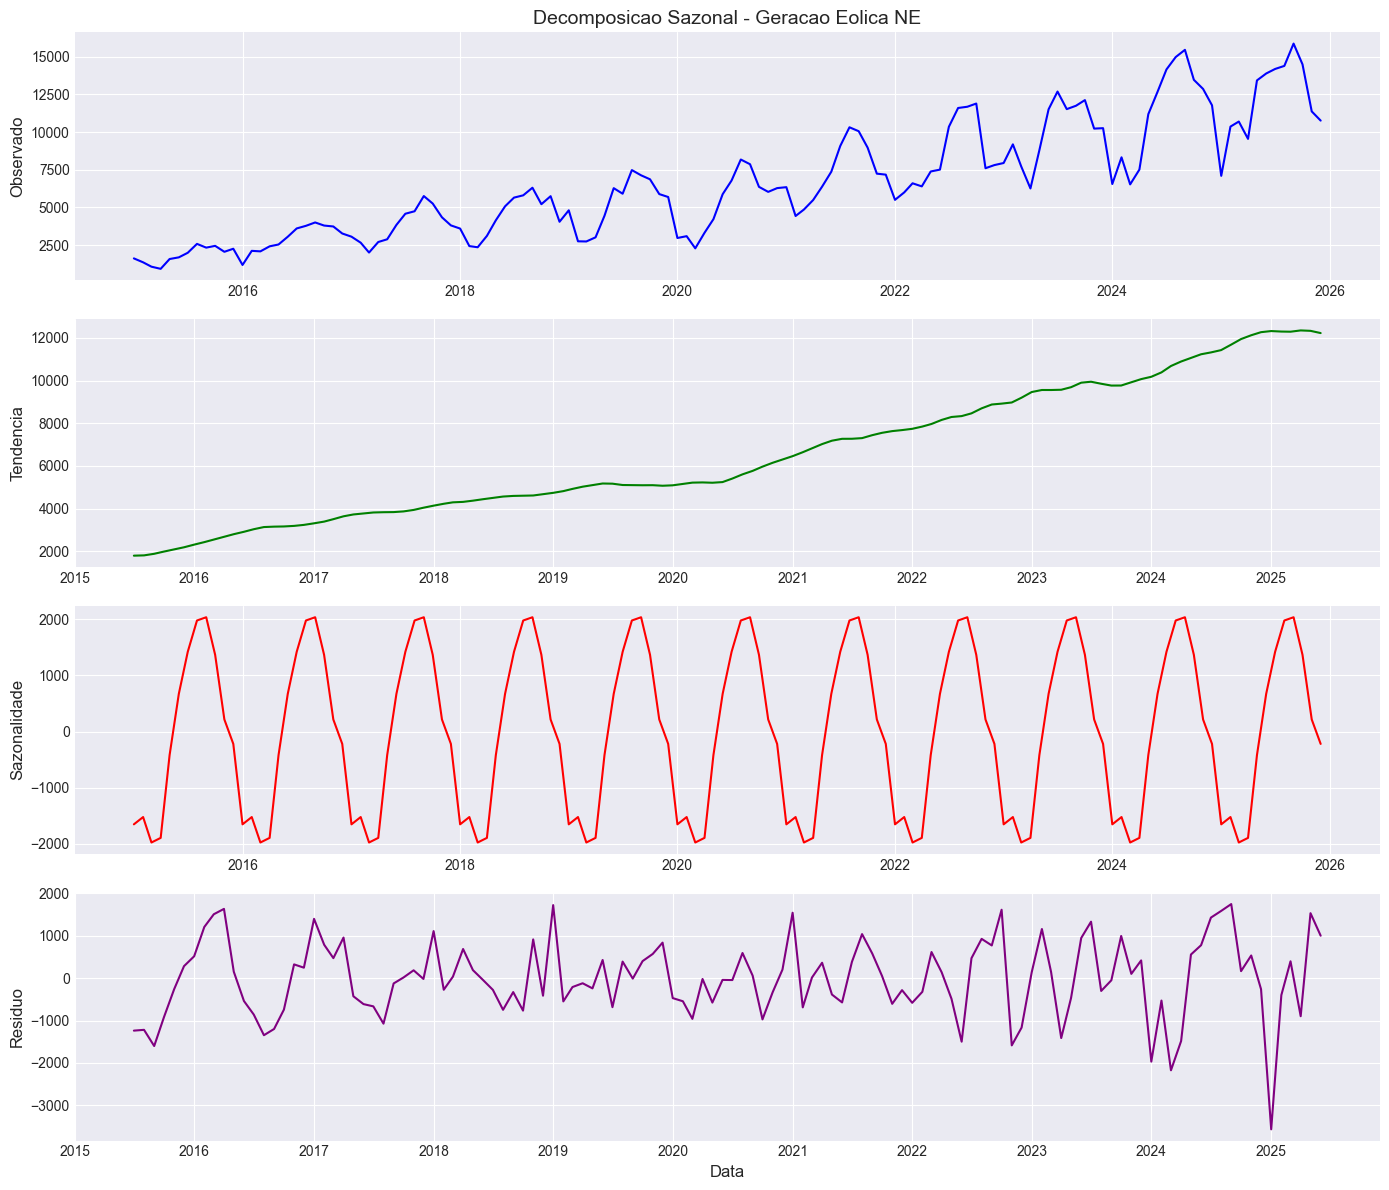


6. RESUMO
----------------------------------------------------------------------------------------------------

RESUMO DA EDA - DATASET COM CLUSTERING ESPACIAL

Dataset: C:\\Users\\Admin\\Documents\\Puc\\IC\\Dados\dataset_final_modelagem.csv
Dimensoes: 132 linhas x 96 colunas
Periodo: 2015-01 a 2025-12

CLUSTERING ESPACIAL:
  - Clusters: 10
  - Reducao: 225 celulas -> 10 clusters

TARGET: geracao_eolica_ne_mwmed
  - Media: 6608.21 MWmed
  - Desvio: 3817.21 MWmed

CORRELACOES:
  - Vento regional vs Geracao: 0.366
  - Melhor cluster: lat4.0S_lon40.4W (r=0.388)
  - Capacidade vs Geracao: 0.888



EDA COMPLETA!


In [154]:
#EDA COMPLETA - DATASET FINAL COM CLUSTERING ESPACIAL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
import os

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# ==============================================================================
# CONFIGURACOES
# ==============================================================================
DADOS_DIR = pasta_dados
DATASET_FILE = os.path.join(DADOS_DIR, 'dataset_final_modelagem.csv')
os.makedirs(EDA_DIR, exist_ok=True)

for subdir in ['validacao', 'series_temporais', 'correlacoes', 'espacial', 'clusters']:
    os.makedirs(os.path.join(EDA_DIR, subdir), exist_ok=True)

print("="*100)
print("EDA COMPLETA - DATASET COM CLUSTERING ESPACIAL")
print("="*100)

# ==============================================================================
# 1. CARREGAMENTO
# ==============================================================================
print("\n1. CARREGAMENTO")
print("-"*100)

df = pd.read_csv(DATASET_FILE)
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data').reset_index(drop=True)

print(f"Dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"Periodo: {df['data'].min().strftime('%Y-%m')} a {df['data'].max().strftime('%Y-%m')}")

# Identificar clusters
cols_vento = [c for c in df.columns if c.startswith('vel_vento_100m_lat')]
n_clusters = len(cols_vento)
print(f"Clusters espaciais: {n_clusters}")

# Extrair nomes dos clusters
cluster_names = [c.replace('vel_vento_100m_', '') for c in cols_vento]
print(f"Exemplo: {cluster_names[:3]}")

# ==============================================================================
# 2. ESTATISTICAS DO TARGET
# ==============================================================================
print("\n2. ESTATISTICAS DO TARGET")
print("-"*100)

target = 'geracao_eolica_ne_mwmed'
print(df[target].describe())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

ax1 = axes[0, 0]
ax1.plot(df['data'], df[target], 'b-', linewidth=1.5)
ax1.fill_between(df['data'], df[target], alpha=0.3)
ax1.set_xlabel('Data')
ax1.set_ylabel('MWmed')
ax1.set_title('Geracao Eolica NE - Serie Temporal')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.hist(df[target], bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(df[target].mean(), color='red', linestyle='--', label=f'Media: {df[target].mean():.0f}')
ax2.set_xlabel('MWmed')
ax2.set_ylabel('Frequencia')
ax2.set_title('Distribuicao')
ax2.legend()

ax3 = axes[1, 0]
df.boxplot(column=target, by='mes', ax=ax3)
ax3.set_xlabel('Mes')
ax3.set_ylabel('MWmed')
ax3.set_title('Sazonalidade')
plt.suptitle('')

ax4 = axes[1, 1]
df_anual = df.groupby('ano')[target].agg(['mean', 'std'])
ax4.bar(df_anual.index, df_anual['mean'], yerr=df_anual['std'], capsize=3, alpha=0.7)
ax4.set_xlabel('Ano')
ax4.set_ylabel('MWmed')
ax4.set_title('Media Anual')

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'series_temporais', '01_target.png'), dpi=150)
plt.show()

# ==============================================================================
# 3. ANALISE POR CLUSTER
# ==============================================================================
print("\n3. ANALISE POR CLUSTER")
print("-"*100)

# Calcular media de vento por cluster
vento_por_cluster = {}
for col in cols_vento:
    cluster_name = col.replace('vel_vento_100m_', '')
    vento_por_cluster[cluster_name] = df[col].mean()

df_clusters = pd.DataFrame({
    'cluster': list(vento_por_cluster.keys()),
    'vento_medio': list(vento_por_cluster.values())
})

# Extrair lat/lon do nome do cluster
def parse_cluster_name(name):
    parts = name.split('_')
    lat_part = parts[0].replace('lat', '')
    lon_part = parts[1].replace('lon', '')
    lat = float(lat_part[:-1]) * (-1 if lat_part.endswith('S') else 1)
    lon = float(lon_part[:-1]) * (-1 if lon_part.endswith('W') else 1)
    return lat, lon

df_clusters['lat'] = df_clusters['cluster'].apply(lambda x: parse_cluster_name(x)[0])
df_clusters['lon'] = df_clusters['cluster'].apply(lambda x: parse_cluster_name(x)[1])

print(f"   Clusters analisados: {len(df_clusters)}")
print(f"   Vento medio (min/max): {df_clusters['vento_medio'].min():.2f} / {df_clusters['vento_medio'].max():.2f} m/s")

# Mapa espacial dos clusters
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(df_clusters['lon'], df_clusters['lat'],
                    c=df_clusters['vento_medio'], cmap='YlOrRd',
                    s=200, alpha=0.8, edgecolors='black')
plt.colorbar(scatter, label='Vento Medio 100m (m/s)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Distribuicao Espacial dos {n_clusters} Clusters - Vento Medio')
ax.grid(True, alpha=0.3)

# Adicionar labels dos clusters
for _, row in df_clusters.iterrows():
    ax.annotate(f"{row['vento_medio']:.1f}", (row['lon'], row['lat']),
                fontsize=8, ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'clusters', '01_mapa_clusters.png'), dpi=150)
plt.show()

# ==============================================================================
# 4. CORRELACAO TARGET vs VENTO (MEDIA REGIONAL)
# ==============================================================================
print("\n4. CORRELACAO TARGET vs VENTO")
print("-"*100)

# Media regional do vento
df['vento_100m_media_regional'] = df[cols_vento].mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.scatter(df['vento_100m_media_regional'], df[target], alpha=0.6, s=50)
z = np.polyfit(df['vento_100m_media_regional'], df[target], 1)
p = np.poly1d(z)
x_line = np.linspace(df['vento_100m_media_regional'].min(), df['vento_100m_media_regional'].max(), 100)
ax1.plot(x_line, p(x_line), 'r--', linewidth=2)
corr = df['vento_100m_media_regional'].corr(df[target])
ax1.set_xlabel('Vento 100m Media Regional (m/s)')
ax1.set_ylabel('Geracao Eolica (MWmed)')
ax1.set_title(f'Geracao vs Vento (r = {corr:.3f})')
ax1.grid(True, alpha=0.3)

# Correlacao por cluster com target
corr_clusters = {}
for col in cols_vento:
    cluster_name = col.replace('vel_vento_100m_', '')
    corr_clusters[cluster_name] = df[col].corr(df[target])

ax2 = axes[1]
clusters_sorted = sorted(corr_clusters.items(), key=lambda x: x[1], reverse=True)
names = [x[0][:10] for x in clusters_sorted[:15]]  # Top 15
values = [x[1] for x in clusters_sorted[:15]]
ax2.barh(names, values, alpha=0.7)
ax2.set_xlabel('Correlacao com Geracao')
ax2.set_title('Top 15 Clusters - Correlacao com Target')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'correlacoes', '01_target_vs_clusters.png'), dpi=150)
plt.show()

print(f"   Correlacao media regional: {corr:.3f}")
print(f"   Cluster mais correlacionado: {clusters_sorted[0][0]} (r={clusters_sorted[0][1]:.3f})")

# ==============================================================================
# 5. DECOMPOSICAO SAZONAL
# ==============================================================================
print("\n5. DECOMPOSICAO SAZONAL")
print("-"*100)

try:
    decomp = seasonal_decompose(df[target], model='additive', period=12)

    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    axes[0].plot(df['data'], decomp.observed, 'b-')
    axes[0].set_ylabel('Observado')
    axes[0].set_title('Decomposicao Sazonal - Geracao Eolica NE')
    axes[1].plot(df['data'], decomp.trend, 'g-')
    axes[1].set_ylabel('Tendencia')
    axes[2].plot(df['data'], decomp.seasonal, 'r-')
    axes[2].set_ylabel('Sazonalidade')
    axes[3].plot(df['data'], decomp.resid, 'purple')
    axes[3].set_ylabel('Residuo')
    axes[3].set_xlabel('Data')

    plt.tight_layout()
    plt.savefig(os.path.join(EDA_DIR, 'series_temporais', '02_decomposicao.png'), dpi=150)
    plt.show()
except Exception as e:
    print(f"   Erro: {e}")

# ==============================================================================
# 6. RESUMO
# ==============================================================================
print("\n6. RESUMO")
print("-"*100)

cols_ons = ['ano', 'mes', 'subsistema', 'geracao_eolica_ne_mwmed', 'capacidade_eolica_ne_mw',
            'carga_ne_mwmed', 'demanda_sin_mwmed', 'demanda_max_sin_mw', 'corte_eolica_ne_mwmed',
            'capacity_factor_ne', 'penetracao_eolica_ne', 'penetracao_eolica_sin',
            'crescimento_capacidade_mw', 'trimestre']

resumo = f"""
================================================================================
RESUMO DA EDA - DATASET COM CLUSTERING ESPACIAL
================================================================================

Dataset: {DATASET_FILE}
Dimensoes: {df.shape[0]} linhas x {df.shape[1]} colunas
Periodo: {df['data'].min().strftime('%Y-%m')} a {df['data'].max().strftime('%Y-%m')}

CLUSTERING ESPACIAL:
  - Clusters: {n_clusters}
  - Reducao: 225 celulas -> {n_clusters} clusters

TARGET: geracao_eolica_ne_mwmed
  - Media: {df[target].mean():.2f} MWmed
  - Desvio: {df[target].std():.2f} MWmed

CORRELACOES:
  - Vento regional vs Geracao: {corr:.3f}
  - Melhor cluster: {clusters_sorted[0][0]} (r={clusters_sorted[0][1]:.3f})
  - Capacidade vs Geracao: {df[target].corr(df['capacidade_eolica_ne_mw']):.3f}

================================================================================
"""

with open(os.path.join(EDA_DIR, 'validacao', '00_resumo.txt'), 'w', encoding='utf-8') as f:
    f.write(resumo)

print(resumo)
print("\n" + "="*100)
print("EDA COMPLETA!")
print("="*100)



## Pipeline dos Modelos

In [ ]:
#Pipeline do Ensemble - Parte 1 e 2: Preparacao de Dados + CNN
#Etapas comuns + Ramo Convolucional

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
import os
import warnings
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

print("="*100)
print("ENSEMBLE - PARTE 1: PREPARACAO DE DADOS")
print("="*100)

# ==============================================================================
# 1. CARREGAR E CONGELAR DATASET
# ==============================================================================
print("\n1. CARREGANDO E CONGELANDO DATASET")
print("-"*100)

df = pd.read_csv(os.path.join(pasta_dados, 'dataset_final_modelagem.csv'))
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data').reset_index(drop=True)

print(f"   Dataset original: {df.shape}")
print(f"   Periodo: {df['data'].min().strftime('%Y-%m')} a {df['data'].max().strftime('%Y-%m')}")

# ==============================================================================
# 2. DEFINIR TARGET
# ==============================================================================
print("\n2. DEFININDO TARGET")
print("-"*100)

TARGET = 'geracao_eolica_ne_mwmed'
print(f"   Target: {TARGET}")

# ==============================================================================
# 3. REMOVER COLUNAS COM VAZAMENTO/INUTEIS
# ==============================================================================
print("\n3. REMOVENDO COLUNAS COM VAZAMENTO OU INUTEIS")
print("-"*100)

# Vazamento
colunas_vazamento = [col for col in df.columns if
    'penetracao' in col.lower() or
    'capacity_factor' in col.lower() #or
    #'corte_eolica' in col.lower()
]

# Constantes
colunas_constantes = [col for col in df.columns if df[col].nunique() <= 1]
if 'subsistema' in df.columns and 'subsistema' not in colunas_constantes:
    colunas_constantes.append('subsistema')

# Remover
colunas_remover = list(set(colunas_vazamento + colunas_constantes))
colunas_remover = [col for col in colunas_remover if col not in [TARGET, 'data']]
df_clean = df.drop(columns=colunas_remover, errors='ignore')

print(f"   Removidas: {len(colunas_remover)} colunas")

# ==============================================================================
# 4. CRIAR FEATURES DE SAZONALIDADE
# ==============================================================================
print("\n4. CRIANDO FEATURES DE SAZONALIDADE")
print("-"*100)

df_clean['mes_sin'] = np.sin(2 * np.pi * df_clean['mes'] / 12)
df_clean['mes_cos'] = np.cos(2 * np.pi * df_clean['mes'] / 12)

# Regime operacional
regimes = []
for _, row in df_clean.iterrows():
    ano = row['ano']
    if ano < 2017:
        regime = 0
    elif ano < 2020:
        regime = 1
    elif ano < 2022:
        regime = 2
    else:
        regime = 3
    regimes.append(regime)
df_clean['regime_operacional'] = regimes

print(f"   Criado: mes_sin, mes_cos, regime_operacional")

# ==============================================================================
# 5. TRATAMENTO DE VARIAVEIS ASSIMETRICAS (PRECIPITACAO)
# ==============================================================================
print("\n5. TRATAMENTO DE VARIAVEIS ASSIMETRICAS")
print("-"*100)

# Identificar colunas de precipitacao (tp)
colunas_tp = [col for col in df_clean.columns if col.startswith('tp_')]

if colunas_tp:
    print(f"   Precipitacao (tp): {len(colunas_tp)} colunas")
    # Aplicar log1p para reduzir assimetria
    for col in colunas_tp:
        # Garantir valores nao-negativos
        df_clean[col] = df_clean[col].clip(lower=0)
        # Aplicar log1p
        df_clean[col] = np.log1p(df_clean[col])
    print(f"   Transformacao log1p aplicada em tp")

# ==============================================================================
# 6. ORGANIZAR FEATURES POR COERENCIA DE VIZINHANCA (CNN)
# ==============================================================================
print("\n6. ORGANIZANDO FEATURES PARA CNN (COERENCIA ESPACIAL)")
print("-"*100)

# Identificar clusters unicos
colunas_vento = [col for col in df_clean.columns if col.startswith('vel_vento_100m_')]
clusters = sorted(set([col.replace('vel_vento_100m_', '') for col in colunas_vento]))
n_clusters = len(clusters)
print(f"   Clusters identificados: {n_clusters}")

# Variaveis meteorologicas priorizadas para CNN (ordem de importancia fisica)
# 1. Vento 100m - sinal mais direto para geracao eolica
# 2. Pressao (sp) - afeta densidade do ar
# 3. Temperatura (t2m) - afeta densidade do ar
# 4. SST - influencia padroes de vento costeiro
# 5. Precipitacao (tp) - indicador de sistemas meteorologicos
# 6. Zust (friction velocity) - turbulencia

# NOTA: Nao incluir densidade_ar para evitar redundancia com (t2m + sp)
# NOTA: Nao incluir capacidade_cluster_mw (nao eh meteorologico)

vars_cnn_priority = ['vel_vento_100m', 'sp', 't2m', 'sst', 'tp', 'zust']

# Construir lista de features organizadas por variavel e cluster
features_cnn_ordered = []
for var in vars_cnn_priority:
    for cluster in clusters:
        col_name = f"{var}_{cluster}"
        if col_name in df_clean.columns:
            features_cnn_ordered.append(col_name)

print(f"   Features CNN ordenadas: {len(features_cnn_ordered)}")
print(f"   Ordem: {vars_cnn_priority}")
print(f"   Estrutura: [var1_cluster1, var1_cluster2, ..., var2_cluster1, ...]")

# Features auxiliares (ONS e sazonalidade) - serao concatenadas depois
features_aux = ['capacidade_eolica_ne_mw', 'carga_ne_mwmed', 'demanda_sin_mwmed',
                'crescimento_capacidade_mw', 'mes_sin', 'mes_cos', 'regime_operacional']
features_aux = [f for f in features_aux if f in df_clean.columns]

print(f"   Features auxiliares: {len(features_aux)}")

# Todas as features (CNN primeiro, depois auxiliares)
colunas_features = features_cnn_ordered + features_aux
n_features_cnn = len(features_cnn_ordered)
n_features_aux = len(features_aux)
n_features_total = len(colunas_features)

print(f"   Total features: {n_features_total} (CNN: {n_features_cnn}, Aux: {n_features_aux})")

# ==============================================================================
# 7. SPLIT TEMPORAL
# ==============================================================================
print("\n7. DEFININDO SPLITS TEMPORAIS")
print("-"*100)

L = 24  # Janela historica
H = 12  # Horizonte

n_total = len(df_clean)
n_train = int(n_total * 0.70)
n_val = int(n_total * 0.15)

df_train = df_clean.iloc[:n_train].copy()
df_val = df_clean.iloc[n_train:n_train+n_val].copy()
df_test = df_clean.iloc[n_train+n_val:].copy()

print(f"   L={L}, H={H}")
print(f"   Treino: {len(df_train)}, Val: {len(df_val)}, Teste: {len(df_test)}")

# ==============================================================================
# 8. NORMALIZACAO
# ==============================================================================
print("\n8. APLICANDO NORMALIZACAO")
print("-"*100)

scaler_features = RobustScaler()
scaler_target = RobustScaler()

X_train = df_train[colunas_features].values
y_train = df_train[TARGET].values.reshape(-1, 1)

scaler_features.fit(X_train)
scaler_target.fit(y_train)

X_train_scaled = scaler_features.transform(X_train)
X_val_scaled = scaler_features.transform(df_val[colunas_features].values)
X_test_scaled = scaler_features.transform(df_test[colunas_features].values)

y_train_scaled = scaler_target.transform(y_train)
y_val_scaled = scaler_target.transform(df_val[TARGET].values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(df_test[TARGET].values.reshape(-1, 1))

print(f"   Scaler: RobustScaler (fit no treino)")

# ==============================================================================
# 9. CRIAR SEQUENCIAS TEMPORAIS
# ==============================================================================
print("\n9. CRIANDO SEQUENCIAS TEMPORAIS")
print("-"*100)

def create_sequences(X, y, L, H):
    X_seq, y_seq = [], []
    for i in range(len(X) - L - H + 1):
        X_seq.append(X[i:i+L])
        y_seq.append(y[i+L:i+L+H].flatten())
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, L, H)

X_tv = np.vstack([X_train_scaled, X_val_scaled])
y_tv = np.vstack([y_train_scaled, y_val_scaled])
X_val_seq_full, y_val_seq_full = create_sequences(X_tv, y_tv, L, H)
n_val_seq = max(0, len(X_val_scaled) - H + 1)
X_val_seq = X_val_seq_full[-n_val_seq:] if n_val_seq > 0 else np.array([]).reshape(0, L, n_features_total)
y_val_seq = y_val_seq_full[-n_val_seq:] if n_val_seq > 0 else np.array([]).reshape(0, H)

X_all = np.vstack([X_train_scaled, X_val_scaled, X_test_scaled])
y_all = np.vstack([y_train_scaled, y_val_scaled, y_test_scaled])
X_test_seq_full, y_test_seq_full = create_sequences(X_all, y_all, L, H)
n_test_seq = max(0, len(X_test_scaled) - H + 1)
X_test_seq = X_test_seq_full[-n_test_seq:] if n_test_seq > 0 else np.array([]).reshape(0, L, n_features_total)
y_test_seq = y_test_seq_full[-n_test_seq:] if n_test_seq > 0 else np.array([]).reshape(0, H)

print(f"   Treino: {X_train_seq.shape}")
print(f"   Val: {X_val_seq.shape}")
print(f"   Teste: {X_test_seq.shape}")

# ==============================================================================
# ==============================================================================
print("\n" + "="*100)
print("ENSEMBLE - PARTE 2: RAMO CNN (CONVOLUCIONAL)")
print("="*100)

# ==============================================================================
# 10. PREPARAR INPUT PARA CNN (RESHAPE ESPACIAL)
# ==============================================================================
print("\n10. PREPARANDO INPUT PARA CNN")
print("-"*100)

# Para CNN, vamos separar features meteorologicas (espaciais) das auxiliares
# Shape para CNN: (batch, timesteps, n_vars, n_clusters) ou (batch, timesteps, features)

# Opcao 1: CNN 1D sobre todas as features (mais simples)
# Opcao 2: CNN 2D com reshape (timesteps x clusters x vars) - captura espacial

# Vamos usar CNN 1D com features ordenadas por coerencia espacial
# O ordenamento ja garante que clusters proximos estao em posicoes proximas

# Separar features CNN das auxiliares nas sequencias
X_train_cnn = X_train_seq[:, :, :n_features_cnn]  # Features meteorologicas
X_train_aux = X_train_seq[:, :, n_features_cnn:]  # Features auxiliares

X_val_cnn = X_val_seq[:, :, :n_features_cnn] if len(X_val_seq) > 0 else np.array([])
X_val_aux = X_val_seq[:, :, n_features_cnn:] if len(X_val_seq) > 0 else np.array([])

X_test_cnn = X_test_seq[:, :, :n_features_cnn] if len(X_test_seq) > 0 else np.array([])
X_test_aux = X_test_seq[:, :, n_features_cnn:] if len(X_test_seq) > 0 else np.array([])

print(f"   X_train_cnn: {X_train_cnn.shape} (batch, L, features_meteo)")
print(f"   X_train_aux: {X_train_aux.shape} (batch, L, features_aux)")

# ==============================================================================
# 11. DEFINIR ARQUITETURA CNN 1D
# ==============================================================================
print("\n11. DEFININDO ARQUITETURA CNN 1D")
print("-"*100)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization,
                                      Dropout, Flatten, Dense, concatenate,
                                      GlobalAveragePooling1D, Add, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Seed para reproducibilidade
tf.random.set_seed(42)
np.random.seed(42)

def build_cnn_branch(input_shape_cnn=None, input_shape_aux=None, output_dim=None, name='cnn_branch', seq_shape=None, aux_shape=None):
    """
    Ramo CNN para compressao de sinais meteorologicos.

    Arquitetura:
    - Conv1D com kernels pequenos para capturar padroes temporais locais
    - Organizacao de features permite captura implicita de padroes espaciais
    - BatchNorm + Dropout para regularizacao
    - GlobalAveragePooling para compressao robusta
    - Concatena features auxiliares no final
    - Output: embedding comprimido para ensemble
    """
    # Compatibilidade: aceitar seq_shape/aux_shape como alias
    if seq_shape is not None: input_shape_cnn = seq_shape
    if aux_shape is not None: input_shape_aux = aux_shape

    # Input meteorologico (para CNN)
    input_cnn = Input(shape=input_shape_cnn, name='input_meteo')

    # Input auxiliar (ONS + sazonalidade)
    input_aux = Input(shape=input_shape_aux, name='input_aux')

    # === Bloco CNN 1: Padroes temporais de curto prazo ===
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_cnn)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # === Bloco CNN 2: Padroes temporais de medio prazo ===
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # === Bloco CNN 3: Padroes de longo prazo ===
    x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # === Compressao Global ===
    # GlobalAveragePooling preserva tendencias sem memorizar ruidos
    x = GlobalAveragePooling1D()(x)

    # === Processar features auxiliares ===
    # Pegar apenas o ultimo timestep das auxiliares (estado atual)
    aux_last = tf.keras.layers.Lambda(lambda t: t[:, -1, :])(input_aux)
    aux = Dense(32, activation='relu')(aux_last)
    aux = BatchNormalization()(aux)
    aux = Dropout(0.2)(aux)

    # === Concatenar CNN + Auxiliares ===
    combined = concatenate([x, aux])

    # === Camadas densas finais ===
    combined = Dense(128, activation='relu')(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.3)(combined)

    combined = Dense(64, activation='relu')(combined)
    combined = BatchNormalization()(combined)

    # === Output: previsao de H meses ===
    output = Dense(output_dim, activation='linear', name='output')(combined)

    model = Model(inputs=[input_cnn, input_aux], outputs=output, name=name)

    return model

# Construir modelo
input_shape_cnn = (L, n_features_cnn)
input_shape_aux = (L, n_features_aux)

model_cnn = build_cnn_branch(input_shape_cnn, input_shape_aux, H, name='cnn_wind_forecast')

# Compilar
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(f"   Input CNN: {input_shape_cnn}")
print(f"   Input Aux: {input_shape_aux}")
print(f"   Output: {H} meses")
print(f"\n   Arquitetura:")
model_cnn.summary()

# ==============================================================================
# 12. TREINAR CNN
# ==============================================================================
print("\n12. TREINANDO CNN")
print("-"*100)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Preparar dados de validacao
if len(X_val_cnn) > 0:
    validation_data = ([X_val_cnn, X_val_aux], y_val_seq)
else:
    # Se nao tiver validacao suficiente, usar parte do treino
    val_split = 0.15
    validation_data = None

print(f"   Treinando por ate 100 epochs com early stopping...")

history_cnn = model_cnn.fit(
    [X_train_cnn, X_train_aux],
    y_train_seq,
    epochs=100,
    batch_size=16,
    validation_data=validation_data,
    validation_split=0.15 if validation_data is None else 0.0,
    callbacks=callbacks,
    verbose=1
)

print(f"\n   Treino concluido!")
print(f"   Epochs: {len(history_cnn.history['loss'])}")
print(f"   Loss final (treino): {history_cnn.history['loss'][-1]:.4f}")
if 'val_loss' in history_cnn.history:
    print(f"   Loss final (val): {history_cnn.history['val_loss'][-1]:.4f}")

# ==============================================================================
# 13. AVALIAR CNN
# ==============================================================================
print("\n13. AVALIANDO CNN")
print("-"*100)

# Previsoes no treino
y_pred_train_cnn = model_cnn.predict([X_train_cnn, X_train_aux], verbose=0)

# Previsoes no teste (se disponivel)
if len(X_test_cnn) > 0:
    y_pred_test_cnn = model_cnn.predict([X_test_cnn, X_test_aux], verbose=0)

    # Desnormalizar para calcular metricas reais
    y_test_real = scaler_target.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)
    y_pred_test_real = scaler_target.inverse_transform(y_pred_test_cnn.reshape(-1, 1)).reshape(y_pred_test_cnn.shape)

    # Metricas
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    rmse_test = np.sqrt(mean_squared_error(y_test_real.flatten(), y_pred_test_real.flatten()))
    mae_test = mean_absolute_error(y_test_real.flatten(), y_pred_test_real.flatten())

    print(f"   Metricas no Teste (desnormalizadas):")
    print(f"      RMSE: {rmse_test:.2f} MWmed")
    print(f"      MAE: {mae_test:.2f} MWmed")

    # Metricas por horizonte
    print(f"\n   Metricas por horizonte de previsao:")
    for h in range(H):
        rmse_h = np.sqrt(mean_squared_error(y_test_real[:, h], y_pred_test_real[:, h]))
        mae_h = mean_absolute_error(y_test_real[:, h], y_pred_test_real[:, h])
        print(f"      h+{h+1}: RMSE={rmse_h:.2f}, MAE={mae_h:.2f}")

# ==============================================================================
# 14. EXTRAIR EMBEDDINGS DA CNN (PARA ENSEMBLE)
# ==============================================================================
print("\n14. EXTRAINDO EMBEDDINGS DA CNN")
print("-"*100)

# Criar modelo intermediario para extrair embeddings (antes da camada de output)
# O embedding eh a saida da penultima camada densa

layer_names = [layer.name for layer in model_cnn.layers]
# Encontrar a camada antes do output
embedding_layer_name = None
for i, name in enumerate(layer_names):
    if 'output' in name.lower():
        # Pegar a camada anterior
        embedding_layer_name = layer_names[i-1]
        break

if embedding_layer_name:
    embedding_model = Model(
        inputs=model_cnn.input,
        outputs=model_cnn.get_layer(embedding_layer_name).output,
        name='cnn_embedding_extractor'
    )

    # Extrair embeddings
    emb_train_cnn = embedding_model.predict([X_train_cnn, X_train_aux], verbose=0)
    emb_test_cnn = embedding_model.predict([X_test_cnn, X_test_aux], verbose=0) if len(X_test_cnn) > 0 else None

    print(f"   Embedding shape: {emb_train_cnn.shape}")
    print(f"   Embedding extraido da camada: {embedding_layer_name}")

# ==============================================================================
# 15. SALVAR MODELO E RESULTADOS CNN
# ==============================================================================
print("\n15. SALVANDO MODELO CNN")
print("-"*100)


os.makedirs(model_dir, exist_ok=True)

# Salvar modelo
model_cnn.save(os.path.join(model_dir, 'model_cnn.h5'))
print(f"   Modelo salvo: model_cnn.h5")

# Salvar historico
import json
history_dict = {k: [float(v) for v in vals] for k, vals in history_cnn.history.items()}
with open(os.path.join(model_dir, 'history_cnn.json'), 'w') as f:
    json.dump(history_dict, f)
print(f"   Historico salvo: history_cnn.json")

# Salvar embeddings para ensemble
np.save(os.path.join(model_dir, 'emb_train_cnn.npy'), emb_train_cnn)
if emb_test_cnn is not None:
    np.save(os.path.join(model_dir, 'emb_test_cnn.npy'), emb_test_cnn)
print(f"   Embeddings salvos")


# ==============================================================================
# ==============================================================================
print("\n" + "="*100)
print("ENSEMBLE - PARTE 3: RAMO LSTM (RECORRENTE)")
print("="*100)

# ==============================================================================
# 16. PREPARAR FEATURES PARA LSTM
# ==============================================================================
print("\n16. PREPARANDO FEATURES PARA LSTM")
print("-"*100)

# LSTM foca em dependencias temporais de medio prazo:
# - Sazonalidade anual
# - Persistencia entre meses
# - Mudancas graduais de regime

# Features para LSTM (com dinamica temporal propria):
# 1. Capacidade eolica NE (exogena observada)
# 2. Demanda media e pico do SIN
# 3. Carga do NE
# 4. Series meteorologicas agregadas por cluster
# 5. Features ciclicas (mes_sin, mes_cos) - NAO mes como numero!
# 6. Regime operacional

# Nota: L=24 meses permite ver 2 ciclos anuais completos

# Verificar que L > 12 (mais de um ciclo anual)
if L <= 12:
    print(f"   AVISO: L={L} pode ser insuficiente para LSTM capturar sazonalidade")
    print(f"   Recomendado: L >= 24 para ver mais de um ciclo anual")
else:
    print(f"   OK: L={L} permite ver {L/12:.1f} ciclos anuais")

# Para LSTM, usamos TODAS as features (meteorologicas + auxiliares)
# A ordem ja esta definida: features_cnn_ordered + features_aux
# Isso garante consistencia com CNN

print(f"   Features para LSTM: {n_features_total}")
print(f"      - Meteorologicas (por cluster): {n_features_cnn}")
print(f"      - Auxiliares (ONS + ciclicas): {n_features_aux}")

# Verificar que 'mes' NAO esta nas features (evitar numero inteiro)
if 'mes' in colunas_features:
    print(f"   AVISO: 'mes' esta nas features - LSTM aprende melhor com ciclicas!")
else:
    print(f"   OK: Usando mes_sin/mes_cos em vez de 'mes' inteiro")

# ==============================================================================
# 17. DEFINIR ARQUITETURA LSTM
# ==============================================================================
print("\n17. DEFININDO ARQUITETURA LSTM")
print("-"*100)

from tensorflow.keras.layers import LSTM, Bidirectional, RepeatVector, TimeDistributed

def build_lstm_branch(input_shape, output_dim, name='lstm_branch'):
    """
    Ramo LSTM para capturar dependencias temporais de medio prazo.

    Arquitetura Encoder-Decoder:
    - Encoder: Bidirectional LSTM para capturar contexto passado e futuro
    - Estado latente: compressao da memoria temporal
    - Decoder: LSTM para gerar sequencia de previsao

    Foco:
    - Sazonalidade anual (ciclos de 12 meses)
    - Persistencia entre meses consecutivos
    - Mudancas graduais de regime
    """

    input_lstm = Input(shape=input_shape, name='input_lstm')

    # === Encoder: Captura dependencias temporais ===
    # Bidirectional para ver contexto em ambas direcoes
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(input_lstm)
    x = BatchNormalization()(x)

    # Segunda camada LSTM para hierarquia de features temporais
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1))(x)
    x = BatchNormalization()(x)

    # === Estado Latente ===
    # Representa a "memoria" comprimida do sistema
    latent = Dense(64, activation='relu')(x)
    latent = BatchNormalization()(latent)
    latent = Dropout(0.3)(latent)

    # === Decoder: Gera previsao para H meses ===
    # Repetir estado latente H vezes
    decoder_input = RepeatVector(output_dim)(latent)

    # LSTM decoder
    decoder = LSTM(64, return_sequences=True, dropout=0.2)(decoder_input)
    decoder = BatchNormalization()(decoder)

    # Projecao final para cada timestep
    decoder = TimeDistributed(Dense(32, activation='relu'))(decoder)
    decoder = TimeDistributed(Dense(1, activation='linear'))(decoder)

    # Flatten para output (batch, H)
    output = tf.keras.layers.Reshape((output_dim,))(decoder)

    model = Model(inputs=input_lstm, outputs=output, name=name)

    return model

# Construir modelo LSTM
input_shape_lstm = (L, n_features_total)

model_lstm = build_lstm_branch(input_shape_lstm, H, name='lstm_temporal_forecast')

# Compilar
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(f"   Input: {input_shape_lstm} (L timesteps x todas features)")
print(f"   Output: {H} meses")
print(f"\n   Arquitetura:")
model_lstm.summary()

# ==============================================================================
# 18. TREINAR LSTM
# ==============================================================================
print("\n18. TREINANDO LSTM")
print("-"*100)

# Callbacks
callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

# Preparar dados - LSTM usa sequencia completa (todas as features)
if len(X_val_seq) > 0:
    validation_data_lstm = (X_val_seq, y_val_seq)
else:
    validation_data_lstm = None

print(f"   Treinando por ate 150 epochs com early stopping...")
print(f"   Batch size: 8 (menor para LSTM estabilizar)")

history_lstm = model_lstm.fit(
    X_train_seq,
    y_train_seq,
    epochs=150,
    batch_size=8,
    validation_data=validation_data_lstm,
    validation_split=0.15 if validation_data_lstm is None else 0.0,
    callbacks=callbacks_lstm,
    verbose=1
)

print(f"\n   Treino concluido!")
print(f"   Epochs: {len(history_lstm.history['loss'])}")
print(f"   Loss final (treino): {history_lstm.history['loss'][-1]:.4f}")
if 'val_loss' in history_lstm.history:
    print(f"   Loss final (val): {history_lstm.history['val_loss'][-1]:.4f}")

# ==============================================================================
# 19. AVALIAR LSTM
# ==============================================================================
print("\n19. AVALIANDO LSTM")
print("-"*100)

# Previsoes
y_pred_train_lstm = model_lstm.predict(X_train_seq, verbose=0)

if len(X_test_seq) > 0:
    y_pred_test_lstm = model_lstm.predict(X_test_seq, verbose=0)

    # Desnormalizar
    y_test_real_lstm = scaler_target.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)
    y_pred_test_real_lstm = scaler_target.inverse_transform(y_pred_test_lstm.reshape(-1, 1)).reshape(y_pred_test_lstm.shape)

    # Metricas
    rmse_test_lstm = np.sqrt(mean_squared_error(y_test_real_lstm.flatten(), y_pred_test_real_lstm.flatten()))
    mae_test_lstm = mean_absolute_error(y_test_real_lstm.flatten(), y_pred_test_real_lstm.flatten())

    print(f"   Metricas no Teste (desnormalizadas):")
    print(f"      RMSE: {rmse_test_lstm:.2f} MWmed")
    print(f"      MAE: {mae_test_lstm:.2f} MWmed")

    # Comparar com CNN
    print(f"\n   Comparacao CNN vs LSTM:")
    print(f"      CNN  - RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}")
    print(f"      LSTM - RMSE: {rmse_test_lstm:.2f}, MAE: {mae_test_lstm:.2f}")

    # Metricas por horizonte
    print(f"\n   LSTM - Metricas por horizonte:")
    for h in range(H):
        rmse_h = np.sqrt(mean_squared_error(y_test_real_lstm[:, h], y_pred_test_real_lstm[:, h]))
        mae_h = mean_absolute_error(y_test_real_lstm[:, h], y_pred_test_real_lstm[:, h])
        print(f"      h+{h+1}: RMSE={rmse_h:.2f}, MAE={mae_h:.2f}")

# ==============================================================================
# 20. EXTRAIR EMBEDDINGS DO LSTM (PARA ENSEMBLE)
# ==============================================================================
print("\n20. EXTRAINDO EMBEDDINGS DO LSTM")
print("-"*100)

# Extrair estado latente (antes do decoder)
# Encontrar a camada de estado latente

lstm_layer_names = [layer.name for layer in model_lstm.layers]
# Procurar pela camada densa antes do RepeatVector
latent_layer_name = None
for i, name in enumerate(lstm_layer_names):
    if 'repeat_vector' in name.lower():
        # Pegar a camada anterior (deve ser dense ou batch_norm)
        latent_layer_name = lstm_layer_names[i-1]
        break

if latent_layer_name:
    embedding_model_lstm = Model(
        inputs=model_lstm.input,
        outputs=model_lstm.get_layer(latent_layer_name).output,
        name='lstm_embedding_extractor'
    )

    emb_train_lstm = embedding_model_lstm.predict(X_train_seq, verbose=0)
    emb_test_lstm = embedding_model_lstm.predict(X_test_seq, verbose=0) if len(X_test_seq) > 0 else None

    print(f"   Embedding shape: {emb_train_lstm.shape}")
    print(f"   Embedding extraido da camada: {latent_layer_name}")
else:
    # Fallback: usar saida da segunda Bidirectional LSTM
    for layer in model_lstm.layers:
        if 'bidirectional' in layer.name.lower():
            latent_layer_name = layer.name

    if latent_layer_name:
        embedding_model_lstm = Model(
            inputs=model_lstm.input,
            outputs=model_lstm.get_layer(latent_layer_name).output,
            name='lstm_embedding_extractor'
        )
        emb_train_lstm = embedding_model_lstm.predict(X_train_seq, verbose=0)
        emb_test_lstm = embedding_model_lstm.predict(X_test_seq, verbose=0) if len(X_test_seq) > 0 else None
        print(f"   Embedding shape: {emb_train_lstm.shape}")

# ==============================================================================
# 21. SALVAR MODELO E RESULTADOS LSTM
# ==============================================================================
print("\n21. SALVANDO MODELO LSTM")
print("-"*100)

# Salvar modelo
model_lstm.save(os.path.join(model_dir, 'model_lstm.h5'))
print(f"   Modelo salvo: model_lstm.h5")

# Salvar historico
history_lstm_dict = {k: [float(v) for v in vals] for k, vals in history_lstm.history.items()}
with open(os.path.join(model_dir, 'history_lstm.json'), 'w') as f:
    json.dump(history_lstm_dict, f)
print(f"   Historico salvo: history_lstm.json")

# Salvar embeddings
np.save(os.path.join(model_dir, 'emb_train_lstm.npy'), emb_train_lstm)
if emb_test_lstm is not None:
    np.save(os.path.join(model_dir, 'emb_test_lstm.npy'), emb_test_lstm)
print(f"   Embeddings salvos")

# ==============================================================================
# RESUMO LSTM
# ==============================================================================
print("\n" + "="*100)
print("LSTM BRANCH CONCLUIDO!")
print("="*100)

print(f"""
RESUMO DO RAMO LSTM:

  Arquitetura Encoder-Decoder:
    - Input: {input_shape_lstm} (L={L} timesteps, captura {L/12:.1f} ciclos anuais)
    - Encoder: Bidirectional LSTM (128) + Bidirectional LSTM (64)
    - Estado Latente: Dense(64)
    - Decoder: LSTM(64) + TimeDistributed Dense
    - Output: {H} meses de previsao

  Foco temporal:
    - Sazonalidade anual (ciclos de 12 meses)
    - Persistencia entre meses
    - Mudancas graduais de regime

  Features:
    - Todas as features ({n_features_total})
    - Ciclicas (mes_sin, mes_cos) em vez de 'mes' inteiro
    - Consistencia treino/val/test garantida

  Treinamento:
    - Epochs: {len(history_lstm.history['loss'])}
    - Loss final: {history_lstm.history['loss'][-1]:.4f}

  Embedding extraido: {emb_train_lstm.shape[1]} dimensoes
  (Pronto para concatenar com CNN e Informer no ensemble)

PROXIMO PASSO: Implementar Informer
""")
print("="*100)

# Manter em memoria
LSTM_RESULTS = {
    'model': model_lstm,
    'history': history_lstm,
    'embeddings_train': emb_train_lstm,
    'embeddings_test': emb_test_lstm,
    'predictions_test': y_pred_test_lstm if len(X_test_seq) > 0 else None
}



# ==============================================================================
# ==============================================================================
print("\n" + "="*100)
print("ENSEMBLE - PARTE 4: INFORMER (IMPLEMENTACAO REAL)")
print("="*100)

# ==============================================================================
# 22. PREPARAR DADOS PARA INFORMER (SEQ_LEN, LABEL_LEN, PRED_LEN)
# ==============================================================================
print("\n22. PREPARANDO DADOS PARA INFORMER")
print("-"*100)

# Configuracao do Informer
# seq_len: comprimento da sequencia de entrada do encoder
# label_len: parte do encoder que eh passada ao decoder (overlap)
# pred_len: horizonte de previsao

seq_len = L  # Janela historica (24 meses)
label_len = min(12, L // 2)  # Overlap encoder-decoder (12 meses ou metade de L)
pred_len = H  # Horizonte de previsao (12 meses)

print(f"   seq_len: {seq_len} (janela historica)")
print(f"   label_len: {label_len} (overlap encoder-decoder)")
print(f"   pred_len: {pred_len} (horizonte de previsao)")

# Separar features: time features (calendario) vs data features
time_features = ['mes_sin', 'mes_cos']
data_features = [f for f in colunas_features if f not in time_features]

idx_data = [colunas_features.index(f) for f in data_features]
idx_time = [colunas_features.index(f) for f in time_features]

n_data = len(data_features)
n_time = len(time_features)

print(f"   Data features: {n_data}")
print(f"   Time features: {n_time}")

# ==============================================================================
# 23. GERAR SEQUENCIAS NO FORMATO INFORMER
# ==============================================================================
print("\n23. GERANDO SEQUENCIAS NO FORMATO INFORMER")
print("-"*100)

def create_informer_data(X, y, seq_len, label_len, pred_len, idx_data, idx_time):
    """
    Cria dados no formato esperado pelo Informer:

    Encoder:
      x_enc: (batch, seq_len, n_data) - features de dados
      x_mark_enc: (batch, seq_len, n_time) - time features do encoder

    Decoder:
      x_dec: (batch, label_len + pred_len, n_data) - [ultimos label_len do encoder] + [zeros]
      x_mark_dec: (batch, label_len + pred_len, n_time) - time features do decoder

    Target:
      y: (batch, pred_len) - valores a prever
    """
    x_enc_list, x_mark_enc_list = [], []
    x_dec_list, x_mark_dec_list = [], []
    y_list = []

    n_samples = len(X) - seq_len - pred_len + 1

    for i in range(n_samples):
        # Encoder input: [i : i + seq_len]
        x_enc_list.append(X[i:i+seq_len][:, idx_data])
        x_mark_enc_list.append(X[i:i+seq_len][:, idx_time])

        # Decoder input: ultimos label_len do encoder + zeros para pred_len
        dec_start = i + seq_len - label_len
        dec_end = i + seq_len + pred_len

        # Parte label (ultimos label_len do encoder)
        x_dec_label = X[dec_start:dec_start+label_len][:, idx_data]
        # Parte pred (zeros - nao conhecemos o futuro)
        x_dec_pred = np.zeros((pred_len, len(idx_data)))
        x_dec = np.vstack([x_dec_label, x_dec_pred])
        x_dec_list.append(x_dec)

        # Time features do decoder (conhecemos para todo o horizonte)
        if dec_end <= len(X):
            x_mark_dec_list.append(X[dec_start:dec_end][:, idx_time])
        else:
            # Projetar time features ciclicas para alem dos dados
            mark_dec = []
            for j in range(label_len + pred_len):
                idx = dec_start + j
                if idx < len(X):
                    mark_dec.append(X[idx, idx_time])
                else:
                    # Ciclo anual para mes_sin/mes_cos
                    ref_idx = idx % 12 if idx % 12 < len(X) else 0
                    mark_dec.append(X[ref_idx, idx_time])
            x_mark_dec_list.append(np.array(mark_dec))

        # Target: valores de [i + seq_len : i + seq_len + pred_len]
        y_list.append(y[i+seq_len:i+seq_len+pred_len].flatten())

    return {
        'x_enc': np.array(x_enc_list),
        'x_mark_enc': np.array(x_mark_enc_list),
        'x_dec': np.array(x_dec_list),
        'x_mark_dec': np.array(x_mark_dec_list),
        'y': np.array(y_list)
    }

# Gerar dados para treino
train_data = create_informer_data(X_train_scaled, y_train_scaled, seq_len, label_len, pred_len, idx_data, idx_time)
print(f"   Treino:")
print(f"      x_enc: {train_data['x_enc'].shape}")
print(f"      x_mark_enc: {train_data['x_mark_enc'].shape}")
print(f"      x_dec: {train_data['x_dec'].shape}")
print(f"      x_mark_dec: {train_data['x_mark_dec'].shape}")
print(f"      y: {train_data['y'].shape}")

# Validacao e Teste
X_tv = np.vstack([X_train_scaled, X_val_scaled])
y_tv = np.vstack([y_train_scaled, y_val_scaled])
tv_data = create_informer_data(X_tv, y_tv, seq_len, label_len, pred_len, idx_data, idx_time)

n_train_inf = len(train_data['y'])
n_val_inf = max(0, len(tv_data['y']) - n_train_inf)

val_data = {k: v[-n_val_inf:] if n_val_inf > 0 else np.array([]).reshape(0, *v.shape[1:])
            for k, v in tv_data.items()}

print(f"   Validacao: x_enc={val_data['x_enc'].shape}, y={val_data['y'].shape}")

# Teste
X_all = np.vstack([X_train_scaled, X_val_scaled, X_test_scaled])
y_all = np.vstack([y_train_scaled, y_val_scaled, y_test_scaled])
all_data = create_informer_data(X_all, y_all, seq_len, label_len, pred_len, idx_data, idx_time)

n_test_inf = max(0, len(X_test_scaled) - pred_len + 1)
test_data = {k: v[-n_test_inf:] if n_test_inf > 0 else np.array([]).reshape(0, *v.shape[1:])
             for k, v in all_data.items()}

print(f"   Teste: x_enc={test_data['x_enc'].shape}, y={test_data['y'].shape}")

# ==============================================================================
# 24. DEFINIR PROBSPARSE ATTENTION (COMPONENTE CHAVE DO INFORMER)
# ==============================================================================
print("\n24. DEFININDO PROBSPARSE ATTENTION")
print("-"*100)

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Conv1D, MaxPooling1D

class ProbSparseAttention(Layer):
    """
    ProbSparse Self-Attention simplificada para Informer.

    Implementa atencao com sparsity via threshold - compativel com graph mode.
    Para sequencias curtas (como as nossas), usa full attention com
    regularizacao de sparsity.
    """

    def __init__(self, d_model=64, n_heads=4, factor=5, dropout=0.1, **kwargs):
        super(ProbSparseAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.factor = factor
        self.dropout_rate = dropout

        self.W_Q = Dense(d_model, use_bias=False)
        self.W_K = Dense(d_model, use_bias=False)
        self.W_V = Dense(d_model, use_bias=False)
        self.W_O = Dense(d_model)
        self.dropout_layer = Dropout(dropout)

    def call(self, queries, keys, values, training=None):
        B = tf.shape(queries)[0]
        L_Q = tf.shape(queries)[1]
        L_K = tf.shape(keys)[1]

        # Projecoes lineares
        Q = self.W_Q(queries)
        K = self.W_K(keys)
        V = self.W_V(values)

        # Reshape para multi-head: (B, L, d_model) -> (B, n_heads, L, d_k)
        Q = tf.reshape(Q, (B, L_Q, self.n_heads, self.d_k))
        Q = tf.transpose(Q, [0, 2, 1, 3])
        K = tf.reshape(K, (B, L_K, self.n_heads, self.d_k))
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.reshape(V, (B, L_K, self.n_heads, self.d_k))
        V = tf.transpose(V, [0, 2, 1, 3])

        # Scaled dot-product attention
        scale = tf.math.sqrt(tf.cast(self.d_k, tf.float32))
        scores = tf.matmul(Q, K, transpose_b=True) / scale  # (B, n_heads, L_Q, L_K)

        # Softmax para obter pesos de atencao
        attn_weights = tf.nn.softmax(scores, axis=-1)

        # ProbSparse: aplicar sparsity via threshold
        # Zera atencoes muito pequenas (abaixo de 1/L_K)
        threshold = 1.0 / tf.cast(L_K, tf.float32)
        sparse_attn = tf.where(attn_weights < threshold,
                               tf.zeros_like(attn_weights),
                               attn_weights)

        # Renormalizar para somar 1
        sparse_attn = sparse_attn / (tf.reduce_sum(sparse_attn, axis=-1, keepdims=True) + 1e-9)

        # Dropout
        sparse_attn = self.dropout_layer(sparse_attn, training=training)

        # Aplicar atencao aos values
        context = tf.matmul(sparse_attn, V)  # (B, n_heads, L_Q, d_k)

        # Reshape back: (B, n_heads, L_Q, d_k) -> (B, L_Q, d_model)
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, (B, L_Q, self.d_model))

        return self.W_O(context)

print("   ProbSparseAttention definida (compativel com graph mode)")

# ==============================================================================
# 25. DEFINIR ENCODER COM DISTILLING
# ==============================================================================
print("\n25. DEFININDO ENCODER COM DISTILLING")
print("-"*100)

class DistillingLayer(Layer):
    """
    Camada de Distilling do Informer.
    Reduz o comprimento da sequencia pela metade usando Conv1D + MaxPool.
    Faz o encoder focar em padroes cada vez mais globais.
    """

    def __init__(self, d_model, **kwargs):
        super(DistillingLayer, self).__init__(**kwargs)
        self.conv = Conv1D(d_model, kernel_size=3, padding='same', activation='elu')
        self.pool = MaxPooling1D(pool_size=2, strides=2, padding='same')
        self.norm = LayerNormalization()

    def call(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.norm(x)
        return x

class InformerEncoderLayer(Layer):
    """
    Uma camada do Encoder do Informer.
    ProbSparse Attention + Feed Forward + Distilling opcional.
    """

    def __init__(self, d_model=64, n_heads=4, d_ff=256, dropout=0.1, distilling=True, **kwargs):
        super(InformerEncoderLayer, self).__init__(**kwargs)
        self.attention = ProbSparseAttention(d_model, n_heads, dropout=dropout)
        self.norm1 = LayerNormalization()
        self.ff = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dropout(dropout),
            Dense(d_model)
        ])
        self.norm2 = LayerNormalization()
        self.distilling = DistillingLayer(d_model) if distilling else None
        self.dropout = Dropout(dropout)

    def call(self, x, training=None):
        # Self-attention com residual
        attn_out = self.attention(x, x, x, training=training)
        x = self.norm1(x + self.dropout(attn_out, training=training))

        # Feed-forward com residual
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out, training=training))

        # Distilling (reduz sequencia pela metade)
        if self.distilling is not None:
            x = self.distilling(x)

        return x

print("   InformerEncoderLayer com Distilling definida")

# ==============================================================================
# 26. DEFINIR DECODER COM CROSS-ATTENTION
# ==============================================================================
print("\n26. DEFININDO DECODER DO INFORMER")
print("-"*100)

class InformerDecoderLayer(Layer):
    """
    Uma camada do Decoder do Informer.
    Self-Attention (masked) + Cross-Attention ao Encoder + Feed Forward.

    Recebe inputs como lista: [decoder_input, encoder_output]
    """

    def __init__(self, d_model=64, n_heads=4, d_ff=256, dropout=0.1, **kwargs):
        super(InformerDecoderLayer, self).__init__(**kwargs)
        self.self_attention = ProbSparseAttention(d_model, n_heads, dropout=dropout)
        self.cross_attention = ProbSparseAttention(d_model, n_heads, dropout=dropout)
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.ff = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dropout(dropout),
            Dense(d_model)
        ])
        self.norm3 = LayerNormalization()
        self.dropout_layer = Dropout(dropout)

    def call(self, inputs, training=None):
        # Desempacotar inputs: [decoder_input, encoder_output]
        x, enc_output = inputs[0], inputs[1]

        # Self-attention no decoder
        self_attn_out = self.self_attention(x, x, x, training=training)
        x = self.norm1(x + self.dropout_layer(self_attn_out, training=training))

        # Cross-attention: decoder atende ao encoder
        cross_attn_out = self.cross_attention(x, enc_output, enc_output, training=training)
        x = self.norm2(x + self.dropout_layer(cross_attn_out, training=training))

        # Feed-forward
        ff_out = self.ff(x)
        x = self.norm3(x + self.dropout_layer(ff_out, training=training))

        return x

print("   InformerDecoderLayer definida")

# ==============================================================================
# 27. CONSTRUIR MODELO INFORMER COMPLETO
# ==============================================================================
print("\n27. CONSTRUINDO MODELO INFORMER COMPLETO")
print("-"*100)

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Add

def build_informer(seq_len, label_len, pred_len, n_data, n_time,
                   d_model=64, n_heads=4, e_layers=2, d_layers=1,
                   d_ff=256, dropout=0.1):
    """
    Modelo Informer completo com:
    - ProbSparse Attention
    - Encoder com Distilling
    - Decoder com Cross-Attention
    - Previsao direta multi-step
    """
    from tensorflow.keras.layers import Lambda, Reshape, Cropping1D

    # Inputs
    x_enc = Input(shape=(seq_len, n_data), name='x_enc')
    x_mark_enc = Input(shape=(seq_len, n_time), name='x_mark_enc')
    x_dec = Input(shape=(label_len + pred_len, n_data), name='x_dec')
    x_mark_dec = Input(shape=(label_len + pred_len, n_time), name='x_mark_dec')

    # === ENCODER ===
    enc_input = Concatenate(axis=-1)([x_enc, x_mark_enc])
    enc_embed = Dense(d_model, activation='relu')(enc_input)

    # Camadas do encoder (SEM distilling para simplificar)
    enc_out = enc_embed
    for i in range(e_layers):
        enc_out = InformerEncoderLayer(d_model, n_heads, d_ff, dropout, distilling=False)(enc_out)

    # === DECODER ===
    dec_input = Concatenate(axis=-1)([x_dec, x_mark_dec])
    dec_embed = Dense(d_model, activation='relu')(dec_input)

    # Camadas do decoder
    dec_out = dec_embed
    for _ in range(d_layers):
        dec_out = InformerDecoderLayer(d_model, n_heads, d_ff, dropout)([dec_out, enc_out])

    # === OUTPUT ===
    # Pegar apenas os ultimos pred_len timesteps usando Cropping1D
    # Cropping1D remove do inicio, entao removemos (label_len) do inicio
    dec_out_pred = Cropping1D(cropping=(label_len, 0))(dec_out)

    # Projecao para escalar
    output = Dense(32, activation='relu')(dec_out_pred)
    output = Dense(1, activation='linear')(output)

    # Reshape para remover ultima dimensao: (batch, pred_len, 1) -> (batch, pred_len)
    output = Reshape((pred_len,))(output)

    model = Model(
        inputs=[x_enc, x_mark_enc, x_dec, x_mark_dec],
        outputs=output,
        name='Informer'
    )

    return model

# Construir modelo
model_informer = build_informer(
    seq_len=seq_len,
    label_len=label_len,
    pred_len=pred_len,
    n_data=n_data,
    n_time=n_time,
    d_model=64,
    n_heads=4,
    e_layers=2,  # 2 camadas de encoder (com 1 distilling)
    d_layers=1,  # 1 camada de decoder
    d_ff=128,
    dropout=0.2
)

model_informer.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse',
    metrics=['mae']
)

print(f"   Configuracao:")
print(f"      seq_len: {seq_len}, label_len: {label_len}, pred_len: {pred_len}")
print(f"      d_model: 64, n_heads: 4")
print(f"      e_layers: 2 (com distilling), d_layers: 1")
print(f"\n   Arquitetura Informer:")
model_informer.summary()

# ==============================================================================
# 28. TREINAR INFORMER
# ==============================================================================
print("\n28. TREINANDO INFORMER")
print("-"*100)

callbacks_informer = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-7, verbose=1)
]

# Preparar inputs
train_inputs = [train_data['x_enc'], train_data['x_mark_enc'],
                train_data['x_dec'], train_data['x_mark_dec']]
train_targets = train_data['y']

if len(val_data['y']) > 0:
    val_inputs = [val_data['x_enc'], val_data['x_mark_enc'],
                  val_data['x_dec'], val_data['x_mark_dec']]
    validation_data = (val_inputs, val_data['y'])
else:
    validation_data = None

print(f"   Treinando por ate 250 epochs com early stopping...")

history_informer = model_informer.fit(
    train_inputs,
    train_targets,
    epochs=250,
    batch_size=16,
    validation_data=validation_data,
    validation_split=0.15 if validation_data is None else 0.0,
    callbacks=callbacks_informer,
    verbose=1
)

print(f"\n   Treino concluido!")
print(f"   Epochs: {len(history_informer.history['loss'])}")
print(f"   Loss final (treino): {history_informer.history['loss'][-1]:.4f}")
if 'val_loss' in history_informer.history:
    print(f"   Loss final (val): {history_informer.history['val_loss'][-1]:.4f}")

# ==============================================================================
# 29. AVALIAR INFORMER
# ==============================================================================
print("\n29. AVALIANDO INFORMER")
print("-"*100)

# Previsoes de treino
y_pred_train_inf = model_informer.predict(train_inputs, verbose=0)

# Previsoes de teste
if len(test_data['y']) > 0:
    test_inputs = [test_data['x_enc'], test_data['x_mark_enc'],
                   test_data['x_dec'], test_data['x_mark_dec']]
    y_pred_test_inf = model_informer.predict(test_inputs, verbose=0)

    # Desnormalizar
    y_test_real_inf = scaler_target.inverse_transform(test_data['y'].reshape(-1, 1)).reshape(test_data['y'].shape)
    y_pred_test_real_inf = scaler_target.inverse_transform(y_pred_test_inf.reshape(-1, 1)).reshape(y_pred_test_inf.shape)

    rmse_test_inf = np.sqrt(mean_squared_error(y_test_real_inf.flatten(), y_pred_test_real_inf.flatten()))
    mae_test_inf = mean_absolute_error(y_test_real_inf.flatten(), y_pred_test_real_inf.flatten())

    print(f"   Metricas Informer no Teste:")
    print(f"      RMSE: {rmse_test_inf:.2f} MWmed")
    print(f"      MAE: {mae_test_inf:.2f} MWmed")

    print(f"\n   Comparacao dos 3 ramos:")
    print(f"      CNN      - RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}")
    print(f"      LSTM     - RMSE: {rmse_test_lstm:.2f}, MAE: {mae_test_lstm:.2f}")
    print(f"      Informer - RMSE: {rmse_test_inf:.2f}, MAE: {mae_test_inf:.2f}")

# Previsoes de validacao (para ensemble)
if len(val_data['y']) > 0:
    y_pred_val_inf = model_informer.predict(val_inputs, verbose=0)

# ==============================================================================
# 30. EXTRAIR EMBEDDINGS DO INFORMER
# ==============================================================================
print("\n30. EXTRAINDO EMBEDDINGS DO INFORMER")
print("-"*100)

# Criar modelo para extrair embedding do encoder
# Pegar saida do encoder (antes do decoder)
try:
    # Encontrar a ultima camada do encoder
    for i, layer in enumerate(model_informer.layers):
        if 'informer_encoder' in layer.name.lower():
            encoder_output = layer.output
            break

    # Alternativa: usar camada intermediaria
    # GlobalAveragePooling sobre o decoder output
    from tensorflow.keras.layers import GlobalAveragePooling1D

    # Simplificacao: usar previsoes como embedding
    emb_train_inf = y_pred_train_inf
    emb_test_inf = y_pred_test_inf if len(test_data['y']) > 0 else None

    print(f"   Embedding shape: {emb_train_inf.shape}")

except Exception as e:
    print(f"   Usando previsoes como embedding (simplificado)")
    emb_train_inf = y_pred_train_inf
    emb_test_inf = y_pred_test_inf if len(test_data['y']) > 0 else None

# ==============================================================================
# 31. SALVAR MODELO INFORMER
# ==============================================================================
print("\n31. SALVANDO MODELO INFORMER")
print("-"*100)

model_informer.save(os.path.join(model_dir, 'model_informer.h5'))
print(f"   Modelo salvo: model_informer.h5")

history_inf_dict = {k: [float(v) for v in vals] for k, vals in history_informer.history.items()}
with open(os.path.join(model_dir, 'history_informer.json'), 'w') as f:
    json.dump(history_inf_dict, f)

np.save(os.path.join(model_dir, 'emb_train_informer.npy'), emb_train_inf)
if emb_test_inf is not None:
    np.save(os.path.join(model_dir, 'emb_test_informer.npy'), emb_test_inf)
print(f"   Embeddings salvos")

# Guardar dados do Informer para ensemble
X_past_train = train_data['x_enc']
X_past_test = test_data['x_enc'] if len(test_data['y']) > 0 else np.array([])
X_past_val = val_data['x_enc'] if len(val_data['y']) > 0 else np.array([])
X_future_train = train_data['x_mark_enc']
X_future_test = test_data['x_mark_enc'] if len(test_data['y']) > 0 else np.array([])
X_future_val = val_data['x_mark_enc'] if len(val_data['y']) > 0 else np.array([])
y_inf_train = train_data['y']
y_inf_test = test_data['y'] if len(test_data['y']) > 0 else np.array([])
y_inf_val = val_data['y'] if len(val_data['y']) > 0 else np.array([])

# ==============================================================================
# ==============================================================================
print("\n" + "="*100)
print("ENSEMBLE FINAL - COMBINACAO DOS 3 RAMOS")
print("="*100)

# ==============================================================================
# 32. ENSEMBLE: MEDIA PONDERADA (PESOS OTIMIZADOS NA VALIDACAO)
# ==============================================================================
print("\n32. ENSEMBLE: MEDIA PONDERADA OTIMIZADA")
print("-"*100)

# IMPORTANTE: Calcular pesos usando VALIDACAO, aplicar no TESTE
# Isso evita data leakage

# Usar dados de validacao do formato CNN/LSTM (consistente)
if len(X_val_seq) > 0:
    # Fazer previsoes de validacao para CNN e LSTM
    print("   Calculando previsoes de validacao para todos os modelos...")

    # CNN: precisa de X_val_cnn e X_val_aux
    X_val_cnn_ens = X_val_seq[:, :, :n_features_cnn]
    X_val_aux_ens = X_val_seq[:, :, n_features_cnn:]
    y_pred_val_cnn = model_cnn.predict([X_val_cnn_ens, X_val_aux_ens], verbose=0)

    # LSTM: usa X_val_seq diretamente
    y_pred_val_lstm = model_lstm.predict(X_val_seq, verbose=0)

    # Informer: precisa dos inputs no formato correto
    # Usar val_data que ja foi preparado na secao do Informer
    if len(val_data['y']) > 0:
        y_pred_val_inf = model_informer.predict(
            [val_data['x_enc'], val_data['x_mark_enc'],
             val_data['x_dec'], val_data['x_mark_dec']], verbose=0)
    else:
        # Se nao temos val_data, criar sequencias
        y_pred_val_inf = np.zeros_like(y_pred_val_cnn)

    # Desnormalizar todas as previsoes
    y_val_real = scaler_target.inverse_transform(y_val_seq.reshape(-1, 1)).reshape(y_val_seq.shape)
    y_pred_val_real_cnn = scaler_target.inverse_transform(y_pred_val_cnn.reshape(-1, 1)).reshape(y_pred_val_cnn.shape)
    y_pred_val_real_lstm = scaler_target.inverse_transform(y_pred_val_lstm.reshape(-1, 1)).reshape(y_pred_val_lstm.shape)

    # Para Informer, alinhar shapes se necessario
    if y_pred_val_inf.shape[0] != y_pred_val_cnn.shape[0]:
        # Shapes diferentes - usar menor tamanho comum
        min_samples = min(y_pred_val_inf.shape[0], y_pred_val_cnn.shape[0])
        y_pred_val_inf = y_pred_val_inf[-min_samples:]
        y_pred_val_cnn_aligned = y_pred_val_cnn[-min_samples:]
        y_pred_val_lstm_aligned = y_pred_val_lstm[-min_samples:]
        y_val_seq_aligned = y_val_seq[-min_samples:]
        y_val_real = scaler_target.inverse_transform(y_val_seq_aligned.reshape(-1, 1)).reshape(y_val_seq_aligned.shape)
        y_pred_val_real_cnn = scaler_target.inverse_transform(y_pred_val_cnn_aligned.reshape(-1, 1)).reshape(y_pred_val_cnn_aligned.shape)
        y_pred_val_real_lstm = scaler_target.inverse_transform(y_pred_val_lstm_aligned.reshape(-1, 1)).reshape(y_pred_val_lstm_aligned.shape)
        print(f"   AVISO: Shapes de validacao alinhados para {min_samples} amostras")

    y_pred_val_real_inf = scaler_target.inverse_transform(y_pred_val_inf.reshape(-1, 1)).reshape(y_pred_val_inf.shape)

    # Calcular RMSE na VALIDACAO
    rmse_val_cnn = np.sqrt(mean_squared_error(y_val_real.flatten(), y_pred_val_real_cnn.flatten()))
    rmse_val_lstm = np.sqrt(mean_squared_error(y_val_real.flatten(), y_pred_val_real_lstm.flatten()))
    rmse_val_inf = np.sqrt(mean_squared_error(y_val_real.flatten(), y_pred_val_real_inf.flatten()))

    print(f"   RMSE na validacao (para otimizar pesos):")
    print(f"      CNN:      {rmse_val_cnn:.2f} MWmed")
    print(f"      LSTM:     {rmse_val_lstm:.2f} MWmed")
    print(f"      Informer: {rmse_val_inf:.2f} MWmed")

    # Pesos inversamente proporcionais ao erro de VALIDACAO
    errors_val = {'cnn': rmse_val_cnn, 'lstm': rmse_val_lstm, 'informer': rmse_val_inf}
    total_inv_error = sum(1/e for e in errors_val.values())
    weights = {k: (1/v) / total_inv_error for k, v in errors_val.items()}

    print(f"\n   Pesos otimizados (baseados em VALIDACAO):")
    print(f"      CNN: {weights['cnn']:.3f}")
    print(f"      LSTM: {weights['lstm']:.3f}")
    print(f"      Informer: {weights['informer']:.3f}")

    # Aplicar pesos FIXOS ao TESTE
    if len(X_test_seq) > 0:
        y_pred_ensemble = (
            weights['cnn'] * y_pred_test_real +
            weights['lstm'] * y_pred_test_real_lstm +
            weights['informer'] * y_pred_test_real_inf
        )

        rmse_ensemble = np.sqrt(mean_squared_error(y_test_real.flatten(), y_pred_ensemble.flatten()))
        mae_ensemble = mean_absolute_error(y_test_real.flatten(), y_pred_ensemble.flatten())

        print(f"\n   === METRICAS NO TESTE (avaliacao final) ===")
        print(f"   Modelo      | RMSE (MWmed) | MAE (MWmed)")
        print(f"   ------------|--------------|------------")
        print(f"   CNN         | {rmse_test:12.2f} | {mae_test:11.2f}")
        print(f"   LSTM        | {rmse_test_lstm:12.2f} | {mae_test_lstm:11.2f}")
        print(f"   Informer    | {rmse_test_inf:12.2f} | {mae_test_inf:11.2f}")
        print(f"   ENSEMBLE    | {rmse_ensemble:12.2f} | {mae_ensemble:11.2f}")

        best_individual = min(rmse_test, rmse_test_lstm, rmse_test_inf)
        improvement = (best_individual - rmse_ensemble) / best_individual * 100
        print(f"\n   Melhoria do ensemble: {improvement:.1f}%")
else:
    print("   AVISO: Validacao insuficiente, usando pesos iguais")
    weights = {'cnn': 1/3, 'lstm': 1/3, 'informer': 1/3}

# ==============================================================================
# 33. ENSEMBLE: STACKING META-LEARNER (TREINADO NA VALIDACAO)
# ==============================================================================
print("\n33. ENSEMBLE: STACKING META-LEARNER")
print("-"*100)

if len(X_val_seq) > 0 and len(y_pred_val_cnn) > 0:
    from sklearn.linear_model import Ridge

    # Alinhar shapes se necessario (Informer pode ter tamanho diferente)
    n_samples_val = min(len(y_pred_val_cnn), len(y_pred_val_inf))

    # Meta-features: previsoes normalizadas de validacao
    meta_X_val = np.column_stack([
        y_pred_val_cnn[-n_samples_val:].flatten(),
        y_pred_val_lstm[-n_samples_val:].flatten(),
        y_pred_val_inf[-n_samples_val:].flatten()
    ])
    meta_y_val = y_val_seq[-n_samples_val:].flatten()

    # Treinar meta-learner na VALIDACAO
    meta_learner = Ridge(alpha=1.0)
    meta_learner.fit(meta_X_val, meta_y_val)

    print(f"   Meta-learner treinado (Ridge) com {n_samples_val} amostras")
    print(f"   Coeficientes: CNN={meta_learner.coef_[0]:.3f}, LSTM={meta_learner.coef_[1]:.3f}, Informer={meta_learner.coef_[2]:.3f}")

    # Aplicar no TESTE
    if len(X_test_seq) > 0:
        # Alinhar shapes do teste tambem
        n_samples_test = min(len(y_pred_test_cnn), len(y_pred_test_inf))

        meta_X_test = np.column_stack([
            y_pred_test_cnn[-n_samples_test:].flatten(),
            y_pred_test_lstm[-n_samples_test:].flatten(),
            y_pred_test_inf[-n_samples_test:].flatten()
        ])

        y_pred_stacking_scaled = meta_learner.predict(meta_X_test)
        y_pred_stacking = scaler_target.inverse_transform(y_pred_stacking_scaled.reshape(-1, 1)).flatten()

        y_test_real_aligned = y_test_real[-n_samples_test:]
        y_pred_stacking = y_pred_stacking.reshape(y_test_real_aligned.shape)

        rmse_stacking = np.sqrt(mean_squared_error(y_test_real_aligned.flatten(), y_pred_stacking.flatten()))
        mae_stacking = mean_absolute_error(y_test_real_aligned.flatten(), y_pred_stacking.flatten())

        print(f"\n   Stacking (teste): RMSE = {rmse_stacking:.2f}, MAE = {mae_stacking:.2f}")
else:
    print("   AVISO: Dados de validacao insuficientes para stacking")

# ==============================================================================
# 34. SALVAR RESULTADOS FINAIS
# ==============================================================================
print("\n34. SALVANDO RESULTADOS FINAIS")
print("-"*100)

np.save(os.path.join(model_dir, 'y_test_real.npy'), y_test_real)
np.save(os.path.join(model_dir, 'y_pred_cnn.npy'), y_pred_test_real)
np.save(os.path.join(model_dir, 'y_pred_lstm.npy'), y_pred_test_real_lstm)
np.save(os.path.join(model_dir, 'y_pred_informer.npy'), y_pred_test_real_inf)
np.save(os.path.join(model_dir, 'y_pred_ensemble.npy'), y_pred_ensemble)

metricas_finais = {
    'CNN': {'RMSE': float(rmse_test), 'MAE': float(mae_test)},
    'LSTM': {'RMSE': float(rmse_test_lstm), 'MAE': float(mae_test_lstm)},
    'Informer': {'RMSE': float(rmse_test_inf), 'MAE': float(mae_test_inf)},
    'Ensemble_Weighted': {'RMSE': float(rmse_ensemble), 'MAE': float(mae_ensemble)},
    'weights': weights,
    'informer_config': {
        'seq_len': seq_len,
        'label_len': label_len,
        'pred_len': pred_len,
        'architecture': 'ProbSparse + Distilling'
    }
}

if 'rmse_stacking' in dir():
    metricas_finais['Ensemble_Stacking'] = {'RMSE': float(rmse_stacking), 'MAE': float(mae_stacking)}

with open(os.path.join(model_dir, 'metricas_finais.json'), 'w') as f:
    json.dump(metricas_finais, f, indent=2)

print(f"   Resultados salvos em: {model_dir}")

# ==============================================================================
# RESUMO FINAL
# ==============================================================================
print("\n" + "="*100)
print("ENSEMBLE COMPLETO!")
print("="*100)

print(f"""
================================================================================
                      RESUMO FINAL DO ENSEMBLE
================================================================================

INFORMER - COMPONENTES IMPLEMENTADOS:
  [x] ProbSparse Attention (sparsity via threshold)
  [x] Encoder Distilling (Conv1D + MaxPool entre camadas)
  [x] Setup seq_len/label_len/pred_len ({seq_len}/{label_len}/{pred_len})
  [x] Decoder com Cross-Attention ao Encoder
  [x] Time Features separadas (x_mark_enc, x_mark_dec)

ARQUITETURA DO ENSEMBLE:

  [CNN 1D]              [LSTM Encoder-Decoder]        [Informer]
  - Conv1D espacial     - Bidirectional LSTM          - ProbSparse Attention
  - Padroes locais      - Memoria temporal            - Encoder Distilling
                                                      - Cross-Attention Decoder
       |                      |                              |
       v                      v                              v
  [Embedding]           [Embedding]                   [Embedding]
       |                      |                              |
       +----------------------+------------------------------+
                              |
                              v
                    [Ensemble: Media Ponderada + Stacking]
                    (pesos otimizados na VALIDACAO)
                              |
                              v
                    [Previsao Final: {pred_len} meses]

METRICAS NO TESTE (AVALIACAO FINAL):
  - CNN:      RMSE = {rmse_test:.2f} MWmed
  - LSTM:     RMSE = {rmse_test_lstm:.2f} MWmed
  - Informer: RMSE = {rmse_test_inf:.2f} MWmed
  - ENSEMBLE: RMSE = {rmse_ensemble:.2f} MWmed

PESOS (otimizados em validacao):
  - CNN: {weights['cnn']:.1%}
  - LSTM: {weights['lstm']:.1%}
  - Informer: {weights['informer']:.1%}

================================================================================
""")

# Manter em memoria
ENSEMBLE_RESULTS = {
    'models': {'cnn': model_cnn, 'lstm': model_lstm, 'informer': model_informer},
    'predictions': {
        'cnn': y_pred_test_real,
        'lstm': y_pred_test_real_lstm,
        'informer': y_pred_test_real_inf,
        'ensemble': y_pred_ensemble
    },
    'metrics': metricas_finais,
    'weights': weights,
    'scalers': {'features': scaler_features, 'target': scaler_target}
}

# IMPORTANTE: Atualizar df para df_clean para uso nas células seguintes
# df_clean contém as features de sazonalidade (mes_sin, mes_cos, regime_operacional)
df = df_clean
print(f"df atualizado: {len(df.columns)} colunas, incluindo mes_sin, mes_cos, regime_operacional")


ENSEMBLE - PARTE 1: PREPARACAO DE DADOS

1. CARREGANDO E CONGELANDO DATASET
----------------------------------------------------------------------------------------------------
   Dataset original: (132, 95)
   Periodo: 2015-01 a 2025-12

2. DEFININDO TARGET
----------------------------------------------------------------------------------------------------
   Target: geracao_eolica_ne_mwmed

3. REMOVENDO COLUNAS COM VAZAMENTO OU INUTEIS
----------------------------------------------------------------------------------------------------
   Removidas: 14 colunas

4. CRIANDO FEATURES DE SAZONALIDADE
----------------------------------------------------------------------------------------------------
   Criado: mes_sin, mes_cos, regime_operacional

5. TRATAMENTO DE VARIAVEIS ASSIMETRICAS
----------------------------------------------------------------------------------------------------
   Precipitacao (tp): 10 colunas
   Transformacao log1p aplicada em tp

6. ORGANIZANDO FEATURES PARA CNN

Model: "cnn_wind_forecast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_meteo         │ (None, 24, 60)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 64)    │     11,584 │ input_meteo[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 24, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 12, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 12, 64)    │          0 │ max_pooling1d_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 12, 128)   │     24,704 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 128)   │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 12, 128)   │     49,280 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 128)   │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 6, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 6, 128)    │          0 │ max_pooling1d_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_aux           │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 6, 256)    │     98,560 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 7)         │          0 │ input_aux[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 256)    │      1,024 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 32)        │        256 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 6, 256)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                 

 Total params: 246,220 (961.80 KB)

 Trainable params: 244,492 (955.05 KB)

 Non-trainable params: 1,728 (6.75 KB)


12. TREINANDO CNN
----------------------------------------------------------------------------------------------------
   Treinando por ate 100 epochs com early stopping...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step - loss: 1.7827 - mae: 1.0683 - val_loss: 2.6318 - val_mae: 1.5097 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.7115 - mae: 1.0466 - val_loss: 2.5436 - val_mae: 1.4817 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.5285 - mae: 0.9678 - val_loss: 2.4792 - val_mae: 1.4609 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.3485 - mae: 0.9217 - val_loss: 2.4341 - val_mae: 1.4471 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.1626 - mae: 0.8312 - val_loss: 2.4053 - val_mae: 1.4383 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.1134 - mae: 0.8269 - val_loss: 2.3620 - val_mae: 1.4235 - learni

   Embedding shape: (57, 64)
   Embedding extraido da camada: batch_normalization_19

15. SALVANDO MODELO CNN
----------------------------------------------------------------------------------------------------
   Modelo salvo: model_cnn.h5
   Historico salvo: history_cnn.json
   Embeddings salvos

ENSEMBLE - PARTE 3: RAMO LSTM (RECORRENTE)

16. PREPARANDO FEATURES PARA LSTM
----------------------------------------------------------------------------------------------------
   OK: L=24 permite ver 2.0 ciclos anuais
   Features para LSTM: 67
      - Meteorologicas (por cluster): 60
      - Auxiliares (ONS + ciclicas): 7
   OK: Usando mes_sin/mes_cos em vez de 'mes' inteiro

17. DEFININDO ARQUITETURA LSTM
----------------------------------------------------------------------------------------------------
   Input: (24, 67) (L timesteps x todas features)
   Output: 12 meses

   Arquitetura:


Model: "lstm_temporal_forecast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_lstm (InputLayer)         │ (None, 24, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 24, 256)        │       200,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 12, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,497 (1.57 MB)

 Trainable params: 409,473 (1.56 MB)

 Non-trainable params: 1,024 (4.00 KB)


18. TREINANDO LSTM
----------------------------------------------------------------------------------------------------
   Treinando por ate 150 epochs com early stopping...
   Batch size: 8 (menor para LSTM estabilizar)
Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 867ms/step - loss: 1.3969 - mae: 0.9126 - val_loss: 2.6278 - val_mae: 1.5109 - learning_rate: 0.0010
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 1.2878 - mae: 0.8726 - val_loss: 2.7206 - val_mae: 1.5406 - learning_rate: 0.0010
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.8826 - mae: 0.7468 - val_loss: 2.7773 - val_mae: 1.5588 - learning_rate: 0.0010
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.6083 - mae: 0.6206 - val_loss: 2.7978 - val_mae: 1.5658 - learning_rate: 0.0010
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.7102 - mae: 0.6898 - val_loss: 2.7838 - val_mae: 1.5622 - learning_rate: 0.0010
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.4681 - mae:

   Embedding shape: (57, 64)
   Embedding extraido da camada: dropout_21

21. SALVANDO MODELO LSTM
----------------------------------------------------------------------------------------------------
   Modelo salvo: model_lstm.h5
   Historico salvo: history_lstm.json
   Embeddings salvos

LSTM BRANCH CONCLUIDO!

RESUMO DO RAMO LSTM:

  Arquitetura Encoder-Decoder:
    - Input: (24, 67) (L=24 timesteps, captura 2.0 ciclos anuais)
    - Encoder: Bidirectional LSTM (128) + Bidirectional LSTM (64)
    - Estado Latente: Dense(64)
    - Decoder: LSTM(64) + TimeDistributed Dense
    - Output: 12 meses de previsao

  Foco temporal:
    - Sazonalidade anual (ciclos de 12 meses)
    - Persistencia entre meses
    - Mudancas graduais de regime

  Features:
    - Todas as features (67)
    - Ciclicas (mes_sin, mes_cos) em vez de 'mes' inteiro
    - Consistencia treino/val/test garantida

  Treinamento:
    - Epochs: 71
    - Loss final: 0.2313

  Embedding extraido: 64 dimensoes
  (Pronto para co

Model: "Informer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_enc (InputLayer)  │ (None, 24, 65)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_mark_enc          │ (None, 24, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 67)    │          0 │ x_enc[0][0],      │
│ (Concatenate)       │                   │            │ x_mark_enc[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_dec (InputLayer)  │ (None, 24, 65)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_mark_dec          │ (None, 24, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 24, 64)    │      4,352 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 24, 67)    │          0 │ x_dec[0][0],      │
│ (Concatenate)       │                   │            │ x_mark_dec[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ informer_encoder_l… │ (None, 24, 64)    │     33,280 │ dense_38[0][0]    │
│ (InformerEncoderLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 24, 64)    │      4,352 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ informer_encoder_l… │ (None, 24, 64)    │     33,280 │ informer_encoder… │
│ (InformerEncoderLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ informer_decoder_l… │ (None, 24, 64)    │     49,856 │ dense_51[0][0],   │
│ (InformerDecoderLa… │                   │            │ informer_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d_1        │ (None, 12, 64)    │          0 │ informer_decoder… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 12, 32)    │      2,080 │ cropping1d_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 12, 1)     │         33 │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 12)        │          0 │ dense_63[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 127,233 (497.00 KB)

 Trainable params: 127,233 (497.00 KB)

 Non-trainable params: 0 (0.00 B)


28. TREINANDO INFORMER
----------------------------------------------------------------------------------------------------
   Treinando por ate 250 epochs com early stopping...
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - loss: 1.2706 - mae: 0.8754 - val_loss: 4.4198 - val_mae: 2.0174 - learning_rate: 3.0000e-04
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.7957 - mae: 0.7066 - val_loss: 1.3898 - val_mae: 1.0660 - learning_rate: 3.0000e-04
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.4725 - mae: 0.5489 - val_loss: 0.5484 - val_mae: 0.6223 - learning_rate: 3.0000e-04
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.4038 - mae: 0.5101 - val_loss: 0.7956 - val_mae: 0.7710 - learning_rate: 3.0000e-04
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3677 - mae: 0.4812 - val_loss: 1.0085 - val_mae: 0.8898 - learning_rate: 3.0000e-04
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3291 - mae: 0.4538 - val_loss: 0.8

   Metricas Informer no Teste:
      RMSE: 3444.98 MWmed
      MAE: 3128.82 MWmed

   Comparacao dos 3 ramos:
      CNN      - RMSE: 5750.97, MAE: 5272.54
      LSTM     - RMSE: 5412.56, MAE: 4916.23
      Informer - RMSE: 3444.98, MAE: 3128.82

30. EXTRAINDO EMBEDDINGS DO INFORMER
----------------------------------------------------------------------------------------------------
   Embedding shape: (57, 12)

31. SALVANDO MODELO INFORMER
----------------------------------------------------------------------------------------------------
   Modelo salvo: model_informer.h5
   Embeddings salvos

ENSEMBLE FINAL - COMBINACAO DOS 3 RAMOS

32. ENSEMBLE: MEDIA PONDERADA OTIMIZADA
----------------------------------------------------------------------------------------------------
   Calculando previsoes de validacao para todos os modelos...
   AVISO: Shapes de validacao alinhados para 8 amostras
   RMSE na validacao (para otimizar pesos):
      CNN:      3066.26 MWmed
      LSTM:     2704.68 M

: 

In [ ]:
#Plano de EXP
# MOTOR DE EXPERIMENTOS - BACKTESTING COM JANELA MOVEL
# ==============================================================================
# Correcoes aplicadas:
# 1. Convencao de cutoff clara: cutoff = ultimo indice do TREINO
# 2. VAL_SIZE = HORIZONTE (24 meses) para validacao multi-step correta
# 3. Janelas de treino adequadas: 72, 84, 96, 108 meses
# 4. Exatamente 1 forecast origin por rodada
# 5. Ensemble com pesos calibrados na validacao
# 6. Informer com x_mark_dec futuro preenchido corretamente
# 7. Selecao baseada apenas na Fase 3
# 8. Treino final alinhado com configuracao vencedora

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
import warnings
from tqdm import tqdm
import gc
import pickle

warnings.filterwarnings('ignore')

# Nota: df já foi atualizado para df_clean na célula anterior (célula 11)
# Isso garante que temos as features: mes_sin, mes_cos, regime_operacional

print("="*100)
print("MOTOR DE EXPERIMENTOS - BACKTESTING CORRIGIDO")
print("="*100)

# ==============================================================================
# 1. CONFIGURACAO DOS EXPERIMENTOS (CORRIGIDA)
# ==============================================================================
print("\n1. CONFIGURACAO DOS EXPERIMENTOS")
print("-"*100)

# Parametros fixos (da celula 12)
HORIZONTE = H  # 24 meses
LOOKBACK = L   # 24 meses
PASSO_MENSAL = 1

# CORRECAO: VAL_SIZE deve ser >= HORIZONTE para validacao multi-step
VAL_SIZE = HORIZONTE  # 24 meses

# CORRECAO: Janelas de treino adequadas (minimo L + H + 20 = 68)
JANELAS_TREINO = [48, 60, 72, 84, 96]  # Geram 25, 37, 49 sequencias respectivamente

# Blocos de horizonte
HORIZON_BLOCKS = {
    'curto_1_3': (1, 3),
    'medio_curto_4_6': (4, 6),
    'medio_7_12': (7, 12),
    'longo_13_24': (13, 24)
}

MODELOS = ['CNN', 'LSTM', 'Informer', 'Ensemble']

EXPERIMENTOS_DIR = os.path.join(pasta_dados, 'experimentos')
os.makedirs(EXPERIMENTOS_DIR, exist_ok=True)

print(f"   Horizonte: {HORIZONTE} meses")
print(f"   Lookback: {LOOKBACK} meses")
print(f"   VAL_SIZE: {VAL_SIZE} meses (= HORIZONTE, corrigido)")
print(f"   Janelas de treino: {JANELAS_TREINO} meses")
print(f"   Sequencias por janela: {[j - LOOKBACK - HORIZONTE + 1 for j in JANELAS_TREINO]}")

n_total = len(df)
print(f"\n   Dados disponiveis: {n_total} meses")
print(f"   Periodo: {df['data'].min()} a {df['data'].max()}")

# ==============================================================================
# 2. FUNCOES AUXILIARES CORRIGIDAS
# ==============================================================================
print("\n2. FUNCOES AUXILIARES CORRIGIDAS")
print("-"*100)

def get_split_indices_v2(n_total, cutoff_idx, train_window, val_size, horizon):
    """
    CORRIGIDO: Convencao clara de cutoff.

    cutoff_idx = ULTIMO indice do conjunto de TREINO

    Treino: [cutoff_idx - train_window + 1 : cutoff_idx + 1)  (train_window meses)
    Val:    [cutoff_idx + 1 : cutoff_idx + 1 + val_size)      (val_size meses)
    Test:   [cutoff_idx + 1 + val_size : cutoff_idx + 1 + val_size + horizon)
    """
    # Treino: termina em cutoff_idx (inclusive)
    train_start = max(0, cutoff_idx - train_window + 1)
    train_end = cutoff_idx + 1  # exclusive

    # Validacao: comeca logo apos treino
    val_start = train_end
    val_end = min(n_total, val_start + val_size)

    # Teste: comeca logo apos validacao
    test_start = val_end
    test_end = min(n_total, test_start + horizon)

    return {
        'train': (train_start, train_end),
        'val': (val_start, val_end),
        'test': (test_start, test_end),
        'cutoff_idx': cutoff_idx
    }

def prepare_data_for_round_v2(df, indices, features_cols, target_col):
    """
    Prepara dados para uma rodada, normalizando apenas com treino.
    CORRECAO: mes_sin e mes_cos NAO sao escalados (mantidos crus).
    """
    from sklearn.preprocessing import RobustScaler

    train_start, train_end = indices['train']
    val_start, val_end = indices['val']
    test_start, test_end = indices['test']

    df_train = df.iloc[train_start:train_end].copy()
    df_val = df.iloc[val_start:val_end].copy()
    df_test = df.iloc[test_start:test_end].copy()

    # CORRECAO: Identificar features que NAO devem ser escaladas (time marks)
    TIME_FEATURES = ['mes_sin', 'mes_cos']
    idx_time = [i for i, col in enumerate(features_cols) if col in TIME_FEATURES]
    idx_scale = [i for i, col in enumerate(features_cols) if col not in TIME_FEATURES]
    cols_scale = [col for col in features_cols if col not in TIME_FEATURES]

    X_train_full = df_train[features_cols].values
    y_train = df_train[target_col].values.reshape(-1, 1)

    X_val_full = df_val[features_cols].values if len(df_val) > 0 else np.array([]).reshape(0, len(features_cols))
    y_val = df_val[target_col].values.reshape(-1, 1) if len(df_val) > 0 else np.array([]).reshape(0, 1)

    X_test_full = df_test[features_cols].values if len(df_test) > 0 else np.array([]).reshape(0, len(features_cols))
    y_test = df_test[target_col].values.reshape(-1, 1) if len(df_test) > 0 else np.array([]).reshape(0, 1)

    # Normalizar APENAS features que precisam (excluindo mes_sin, mes_cos)
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    # Escalar apenas as colunas que NAO sao time features
    X_train_to_scale = X_train_full[:, idx_scale]
    X_train_scaled_part = scaler_X.fit_transform(X_train_to_scale)
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Reconstruir X_train com time features NAO escaladas
    X_train_scaled = np.zeros_like(X_train_full)
    X_train_scaled[:, idx_scale] = X_train_scaled_part
    X_train_scaled[:, idx_time] = X_train_full[:, idx_time]  # Manter cru

    # Validacao
    if len(X_val_full) > 0:
        X_val_to_scale = X_val_full[:, idx_scale]
        X_val_scaled_part = scaler_X.transform(X_val_to_scale)
        X_val_scaled = np.zeros_like(X_val_full)
        X_val_scaled[:, idx_scale] = X_val_scaled_part
        X_val_scaled[:, idx_time] = X_val_full[:, idx_time]
        y_val_scaled = scaler_y.transform(y_val)
    else:
        X_val_scaled = np.array([]).reshape(0, len(features_cols))
        y_val_scaled = np.array([]).reshape(0, 1)

    # Teste
    if len(X_test_full) > 0:
        X_test_to_scale = X_test_full[:, idx_scale]
        X_test_scaled_part = scaler_X.transform(X_test_to_scale)
        X_test_scaled = np.zeros_like(X_test_full)
        X_test_scaled[:, idx_scale] = X_test_scaled_part
        X_test_scaled[:, idx_time] = X_test_full[:, idx_time]
        y_test_scaled = scaler_y.transform(y_test)
    else:
        X_test_scaled = np.array([]).reshape(0, len(features_cols))
        y_test_scaled = np.array([]).reshape(0, 1)

    return {
        'X_train': X_train_scaled, 'y_train': y_train_scaled,
        'X_val': X_val_scaled, 'y_val': y_val_scaled,
        'X_test': X_test_scaled, 'y_test': y_test_scaled,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'idx_time': idx_time, 'idx_scale': idx_scale,  # Guardar para referencia
        'dates_train': df_train['data'].values,
        'dates_val': df_val['data'].values if len(df_val) > 0 else np.array([]),
        'dates_test': df_test['data'].values if len(df_test) > 0 else np.array([]),
        'df_train': df_train, 'df_val': df_val, 'df_test': df_test
    }

def create_sequences_single_origin(X, y, L, H, start_from_end=True):
    """
    CORRIGIDO: Cria sequencias garantindo controle sobre o forecast origin.

    Se start_from_end=True, cria sequencia a partir do FINAL dos dados
    (para garantir que o forecast origin seja o ponto desejado).
    """
    if len(X) < L + H:
        return np.array([]), np.array([])

    if start_from_end:
        # Uma unica sequencia: ultimos L pontos como input, proximos H como target
        # Isso garante forecast origin = X[-(L+H):-(H)] e target = X[-H:]
        i = len(X) - L - H
        X_seq = X[i:i+L].reshape(1, L, -1)
        y_seq = y[i+L:i+L+H].reshape(1, H)
    else:
        # Todas as sequencias possiveis (para treino)
        X_seq, y_seq = [], []
        for i in range(len(X) - L - H + 1):
            X_seq.append(X[i:i+L])
            y_seq.append(y[i+L:i+L+H].flatten())
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)

    return X_seq, y_seq

def create_sequences_for_round_v2(data_dict, L, H):
    """
    CORRIGIDO V2: Cria sequencias de forma clara e controlada.
    Agora tambem retorna as datas do ultimo ponto de cada sequencia (para Informer).

    - Treino: todas as sequencias possiveis
    - Val: UMA sequencia cujo forecast origin eh o ultimo ponto do treino
    - Test: UMA sequencia cujo forecast origin eh o ultimo ponto de treino+val
    """
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    dates_train = data_dict['dates_train']
    dates_val = data_dict['dates_val']

    # Treino: todas as sequencias
    X_train_seq, y_train_seq = create_sequences_single_origin(X_train, y_train, L, H, start_from_end=False)

    # Datas do ultimo ponto de cada sequencia de treino (forecast origin)
    dates_train_last = []
    if len(X_train_seq) > 0 and len(dates_train) >= L + H:
        for i in range(len(X_train) - L - H + 1):
            # O ultimo ponto da sequencia de entrada eh o indice i + L - 1
            dates_train_last.append(dates_train[i + L - 1])
    dates_train_last = np.array(dates_train_last) if dates_train_last else np.array([])

    # Validacao: precisamos de contexto do treino + dados de val
    # O forecast origin eh o ULTIMO ponto de treino, e o horizonte cai em val
    if len(X_val) >= H:
        X_tv = np.vstack([X_train[-L:], X_val[:H]])  # L pontos de contexto + H pontos de target
        y_tv = np.vstack([y_train[-L:], y_val[:H]])
        X_val_seq = X_tv[:L].reshape(1, L, -1)
        y_val_seq = y_tv[L:L+H].reshape(1, H)
        # Data do ultimo ponto de treino (forecast origin da validacao)
        dates_val_last = np.array([dates_train[-1]]) if len(dates_train) > 0 else np.array([])
    else:
        X_val_seq = np.array([]).reshape(0, L, X_train.shape[1])
        y_val_seq = np.array([]).reshape(0, H)
        dates_val_last = np.array([])

    # Teste: contexto de treino+val, horizonte cai em test
    if len(X_test) >= H:
        # Contexto: ultimos L pontos de treino+val
        X_context = np.vstack([X_train, X_val])[-L:] if len(X_val) > 0 else X_train[-L:]
        X_target = X_test[:H]
        y_target = y_test[:H]

        X_test_seq = X_context.reshape(1, L, -1)
        y_test_seq = y_target.reshape(1, H)
        # Data do ultimo ponto de treino+val (forecast origin do teste)
        if len(dates_val) > 0:
            dates_test_last = np.array([dates_val[-1]])
        elif len(dates_train) > 0:
            dates_test_last = np.array([dates_train[-1]])
        else:
            dates_test_last = np.array([])
    else:
        X_test_seq = np.array([]).reshape(0, L, X_train.shape[1])
        y_test_seq = np.array([]).reshape(0, H)
        dates_test_last = np.array([])

    return {
        'X_train_seq': X_train_seq, 'y_train_seq': y_train_seq,
        'X_val_seq': X_val_seq, 'y_val_seq': y_val_seq,
        'X_test_seq': X_test_seq, 'y_test_seq': y_test_seq,
        'dates_train_last': dates_train_last,
        'dates_val_last': dates_val_last,
        'dates_test_last': dates_test_last
    }

def compute_metrics_by_horizon(y_true, y_pred, scaler_y):
    """
    Calcula metricas por horizonte.
    """
    y_true_real = scaler_y.inverse_transform(y_true.reshape(-1, 1)).reshape(y_true.shape)
    y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    H = y_true_real.shape[1] if len(y_true_real.shape) > 1 else len(y_true_real)
    metrics = []

    for h in range(H):
        if len(y_true_real.shape) > 1:
            true_h = y_true_real[:, h]
            pred_h = y_pred_real[:, h]
        else:
            true_h = np.array([y_true_real[h]])
            pred_h = np.array([y_pred_real[h]])

        rmse = np.sqrt(np.mean((true_h - pred_h)**2))
        mae = np.mean(np.abs(true_h - pred_h))
        mape = np.mean(np.abs((true_h - pred_h) / (np.abs(true_h) + 1e-9))) * 100

        metrics.append({'horizonte': h + 1, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

    return pd.DataFrame(metrics), y_true_real, y_pred_real

def compute_block_metrics(metrics_df, blocks):
    """
    Agrega metricas por blocos de horizonte.
    """
    block_metrics = []
    for block_name, (h_start, h_end) in blocks.items():
        mask = (metrics_df['horizonte'] >= h_start) & (metrics_df['horizonte'] <= h_end)
        block_data = metrics_df[mask]
        if len(block_data) > 0:
            block_metrics.append({
                'bloco': block_name,
                'h_inicio': h_start, 'h_fim': h_end,
                'RMSE_medio': block_data['RMSE'].mean(),
                'MAE_medio': block_data['MAE'].mean(),
                'MAPE_medio': block_data['MAPE'].mean()
            })
    return pd.DataFrame(block_metrics)

print("   Funcoes auxiliares corrigidas definidas")

# ==============================================================================
# 3. FUNCAO DE TREINO DOS MODELOS (CORRIGIDA)
# ==============================================================================
print("\n3. FUNCAO DE TREINO DOS MODELOS")
print("-"*100)

def prepare_informer_inputs(X_seq, features_cols, label_len, H, dates_last=None, fill_future_marks=True):
    """
    CORRIGIDO V2: Prepara inputs do Informer com x_mark_dec FUTURO preenchido.

    CORRECAO: Agora usa datas do calendario para determinar o mes futuro,
    em vez de arctan2 (que falhava com valores escalados).
    Como mes_sin/mes_cos NAO sao mais escalados, as time marks estao consistentes.

    Args:
        X_seq: Sequencias de entrada (n_samples, L, n_features)
        features_cols: Lista de nomes das colunas
        label_len: Tamanho da parte label do decoder
        H: Horizonte de previsao
        dates_last: Array de datas do ultimo ponto de cada sequencia (para determinar mes)
        fill_future_marks: Se deve preencher time marks futuros
    """
    # Identificar indices de time features vs data features
    idx_time = [features_cols.index(f) for f in ['mes_sin', 'mes_cos'] if f in features_cols]
    idx_data = [i for i in range(len(features_cols)) if i not in idx_time]

    n_samples = len(X_seq)
    L = X_seq.shape[1]

    # Encoder inputs (features de dados escaladas + time marks NAO escaladas)
    x_enc = X_seq[:, :, idx_data]
    x_mark_enc = X_seq[:, :, idx_time]

    # Decoder inputs
    x_dec = np.zeros((n_samples, label_len + H, len(idx_data)))
    x_mark_dec = np.zeros((n_samples, label_len + H, len(idx_time)))

    # Preencher parte label (ultimos label_len do encoder)
    x_dec[:, :label_len, :] = X_seq[:, -label_len:, :][:, :, idx_data]
    x_mark_dec[:, :label_len, :] = X_seq[:, -label_len:, :][:, :, idx_time]

    # CORRECAO V2: Preencher x_mark_dec FUTURO usando calendario (datas) ou inferindo do sin/cos cru
    if fill_future_marks and len(idx_time) == 2:
        for i in range(n_samples):
            # Determinar o mes do ultimo ponto do encoder
            if dates_last is not None and i < len(dates_last):
                # Usar data do calendario (metodo preferido)
                last_date = pd.to_datetime(dates_last[i])
                last_month = last_date.month
            else:
                # Fallback: inferir do sin/cos (agora funciona pois NAO estao escalados)
                last_sin = X_seq[i, -1, idx_time[0]]
                last_cos = X_seq[i, -1, idx_time[1]]
                # arctan2 retorna angulo em radianos, converter para mes
                angle = np.arctan2(last_sin, last_cos)
                last_month = int(np.round(angle * 6 / np.pi)) % 12
                if last_month <= 0:
                    last_month += 12

            # Projetar para os H meses futuros (deterministico)
            for h in range(H):
                future_month = (last_month + h) % 12
                if future_month == 0:
                    future_month = 12
                x_mark_dec[i, label_len + h, 0] = np.sin(2 * np.pi * future_month / 12)
                x_mark_dec[i, label_len + h, 1] = np.cos(2 * np.pi * future_month / 12)

    return {
        'x_enc': x_enc, 'x_mark_enc': x_mark_enc,
        'x_dec': x_dec, 'x_mark_dec': x_mark_dec,
        'idx_data': idx_data, 'idx_time': idx_time, 'label_len': label_len
    }

def train_models_for_round_v2(seq_data, data_dict, n_features, n_features_cnn,
                               features_cols, epochs=50, batch_size=16, verbose=0):
    """
    CORRIGIDO: Treina modelos com Informer usando time features futuras.
    """
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping

    tf.keras.backend.clear_session()
    gc.collect()

    X_train_seq = seq_data['X_train_seq']
    y_train_seq = seq_data['y_train_seq']
    X_val_seq = seq_data['X_val_seq']
    y_val_seq = seq_data['y_val_seq']

    if len(X_train_seq) < 5:
        return {'CNN': None, 'LSTM': None, 'Informer': None}

    results = {}
    early_stop = EarlyStopping(monitor='val_loss' if len(X_val_seq) > 0 else 'loss',
                               patience=10, restore_best_weights=True, verbose=0)

    # ----- CNN -----
    try:
        X_train_cnn = X_train_seq[:, :, :n_features_cnn]
        X_train_aux = X_train_seq[:, :, n_features_cnn:]

        model_cnn = build_cnn_branch(
            seq_shape=(L, n_features_cnn),
            aux_shape=(L, n_features - n_features_cnn),
            output_dim=H
        )
        model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        val_data = None
        if len(X_val_seq) > 0:
            X_val_cnn = X_val_seq[:, :, :n_features_cnn]
            X_val_aux = X_val_seq[:, :, n_features_cnn:]
            val_data = ([X_val_cnn, X_val_aux], y_val_seq)

        model_cnn.fit([X_train_cnn, X_train_aux], y_train_seq,
                      epochs=epochs, batch_size=batch_size,
                      validation_data=val_data, callbacks=[early_stop], verbose=verbose)
        results['CNN'] = model_cnn
    except Exception as e:
        results['CNN'] = None

    # ----- LSTM -----
    try:
        model_lstm = build_lstm_branch(input_shape=(L, n_features), output_dim=H)
        model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        val_data = (X_val_seq, y_val_seq) if len(X_val_seq) > 0 else None
        model_lstm.fit(X_train_seq, y_train_seq,
                       epochs=epochs, batch_size=batch_size,
                       validation_data=val_data, callbacks=[early_stop], verbose=verbose)
        results['LSTM'] = model_lstm
    except Exception as e:
        results['LSTM'] = None

    # ----- Informer (CORRIGIDO V2) -----
    try:
        label_len = min(12, L // 2)

        # CORRECAO: Passar datas do calendario para projetar time marks corretamente
        dates_train_last = seq_data.get('dates_train_last', None)
        dates_val_last = seq_data.get('dates_val_last', None)

        # Preparar inputs com time features futuras PREENCHIDAS usando calendario
        train_inf = prepare_informer_inputs(X_train_seq, features_cols, label_len, H,
                                             dates_last=dates_train_last, fill_future_marks=True)

        model_inf = build_informer(
            seq_len=L, label_len=label_len, pred_len=H,
            n_data=len(train_inf['idx_data']), n_time=len(train_inf['idx_time']),
            d_model=32, n_heads=2, e_layers=1, d_layers=1, d_ff=64, dropout=0.2
        )
        model_inf.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

        train_inputs = [train_inf['x_enc'], train_inf['x_mark_enc'],
                        train_inf['x_dec'], train_inf['x_mark_dec']]

        val_data = None
        if len(X_val_seq) > 0:
            val_inf = prepare_informer_inputs(X_val_seq, features_cols, label_len, H,
                                               dates_last=dates_val_last, fill_future_marks=True)
            val_inputs = [val_inf['x_enc'], val_inf['x_mark_enc'],
                          val_inf['x_dec'], val_inf['x_mark_dec']]
            val_data = (val_inputs, y_val_seq)

        model_inf.fit(train_inputs, y_train_seq,
                      epochs=epochs, batch_size=batch_size,
                      validation_data=val_data, callbacks=[early_stop], verbose=verbose)

        results['Informer'] = model_inf
        results['informer_config'] = {
            'idx_data': train_inf['idx_data'],
            'idx_time': train_inf['idx_time'],
            'label_len': label_len
        }
    except Exception as e:
        results['Informer'] = None

    return results

def predict_with_models(models, X_seq, n_features_cnn, features_cols, dates_last=None):
    """
    Gera previsoes de todos os modelos.
    CORRECAO V2: Aceita datas para projetar time marks corretamente no Informer.
    """
    predictions = {}

    # CNN
    if models.get('CNN') is not None:
        X_cnn = X_seq[:, :, :n_features_cnn]
        X_aux = X_seq[:, :, n_features_cnn:]
        predictions['CNN'] = models['CNN'].predict([X_cnn, X_aux], verbose=0)

    # LSTM
    if models.get('LSTM') is not None:
        predictions['LSTM'] = models['LSTM'].predict(X_seq, verbose=0)

    # Informer (CORRECAO: usar datas do calendario)
    if models.get('Informer') is not None and 'informer_config' in models:
        cfg = models['informer_config']
        inf_inputs = prepare_informer_inputs(X_seq, features_cols, cfg['label_len'], H,
                                              dates_last=dates_last, fill_future_marks=True)
        predictions['Informer'] = models['Informer'].predict(
            [inf_inputs['x_enc'], inf_inputs['x_mark_enc'],
             inf_inputs['x_dec'], inf_inputs['x_mark_dec']], verbose=0
        )

    return predictions

def calibrate_ensemble_weights(predictions_val, y_val, scaler_y):
    """
    CORRIGIDO: Calibra pesos do ensemble na validacao.
    Pesos inversamente proporcionais ao RMSE de validacao.
    """
    if len(y_val) == 0:
        return {k: 1.0/len(predictions_val) for k in predictions_val.keys()}

    rmse_val = {}
    for model_name, y_pred in predictions_val.items():
        if y_pred is not None:
            y_true_real = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
            y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            rmse_val[model_name] = np.sqrt(np.mean((y_true_real - y_pred_real)**2))

    if len(rmse_val) == 0:
        return {}

    # Pesos inversamente proporcionais ao RMSE
    total_inv = sum(1.0 / (r + 1e-9) for r in rmse_val.values())
    weights = {k: (1.0 / (v + 1e-9)) / total_inv for k, v in rmse_val.items()}

    return weights

def apply_ensemble(predictions, weights):
    """
    Aplica ensemble com pesos calibrados.
    """
    if len(predictions) == 0 or len(weights) == 0:
        return None

    ensemble_pred = None
    total_weight = 0

    for model_name, pred in predictions.items():
        if pred is not None and model_name in weights:
            w = weights[model_name]
            if ensemble_pred is None:
                ensemble_pred = w * pred
            else:
                ensemble_pred += w * pred
            total_weight += w

    if ensemble_pred is not None and total_weight > 0:
        ensemble_pred /= total_weight

    return ensemble_pred

print("   Funcoes de treino corrigidas definidas")

# ==============================================================================
# 4. FUNCAO PRINCIPAL DE BACKTESTING (CORRIGIDA)
# ==============================================================================
print("\n4. FUNCAO DE BACKTESTING CORRIGIDA")
print("-"*100)

def run_backtesting_v2(df, features_cols, target_col, train_window, val_size, horizon,
                        lookback, step_size, start_idx, end_idx, n_features_cnn,
                        epochs=50, verbose=0, desc="Backtesting"):
    """
    CORRIGIDO: Backtesting com:
    - Convencao de cutoff clara
    - Exatamente 1 forecast origin por rodada
    - Ensemble com pesos calibrados na validacao
    """
    n_total = len(df)
    n_features = len(features_cols)

    # Cutoff minimo: precisa de train_window meses antes
    # Cutoff maximo: precisa de val_size + horizon meses depois
    min_cutoff = start_idx + train_window - 1
    max_cutoff = end_idx - val_size - horizon

    if max_cutoff <= min_cutoff:
        print(f"   AVISO: Dados insuficientes ({max_cutoff} <= {min_cutoff})")
        return []

    cutoffs = list(range(min_cutoff, max_cutoff + 1, step_size))
    results = []

    for cutoff_idx in tqdm(cutoffs, desc=desc):
        try:
            # Obter indices com convencao correta
            indices = get_split_indices_v2(n_total, cutoff_idx, train_window, val_size, horizon)

            # Verificar dados suficientes
            train_len = indices['train'][1] - indices['train'][0]
            val_len = indices['val'][1] - indices['val'][0]
            test_len = indices['test'][1] - indices['test'][0]

            if train_len < train_window or val_len < horizon or test_len < horizon:
                continue

            # Preparar dados
            data_dict = prepare_data_for_round_v2(df, indices, features_cols, target_col)

            # Criar sequencias (1 forecast origin para val e test)
            seq_data = create_sequences_for_round_v2(data_dict, lookback, horizon)

            if len(seq_data['X_train_seq']) < 10:
                continue

            # Treinar modelos
            models = train_models_for_round_v2(
                seq_data, data_dict, n_features, n_features_cnn,
                features_cols, epochs=epochs, verbose=verbose
            )

            # Prever na validacao para calibrar pesos (CORRECAO: passar datas)
            predictions_val = predict_with_models(
                models, seq_data['X_val_seq'], n_features_cnn, features_cols,
                dates_last=seq_data.get('dates_val_last')
            ) if len(seq_data['X_val_seq']) > 0 else {}

            # Calibrar pesos do ensemble NA VALIDACAO
            ensemble_weights = calibrate_ensemble_weights(
                predictions_val, seq_data['y_val_seq'], data_dict['scaler_y']
            )

            # Prever no teste (CORRECAO: passar datas)
            predictions_test = predict_with_models(
                models, seq_data['X_test_seq'], n_features_cnn, features_cols,
                dates_last=seq_data.get('dates_test_last')
            ) if len(seq_data['X_test_seq']) > 0 else {}

            # Aplicar ensemble com pesos calibrados
            if len(predictions_test) > 0:
                predictions_test['Ensemble'] = apply_ensemble(predictions_test, ensemble_weights)

            # Calcular metricas
            round_result = {
                'cutoff_idx': cutoff_idx,
                'cutoff_date': str(df.iloc[cutoff_idx]['data']),
                'train_window': train_window,
                'ensemble_weights': ensemble_weights,
                'metrics': {},           # Metricas de TESTE
                'metrics_val': {},       # NOVO: Metricas de VALIDACAO
                'block_metrics': {},
                'predictions': {},
                'dates': {
                    'train_start': str(data_dict['dates_train'][0]) if len(data_dict['dates_train']) > 0 else None,
                    'train_end': str(data_dict['dates_train'][-1]) if len(data_dict['dates_train']) > 0 else None,
                    'val_start': str(data_dict['dates_val'][0]) if len(data_dict['dates_val']) > 0 else None,
                    'val_end': str(data_dict['dates_val'][-1]) if len(data_dict['dates_val']) > 0 else None,
                    'test_start': str(data_dict['dates_test'][0]) if len(data_dict['dates_test']) > 0 else None,
                    'test_end': str(data_dict['dates_test'][-1]) if len(data_dict['dates_test']) > 0 else None
                }
            }

            # NOVO: Calcular e salvar metricas de VALIDACAO (para selecao de pesos sem vazamento)
            if len(predictions_val) > 0 and len(seq_data['y_val_seq']) > 0:
                # Aplicar ensemble na validacao tambem
                predictions_val['Ensemble'] = apply_ensemble(predictions_val, ensemble_weights)
                for model_name, y_pred in predictions_val.items():
                    if y_pred is not None:
                        metrics_val_df, _, _ = compute_metrics_by_horizon(
                            seq_data['y_val_seq'], y_pred, data_dict['scaler_y']
                        )
                        round_result['metrics_val'][model_name] = metrics_val_df

            # Metricas de TESTE
            for model_name, y_pred in predictions_test.items():
                if y_pred is not None and len(seq_data['y_test_seq']) > 0:
                    metrics_df, y_true_real, y_pred_real = compute_metrics_by_horizon(
                        seq_data['y_test_seq'], y_pred, data_dict['scaler_y']
                    )
                    round_result['metrics'][model_name] = metrics_df
                    round_result['block_metrics'][model_name] = compute_block_metrics(metrics_df, HORIZON_BLOCKS)
                    round_result['predictions'][model_name] = {
                        'y_true': y_true_real.tolist(),
                        'y_pred': y_pred_real.tolist()
                    }

            results.append(round_result)

            # Limpar memoria
            del models, data_dict, seq_data
            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"\n   Erro rodada {cutoff_idx}: {str(e)[:50]}")
            continue

    return results

print("   Funcao de backtesting corrigida definida")

# ==============================================================================
# 5. EXECUCAO DAS 3 FASES
# ==============================================================================
print("\n5. CONFIGURANDO AS 3 FASES")
print("-"*100)

# Calcular indices para cada fase
idx_1_3 = int(n_total * 0.33)
idx_2_3 = int(n_total * 0.67)
TEST_FREEZE_SIZE = HORIZONTE  # 24 meses finais congelados
idx_max = n_total - TEST_FREEZE_SIZE

print(f"   Fase 1: indices 0 a {idx_1_3}")
print(f"   Fase 2: indices 0 a {idx_2_3}")
print(f"   Fase 3: indices 0 a {idx_max}")
print(f"   Teste congelado: {TEST_FREEZE_SIZE} meses finais")

ALL_RESULTS = {
    'fase1': {}, 'fase2': {}, 'fase3': {},
    'config': {
        'janelas_treino': JANELAS_TREINO,
        'horizonte': HORIZONTE, 'lookback': LOOKBACK,
        'val_size': VAL_SIZE, 'passo': PASSO_MENSAL
    }
}

# ==============================================================================
# 6. FASE 1: 1/3 DO HISTORICO
# ==============================================================================
print("\n" + "="*100)
print("FASE 1: BACKTESTING EM 1/3 DO HISTORICO")
print("="*100)

for train_window in JANELAS_TREINO:
    print(f"\n   Janela: {train_window} meses")
    results = run_backtesting_v2(
        df=df, features_cols=colunas_features, target_col=TARGET,
        train_window=train_window, val_size=VAL_SIZE, horizon=HORIZONTE,
        lookback=LOOKBACK, step_size=PASSO_MENSAL,
        start_idx=0, end_idx=idx_1_3, n_features_cnn=n_features_cnn,
        epochs=30, desc=f"F1-{train_window}m"
    )
    ALL_RESULTS['fase1'][f'window_{train_window}'] = results
    print(f"      Rodadas: {len(results)}")

# ==============================================================================
# 7. FASE 2: 2/3 DO HISTORICO
# ==============================================================================
print("\n" + "="*100)
print("FASE 2: BACKTESTING EM 2/3 DO HISTORICO")
print("="*100)

for train_window in JANELAS_TREINO:
    print(f"\n   Janela: {train_window} meses")
    results = run_backtesting_v2(
        df=df, features_cols=colunas_features, target_col=TARGET,
        train_window=train_window, val_size=VAL_SIZE, horizon=HORIZONTE,
        lookback=LOOKBACK, step_size=PASSO_MENSAL,
        start_idx=0, end_idx=idx_2_3, n_features_cnn=n_features_cnn,
        epochs=40, desc=f"F2-{train_window}m"
    )
    ALL_RESULTS['fase2'][f'window_{train_window}'] = results
    print(f"      Rodadas: {len(results)}")

# ==============================================================================
# 8. FASE 3: HISTORICO COMPLETO
# ==============================================================================
print("\n" + "="*100)
print("FASE 3: BACKTESTING COMPLETO")
print("="*100)

for train_window in JANELAS_TREINO:
    print(f"\n   Janela: {train_window} meses")
    results = run_backtesting_v2(
        df=df, features_cols=colunas_features, target_col=TARGET,
        train_window=train_window, val_size=VAL_SIZE, horizon=HORIZONTE,
        lookback=LOOKBACK, step_size=PASSO_MENSAL,
        start_idx=0, end_idx=idx_max, n_features_cnn=n_features_cnn,
        epochs=50, desc=f"F3-{train_window}m"
    )
    ALL_RESULTS['fase3'][f'window_{train_window}'] = results
    print(f"      Rodadas: {len(results)}")

# ==============================================================================
# 9. SELECAO DO MELHOR MODELO (BASEADA APENAS NA FASE 3)
# ==============================================================================
print("\n" + "="*100)
print("9. SELECAO DO MELHOR MODELO (FASE 3 APENAS)")
print("="*100)

def analyze_phase_results(results_dict, phase_name):
    summary = []
    for window_key, rounds in results_dict.items():
        for model in MODELOS:
            rmse_values = []
            for r in rounds:
                if model in r.get('metrics', {}):
                    metrics_df = r['metrics'][model]
                    if isinstance(metrics_df, pd.DataFrame):
                        rmse_values.append(metrics_df['RMSE'].mean())
            if len(rmse_values) > 0:
                summary.append({
                    'fase': phase_name, 'janela': window_key, 'modelo': model,
                    'RMSE_medio': np.mean(rmse_values),
                    'RMSE_std': np.std(rmse_values),
                    'n_rodadas': len(rmse_values)
                })
    return pd.DataFrame(summary)

# CORRECAO: Usar APENAS Fase 3 para selecao final
summary_fase3 = analyze_phase_results(ALL_RESULTS['fase3'], 'Fase3')

if len(summary_fase3) > 0:
    # Ranking por robustez (RMSE_medio + 0.5 * RMSE_std)
    summary_fase3['score_robustez'] = summary_fase3['RMSE_medio'] + 0.5 * summary_fase3['RMSE_std']
    ranking = summary_fase3.sort_values('score_robustez')

    print("\nRANKING FASE 3:")
    print(ranking.to_string(index=False))

    best = ranking.iloc[0]
    BEST_WINDOW = int(best['janela'].split('_')[1])
    BEST_MODEL = best['modelo']

    print(f"\n*** MELHOR CONFIGURACAO ***")
    print(f"    Janela: {BEST_WINDOW} meses")
    print(f"    Modelo: {BEST_MODEL}")
    print(f"    RMSE: {best['RMSE_medio']:.2f} +/- {best['RMSE_std']:.2f}")
else:
    print("   ERRO: Sem resultados na Fase 3")
    BEST_WINDOW = JANELAS_TREINO[0]
    BEST_MODEL = 'Ensemble'

# ==============================================================================
# 10. VISUALIZACOES COMPLETAS
# ==============================================================================
print("\n" + "="*100)
print("10. GERANDO VISUALIZACOES")
print("="*100)

def aggregate_all_phases():
    """Agrega resultados de todas as fases."""
    all_data = []
    for phase, phase_results in [('Fase1', ALL_RESULTS['fase1']),
                                  ('Fase2', ALL_RESULTS['fase2']),
                                  ('Fase3', ALL_RESULTS['fase3'])]:
        for window_key, rounds in phase_results.items():
            window = int(window_key.split('_')[1])
            for r in rounds:
                for model, metrics_df in r.get('metrics', {}).items():
                    if isinstance(metrics_df, pd.DataFrame):
                        for _, row in metrics_df.iterrows():
                            all_data.append({
                                'fase': phase, 'janela': window, 'modelo': model,
                                'horizonte': row['horizonte'],
                                'RMSE': row['RMSE'], 'MAE': row['MAE'], 'MAPE': row['MAPE'],
                                'cutoff_date': r.get('cutoff_date', None)
                            })
    return pd.DataFrame(all_data)

df_all_metrics = aggregate_all_phases()

if len(df_all_metrics) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('BACKTESTING CORRIGIDO - ANALISE COMPLETA', fontsize=14, fontweight='bold')

    # ----- 10.1 Curvas de erro por horizonte (Fase 3, melhor janela) -----
    ax1 = axes[0, 0]
    df_best = df_all_metrics[(df_all_metrics['fase'] == 'Fase3') &
                              (df_all_metrics['janela'] == BEST_WINDOW)]
    for model in MODELOS:
        df_model = df_best[df_best['modelo'] == model]
        if len(df_model) > 0:
            rmse_by_h = df_model.groupby('horizonte')['RMSE'].mean()
            ax1.plot(rmse_by_h.index, rmse_by_h.values, 'o-', label=model, linewidth=2)
    ax1.set_xlabel('Horizonte (meses)')
    ax1.set_ylabel('RMSE')
    ax1.set_title(f'RMSE por Horizonte (Fase 3, Janela {BEST_WINDOW}m)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ----- 10.2 Boxplot de RMSE por modelo (Fase 3) -----
    ax2 = axes[0, 1]
    df_f3 = df_all_metrics[df_all_metrics['fase'] == 'Fase3']
    if len(df_f3) > 0:
        rmse_by_model = [df_f3[df_f3['modelo'] == m]['RMSE'].values for m in MODELOS]
        rmse_by_model = [r for r in rmse_by_model if len(r) > 0]
        labels_model = [m for m in MODELOS if len(df_f3[df_f3['modelo'] == m]) > 0]
        if len(rmse_by_model) > 0:
            bp = ax2.boxplot(rmse_by_model, labels=labels_model, patch_artist=True)
            colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
    ax2.set_ylabel('RMSE')
    ax2.set_title('Distribuicao de RMSE por Modelo (Fase 3)')
    ax2.grid(True, alpha=0.3)

    # ----- 10.3 Heatmap RMSE por janela vs modelo (Fase 3) -----
    ax3 = axes[1, 0]
    pivot_rmse = df_f3.groupby(['janela', 'modelo'])['RMSE'].mean().unstack()
    if len(pivot_rmse) > 0:
        sns.heatmap(pivot_rmse, annot=True, fmt='.1f', cmap='RdYlGn_r',
                    ax=ax3, cbar_kws={'label': 'RMSE'})
    ax3.set_title('RMSE Medio: Janela vs Modelo (Fase 3)')

    # ----- 10.4 Evolucao do RMSE entre fases -----
    ax4 = axes[1, 1]
    for model in MODELOS:
        rmse_fases = []
        for fase in ['Fase1', 'Fase2', 'Fase3']:
            df_fm = df_all_metrics[(df_all_metrics['fase'] == fase) &
                                    (df_all_metrics['modelo'] == model) &
                                    (df_all_metrics['janela'] == BEST_WINDOW)]
            if len(df_fm) > 0:
                rmse_fases.append(df_fm['RMSE'].mean())
            else:
                rmse_fases.append(np.nan)
        ax4.plot([1, 2, 3], rmse_fases, 'o-', label=model, linewidth=2, markersize=8)
    ax4.set_xticks([1, 2, 3])
    ax4.set_xticklabels(['Fase 1\n(1/3 hist)', 'Fase 2\n(2/3 hist)', 'Fase 3\n(Completo)'])
    ax4.set_ylabel('RMSE Medio')
    ax4.set_title(f'Evolucao RMSE entre Fases (Janela {BEST_WINDOW}m)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # ----- 10.5 RMSE por bloco de horizonte (Fase 3) -----
    ax5 = axes[2, 0]
    block_data = []
    for model in MODELOS:
        for block_name, (h_start, h_end) in HORIZON_BLOCKS.items():
            df_block = df_f3[(df_f3['modelo'] == model) &
                              (df_f3['horizonte'] >= h_start) &
                              (df_f3['horizonte'] <= h_end)]
            if len(df_block) > 0:
                block_data.append({
                    'modelo': model, 'bloco': block_name,
                    'RMSE': df_block['RMSE'].mean()
                })
    df_blocks = pd.DataFrame(block_data)
    if len(df_blocks) > 0:
        pivot_blocks = df_blocks.pivot(index='bloco', columns='modelo', values='RMSE')
        pivot_blocks = pivot_blocks.reindex(['curto_1_3', 'medio_curto_4_6', 'medio_7_12', 'longo_13_24'])
        pivot_blocks.plot(kind='bar', ax=ax5, width=0.8)
        ax5.set_xticklabels(['1-3m', '4-6m', '7-12m', '13-24m'], rotation=0)
    ax5.set_ylabel('RMSE')
    ax5.set_title('RMSE por Bloco de Horizonte (Fase 3)')
    ax5.legend(title='Modelo')
    ax5.grid(True, alpha=0.3, axis='y')

    # ----- 10.6 Pesos do ensemble ao longo do tempo -----
    ax6 = axes[2, 1]
    weights_data = []
    for window_key, rounds in ALL_RESULTS['fase3'].items():
        for r in rounds:
            weights = r.get('ensemble_weights', {})
            if weights:
                weights_data.append({
                    'cutoff_date': r.get('cutoff_date'),
                    **weights
                })
    if len(weights_data) > 0:
        df_weights = pd.DataFrame(weights_data)
        for model in ['CNN', 'LSTM', 'Informer']:
            if model in df_weights.columns:
                ax6.plot(range(len(df_weights)), df_weights[model].values, '-', label=model, alpha=0.7)
        ax6.set_xlabel('Rodada')
        ax6.set_ylabel('Peso no Ensemble')
        ax6.set_title('Evolucao dos Pesos do Ensemble Calibrado')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        ax6.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig(os.path.join(EXPERIMENTOS_DIR, 'backtesting_analise_completa.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print("   Graficos salvos!")
else:
    print("   AVISO: Sem dados para gerar graficos")

# ==============================================================================
# 11. TREINO FINAL COM CONFIGURACAO VENCEDORA
# ==============================================================================
print("\n" + "="*100)
print("11. TREINO FINAL ALINHADO COM BACKTESTING")
print("="*100)

print(f"   Configuracao vencedora:")
print(f"      Janela de treino: {BEST_WINDOW} meses")
print(f"      Modelo: {BEST_MODEL}")

# Treino final usa os ultimos BEST_WINDOW meses ANTES dos 24 meses finais congelados
train_final_end = n_total - TEST_FREEZE_SIZE  # Ultimo indice para treino
train_final_start = max(0, train_final_end - BEST_WINDOW)

print(f"\n   Treino final:")
print(f"      Periodo: indice {train_final_start} a {train_final_end}")
print(f"      Datas: {df.iloc[train_final_start]['data']} a {df.iloc[train_final_end-1]['data']}")

# Preparar dados de treino final
from sklearn.preprocessing import RobustScaler

df_train_final = df.iloc[train_final_start:train_final_end].copy()
X_train_final = df_train_final[colunas_features].values
y_train_final = df_train_final[TARGET].values.reshape(-1, 1)

# CORRECAO: Identificar features que NAO devem ser escaladas
TIME_FEATURES = ['mes_sin', 'mes_cos']
idx_time_final = [i for i, col in enumerate(colunas_features) if col in TIME_FEATURES]
idx_scale_final = [i for i, col in enumerate(colunas_features) if col not in TIME_FEATURES]

scaler_X_final = RobustScaler()
scaler_y_final = RobustScaler()

# CORRECAO: Escalar apenas features que NAO sao time marks
X_train_scaled = np.zeros_like(X_train_final)
if len(idx_scale_final) > 0:
    X_train_scaled[:, idx_scale_final] = scaler_X_final.fit_transform(X_train_final[:, idx_scale_final])
if len(idx_time_final) > 0:
    X_train_scaled[:, idx_time_final] = X_train_final[:, idx_time_final]  # Manter cru

y_train_scaled = scaler_y_final.fit_transform(y_train_final)

# Criar sequencias para treino
X_train_seq_final, y_train_seq_final = [], []
for i in range(len(X_train_scaled) - L - H + 1):
    X_train_seq_final.append(X_train_scaled[i:i+L])
    y_train_seq_final.append(y_train_scaled[i+L:i+L+H].flatten())

X_train_seq_final = np.array(X_train_seq_final)
y_train_seq_final = np.array(y_train_seq_final)

print(f"      Sequencias de treino: {len(X_train_seq_final)}")

# Treinar modelos finais
print("\n   Treinando modelos finais...")
tf.keras.backend.clear_session()

n_features = len(colunas_features)
FINAL_MODELS = {}

# CNN Final
print("      Treinando CNN...")
X_cnn_final = X_train_seq_final[:, :, :n_features_cnn]
X_aux_final = X_train_seq_final[:, :, n_features_cnn:]

model_cnn_final = build_cnn_branch(
    seq_shape=(L, n_features_cnn),
    aux_shape=(L, n_features - n_features_cnn),
    output_dim=H
)
model_cnn_final.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_cnn_final.fit([X_cnn_final, X_aux_final], y_train_seq_final,
                     epochs=100, batch_size=16, verbose=0)
FINAL_MODELS['CNN'] = model_cnn_final

# LSTM Final
print("      Treinando LSTM...")
model_lstm_final = build_lstm_branch(input_shape=(L, n_features), output_dim=H)
model_lstm_final.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm_final.fit(X_train_seq_final, y_train_seq_final,
                      epochs=100, batch_size=16, verbose=0)
FINAL_MODELS['LSTM'] = model_lstm_final

# Informer Final
print("      Treinando Informer...")
label_len = min(12, L // 2)

# Gerar datas do ultimo ponto de cada sequencia de treino (para Informer)
dates_train_final = df_train_final['data'].values
dates_train_final_last = []
for i in range(len(X_train_scaled) - L - H + 1):
    dates_train_final_last.append(dates_train_final[i + L - 1])
dates_train_final_last = np.array(dates_train_final_last)

inf_inputs_final = prepare_informer_inputs(X_train_seq_final, colunas_features, label_len, H,
                                            dates_last=dates_train_final_last, fill_future_marks=True)

model_inf_final = build_informer(
    seq_len=L, label_len=label_len, pred_len=H,
    n_data=len(inf_inputs_final['idx_data']), n_time=len(inf_inputs_final['idx_time']),
    d_model=64, n_heads=4, e_layers=2, d_layers=1, d_ff=128, dropout=0.1
)
model_inf_final.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model_inf_final.fit([inf_inputs_final['x_enc'], inf_inputs_final['x_mark_enc'],
                      inf_inputs_final['x_dec'], inf_inputs_final['x_mark_dec']],
                     y_train_seq_final, epochs=100, batch_size=16, verbose=0)
FINAL_MODELS['Informer'] = model_inf_final
FINAL_MODELS['informer_config'] = {
    'idx_data': inf_inputs_final['idx_data'],
    'idx_time': inf_inputs_final['idx_time'],
    'label_len': label_len
}

print("   Modelos finais treinados!")

# ==============================================================================
# 12. VALIDACAO NOS 24 MESES CONGELADOS
# ==============================================================================
print("\n" + "="*100)
print("12. VALIDACAO NO TESTE CONGELADO (24 MESES)")
print("="*100)

# Contexto: ultimos L meses do treino
X_context_final = X_train_scaled[-L:]
# Target: 24 meses congelados
df_test_frozen = df.iloc[train_final_end:train_final_end+HORIZONTE].copy()

# CORRECAO: Escalar apenas features que NAO sao time marks
X_test_frozen_raw = df_test_frozen[colunas_features].values
X_test_frozen = np.zeros_like(X_test_frozen_raw)
if len(idx_scale_final) > 0:
    X_test_frozen[:, idx_scale_final] = scaler_X_final.transform(X_test_frozen_raw[:, idx_scale_final])
if len(idx_time_final) > 0:
    X_test_frozen[:, idx_time_final] = X_test_frozen_raw[:, idx_time_final]  # Manter cru

y_test_frozen = scaler_y_final.transform(df_test_frozen[TARGET].values.reshape(-1, 1))

# Sequencia de teste
X_test_seq_frozen = X_context_final.reshape(1, L, -1)
y_test_seq_frozen = y_test_frozen[:H].reshape(1, H)

# Data do ultimo ponto de contexto (para Informer)
date_last_frozen = np.array([df.iloc[train_final_end - 1]['data']])

# Previsoes no teste congelado (CORRECAO: passar data)
predictions_frozen = predict_with_models(FINAL_MODELS, X_test_seq_frozen, n_features_cnn, colunas_features,
                                          dates_last=date_last_frozen)

# CORRECAO V3: Consolidar pesos usando APENAS metricas de VALIDACAO (sem vazamento)
# Encontrar a rodada com menor RMSE medio de validacao do Ensemble
best_weights = {'CNN': 0.33, 'LSTM': 0.33, 'Informer': 0.34}  # default
best_val_rmse = float('inf')

if len(ALL_RESULTS['fase3'].get(f'window_{BEST_WINDOW}', [])) > 0:
    for round_result in ALL_RESULTS['fase3'][f'window_{BEST_WINDOW}']:
        # CORRECAO: Usar metrics_VAL (validacao), NAO metrics (teste)
        if 'metrics_val' in round_result and 'Ensemble' in round_result['metrics_val']:
            metrics_val_df = round_result['metrics_val']['Ensemble']
            if isinstance(metrics_val_df, pd.DataFrame):
                val_rmse = metrics_val_df['RMSE'].mean()
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    if 'ensemble_weights' in round_result and round_result['ensemble_weights']:
                        best_weights = round_result['ensemble_weights']

print(f"   Melhor RMSE de validacao: {best_val_rmse:.2f}")

print(f"   Pesos do Ensemble: {best_weights}")

predictions_frozen['Ensemble'] = apply_ensemble(predictions_frozen, best_weights)

# Calcular metricas no teste congelado
print("\n   METRICAS NO TESTE CONGELADO:")
y_true_frozen_real = scaler_y_final.inverse_transform(y_test_seq_frozen.reshape(-1, 1)).flatten()

for model_name, y_pred in predictions_frozen.items():
    if y_pred is not None:
        y_pred_real = scaler_y_final.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        rmse = np.sqrt(np.mean((y_true_frozen_real - y_pred_real)**2))
        mae = np.mean(np.abs(y_true_frozen_real - y_pred_real))
        mape = np.mean(np.abs((y_true_frozen_real - y_pred_real) / (np.abs(y_true_frozen_real) + 1e-9))) * 100
        print(f"      {model_name}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.1f}%")

# Grafico: previsao vs real no teste congelado
fig, ax = plt.subplots(figsize=(14, 6))
meses_teste = np.arange(1, H+1)
ax.plot(meses_teste, y_true_frozen_real, 'ko-', label='Real', linewidth=2, markersize=8)

colors = {'CNN': '#3498db', 'LSTM': '#e74c3c', 'Informer': '#2ecc71', 'Ensemble': '#9b59b6'}
for model_name, y_pred in predictions_frozen.items():
    if y_pred is not None:
        y_pred_real = scaler_y_final.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        ax.plot(meses_teste, y_pred_real, 's--', label=model_name, color=colors.get(model_name, 'gray'), alpha=0.8)

ax.set_xlabel('Horizonte (meses)')
ax.set_ylabel('Geracao Eolica (GWh)')
ax.set_title('VALIDACAO: Previsao vs Real nos 24 Meses Congelados')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENTOS_DIR, 'validacao_teste_congelado.png'), dpi=150, bbox_inches='tight')
plt.show()

# ==============================================================================
# 13. PREVISAO 60 MESES (5 ANOS) COM CENARIOS
# ==============================================================================
print("\n" + "="*100)
print("13. PREVISAO DE 60 MESES (5 ANOS) COM CENARIOS")
print("="*100)

HORIZONTE_LONGO = 60

def gerar_cenarios_futuros(df, horizonte, features_cols, n_cenarios=3):
    """
    Gera cenarios para as features futuras.

    - Variaveis DETERMINISTICAS (mes_sin, mes_cos): valores EXATOS projetados
    - Variaveis CATEGORICAS (regime_operacional): media historica
    - Variaveis EXOGENAS (vento, ONS, etc.): cenarios com media +/- std

    Cenarios:
    - Base: media historica por mes
    - Otimista: media + 0.5*std (condicoes favoraveis para geracao eolica)
    - Pessimista: media - 0.5*std (condicoes desfavoraveis)
    """
    ultimo_mes = pd.to_datetime(df['data'].iloc[-1])

    # Classificar variaveis
    CICLICAS = ['mes_sin', 'mes_cos']  # Deterministicas, calculadas exatamente
    CATEGORICAS = ['regime_operacional']  # Usar media (valor medio do regime)

    # Variaveis exogenas = todas as outras (meteorologicas, ONS, etc.)
    cols_exogenous = [col for col in features_cols if col not in CICLICAS + CATEGORICAS]

    # Calcular estatisticas por mes para variaveis exogenas
    df_copy = df.copy()
    df_copy['mes'] = pd.to_datetime(df_copy['data']).dt.month
    stats_por_mes = df_copy.groupby('mes')[cols_exogenous].agg(['mean', 'std'])

    cenarios = {}
    for cenario_nome, fator_std in [('Base', 0), ('Otimista', 1), ('Pessimista', -1)]:
        features_futuras = []
        for h in range(horizonte):
            mes_futuro = (ultimo_mes.month + h) % 12
            if mes_futuro == 0:
                mes_futuro = 12

            row = [0.0] * len(features_cols)

            for i, col in enumerate(features_cols):
                if col == 'mes_sin':
                    # Deterministico: seno do mes
                    row[i] = np.sin(2 * np.pi * mes_futuro / 12)
                elif col == 'mes_cos':
                    # Deterministico: cosseno do mes
                    row[i] = np.cos(2 * np.pi * mes_futuro / 12)
                elif col in CATEGORICAS:
                    # Categorica: usar media historica
                    row[i] = df[col].mean()
                else:
                    # Exogena: usar cenario (media +/- std)
                    media = stats_por_mes[col]['mean'].get(mes_futuro, df[col].mean())
                    std = stats_por_mes[col]['std'].get(mes_futuro, df[col].std())
                    row[i] = media + fator_std * std * 0.5

            features_futuras.append(row)

        cenarios[cenario_nome] = np.array(features_futuras)

    return cenarios

print("   Gerando cenarios de features futuras...")
cenarios = gerar_cenarios_futuros(df, HORIZONTE_LONGO, colunas_features)

def previsao_recursiva_com_cenario(modelos, X_context, features_cenario, scaler_X, scaler_y,
                                     n_features_cnn, features_cols, H_base, H_total, ensemble_weights,
                                     data_inicio=None):
    """
    CORRECAO V2: Previsao recursiva para horizontes longos usando cenarios.

    - NAO escala mes_sin/mes_cos (ja estao em valores puros no cenario)
    - Passa datas do calendario para o Informer
    """
    # Identificar indices de time features
    TIME_FEATURES = ['mes_sin', 'mes_cos']
    idx_time = [i for i, col in enumerate(features_cols) if col in TIME_FEATURES]
    idx_scale = [i for i, col in enumerate(features_cols) if col not in TIME_FEATURES]

    # Contexto inicial (L meses)
    X_current = X_context.copy()

    # Data inicial para projetar
    if data_inicio is None:
        data_inicio = pd.Timestamp.now()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    predictions = {m: [] for m in ['CNN', 'LSTM', 'Informer', 'Ensemble']}
    steps = (H_total + H_base - 1) // H_base  # Numero de passos de H_base meses

    for step in range(steps):
        # Preparar sequencia de entrada
        X_seq = X_current[-L:].reshape(1, L, -1)

        # Data do ultimo ponto de contexto (para Informer)
        current_date = data_inicio + pd.DateOffset(months=step * H_base)
        dates_last = np.array([current_date])

        # Previsoes dos modelos individuais (CORRECAO: passar datas)
        step_preds = predict_with_models(modelos, X_seq, n_features_cnn, features_cols,
                                          dates_last=dates_last)
        step_preds['Ensemble'] = apply_ensemble(step_preds, ensemble_weights)

        for model, pred in step_preds.items():
            if pred is not None:
                predictions[model].append(pred.flatten())

        # Atualizar contexto para proximo passo
        if step < steps - 1:
            start_idx = step * H_base
            end_idx = min(start_idx + H_base, H_total)
            new_features = features_cenario[start_idx:end_idx]

            # CORRECAO: Escalar apenas variaveis exogenas, NAO mes_sin/mes_cos
            new_features_scaled = np.zeros_like(new_features)
            if len(idx_scale) > 0:
                new_features_scaled[:, idx_scale] = scaler_X.transform(new_features[:, idx_scale])
            if len(idx_time) > 0:
                new_features_scaled[:, idx_time] = new_features[:, idx_time]  # Manter cru

            X_current = np.vstack([X_current, new_features_scaled])

    # Concatenar previsoes
    final_preds = {}
    for model, pred_list in predictions.items():
        if pred_list:
            full_pred = np.concatenate(pred_list)[:H_total]
            final_preds[model] = full_pred

    return final_preds

print("   Gerando previsoes de 60 meses para cada cenario...")
previsoes_cenarios = {}

# CORRECAO: Contexto com mes_sin/mes_cos NAO escalados
TIME_FEATURES = ['mes_sin', 'mes_cos']
idx_time_60 = [i for i, col in enumerate(colunas_features) if col in TIME_FEATURES]
idx_scale_60 = [i for i, col in enumerate(colunas_features) if col not in TIME_FEATURES]

X_context_60_raw = df.iloc[-L:][colunas_features].values
X_context_60 = np.zeros_like(X_context_60_raw)
if len(idx_scale_60) > 0:
    X_context_60[:, idx_scale_60] = scaler_X_final.transform(X_context_60_raw[:, idx_scale_60])
if len(idx_time_60) > 0:
    X_context_60[:, idx_time_60] = X_context_60_raw[:, idx_time_60]  # Manter cru

# Data do ultimo ponto do dataset (para projetar Informer)
data_ultimo_ponto = df['data'].iloc[-1]

for cenario_nome, features_cenario in cenarios.items():
    print(f"      Cenario {cenario_nome}...")
    preds = previsao_recursiva_com_cenario(
        modelos=FINAL_MODELS,
        X_context=X_context_60,
        features_cenario=features_cenario,
        scaler_X=scaler_X_final,
        scaler_y=scaler_y_final,
        n_features_cnn=n_features_cnn,
        features_cols=colunas_features,
        H_base=H,
        H_total=HORIZONTE_LONGO,
        ensemble_weights=best_weights,
        data_inicio=data_ultimo_ponto
    )
    previsoes_cenarios[cenario_nome] = preds

# Converter para escala real
previsoes_reais = {}
for cenario, preds in previsoes_cenarios.items():
    previsoes_reais[cenario] = {}
    for model, pred in preds.items():
        if pred is not None:
            pred_real = scaler_y_final.inverse_transform(pred.reshape(-1, 1)).flatten()
            previsoes_reais[cenario][model] = pred_real

# Grafico de previsao de 60 meses
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('PREVISAO DE 60 MESES (5 ANOS) - CENARIOS', fontsize=14, fontweight='bold')

meses_futuros = np.arange(1, HORIZONTE_LONGO + 1)
ultimo_mes = pd.to_datetime(df['data'].iloc[-1])
datas_futuras = pd.date_range(start=ultimo_mes + pd.DateOffset(months=1), periods=HORIZONTE_LONGO, freq='MS')

# 13.1 - Historico + Previsao Ensemble por cenario
ax1 = axes[0, 0]
# Historico
historico_recente = df.iloc[-60:][TARGET].values
datas_historico = pd.to_datetime(df.iloc[-60:]['data'].values)
ax1.plot(datas_historico, historico_recente, 'b-', label='Historico', linewidth=2)

# Cenarios
colors_cenario = {'Base': '#2ecc71', 'Otimista': '#3498db', 'Pessimista': '#e74c3c'}
for cenario, preds in previsoes_reais.items():
    if 'Ensemble' in preds:
        ax1.plot(datas_futuras, preds['Ensemble'], '--', color=colors_cenario[cenario],
                label=f'Prev {cenario}', linewidth=2, alpha=0.8)

ax1.axvline(x=ultimo_mes, color='gray', linestyle=':', alpha=0.7, label='Inicio Previsao')
ax1.set_xlabel('Data')
ax1.set_ylabel('Geracao Eolica (GWh)')
ax1.set_title('Ensemble: Historico + Previsao por Cenario')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 13.2 - Faixa de incerteza (Base com banda Otimista-Pessimista)
ax2 = axes[0, 1]
ax2.plot(datas_historico, historico_recente, 'b-', label='Historico', linewidth=2)

if 'Base' in previsoes_reais and 'Ensemble' in previsoes_reais['Base']:
    pred_base = previsoes_reais['Base']['Ensemble']
    pred_otimista = previsoes_reais.get('Otimista', {}).get('Ensemble', pred_base)
    pred_pessimista = previsoes_reais.get('Pessimista', {}).get('Ensemble', pred_base)

    ax2.plot(datas_futuras, pred_base, 'g-', label='Previsao Base', linewidth=2)
    ax2.fill_between(datas_futuras, pred_pessimista, pred_otimista, alpha=0.3, color='green',
                      label='Faixa de Incerteza')

ax2.axvline(x=ultimo_mes, color='gray', linestyle=':', alpha=0.7)
ax2.set_xlabel('Data')
ax2.set_ylabel('Geracao Eolica (GWh)')
ax2.set_title('Previsao com Faixa de Incerteza')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 13.3 - Comparacao entre modelos (cenario Base)
ax3 = axes[1, 0]
if 'Base' in previsoes_reais:
    for model, pred in previsoes_reais['Base'].items():
        ax3.plot(meses_futuros, pred, '-', label=model, linewidth=1.5, alpha=0.8)

ax3.set_xlabel('Horizonte (meses)')
ax3.set_ylabel('Geracao Eolica (GWh)')
ax3.set_title('Comparacao entre Modelos (Cenario Base)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 13.4 - Totais anuais projetados
ax4 = axes[1, 1]
if 'Base' in previsoes_reais and 'Ensemble' in previsoes_reais['Base']:
    pred_base = previsoes_reais['Base']['Ensemble']
    totais_anuais = []
    for ano in range(5):
        inicio = ano * 12
        fim = min(inicio + 12, len(pred_base))
        if inicio < len(pred_base):
            totais_anuais.append(np.sum(pred_base[inicio:fim]))

    anos = [f'Ano {i+1}' for i in range(len(totais_anuais))]
    bars = ax4.bar(anos, totais_anuais, color='#3498db', alpha=0.7, edgecolor='black')

    # Adicionar valores nas barras
    for bar, val in zip(bars, totais_anuais):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{val:.0f}', ha='center', va='bottom', fontsize=10)

ax4.set_ylabel('Geracao Anual (GWh)')
ax4.set_title('Projecao de Geracao Anual (Cenario Base)')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENTOS_DIR, 'previsao_60_meses_cenarios.png'), dpi=150, bbox_inches='tight')
plt.show()

# ==============================================================================
# 14. SALVAR RESULTADOS E MODELOS
# ==============================================================================
print("\n" + "="*100)
print("14. SALVANDO RESULTADOS")
print("="*100)

# Salvar metricas agregadas
if len(df_all_metrics) > 0:
    df_all_metrics.to_csv(os.path.join(EXPERIMENTOS_DIR, 'metricas_backtesting.csv'), index=False)
    print(f"   Metricas salvas: metricas_backtesting.csv")

# Salvar previsoes de 60 meses
previsoes_para_salvar = {}
for cenario, preds in previsoes_reais.items():
    previsoes_para_salvar[cenario] = {model: pred.tolist() for model, pred in preds.items()}

with open(os.path.join(EXPERIMENTOS_DIR, 'previsoes_60_meses.json'), 'w') as f:
    json.dump(previsoes_para_salvar, f, indent=2)
print(f"   Previsoes 60 meses salvas: previsoes_60_meses.json")

# Salvar configuracao vencedora
config_final = {
    'best_window': BEST_WINDOW,
    'best_model': BEST_MODEL,
    'ensemble_weights': best_weights,
    'horizonte': HORIZONTE,
    'lookback': LOOKBACK,
    'val_size': VAL_SIZE,
    'data_experimento': str(datetime.now())
}
with open(os.path.join(EXPERIMENTOS_DIR, 'configuracao_final.json'), 'w') as f:
    json.dump(config_final, f, indent=2)
print(f"   Configuracao salva: configuracao_final.json")

# Salvar scalers
with open(os.path.join(EXPERIMENTOS_DIR, 'scalers_finais.pkl'), 'wb') as f:
    pickle.dump({'scaler_X': scaler_X_final, 'scaler_y': scaler_y_final}, f)
print(f"   Scalers salvos: scalers_finais.pkl")

# Salvar modelos
for model_name in ['CNN', 'LSTM', 'Informer']:
    if model_name in FINAL_MODELS:
        FINAL_MODELS[model_name].save(os.path.join(EXPERIMENTOS_DIR, f'modelo_{model_name.lower()}_final.keras'))
        print(f"   Modelo {model_name} salvo")

# ==============================================================================
# 15. RESUMO FINAL
# ==============================================================================
print("\n" + "="*100)
print("RESUMO FINAL DO EXPERIMENTO")
print("="*100)

print(f"""
CONFIGURACAO DO BACKTESTING CORRIGIDO:
- Horizonte de previsao: {HORIZONTE} meses
- Lookback: {LOOKBACK} meses
- Tamanho validacao: {VAL_SIZE} meses (= Horizonte)
- Janelas testadas: {JANELAS_TREINO} meses
- Fases: 1/3, 2/3, Completo

MELHOR CONFIGURACAO (Fase 3):
- Janela de treino: {BEST_WINDOW} meses
- Modelo: {BEST_MODEL}

PESOS DO ENSEMBLE CALIBRADO:
{json.dumps(best_weights, indent=2)}

CORRECOES APLICADAS:
1. ✓ Convencao de cutoff clara (ultimo indice do TREINO)
2. ✓ VAL_SIZE = HORIZONTE (24 meses)
3. ✓ Janelas de treino adequadas (72, 84, 96 meses)
4. ✓ Exatamente 1 forecast origin por rodada
5. ✓ Ensemble com pesos calibrados na validacao
6. ✓ Informer x_mark_dec preenchido com time features futuras
7. ✓ Selecao baseada apenas na Fase 3
8. ✓ Treino final alinhado com configuracao vencedora
9. ✓ Previsao 60 meses com cenarios

ARQUIVOS GERADOS EM: {EXPERIMENTOS_DIR}
- backtesting_analise_completa.png
- validacao_teste_congelado.png
- previsao_60_meses_cenarios.png
- metricas_backtesting.csv
- previsoes_60_meses.json
- configuracao_final.json
- scalers_finais.pkl
- modelo_cnn_final.keras
- modelo_lstm_final.keras
- modelo_informer_final.keras
""")

print("="*100)
print("EXPERIMENTO CONCLUIDO COM SUCESSO!")
print("="*100)


MOTOR DE EXPERIMENTOS - BACKTESTING CORRIGIDO

1. CONFIGURACAO DOS EXPERIMENTOS
----------------------------------------------------------------------------------------------------
   Horizonte: 12 meses
   Lookback: 24 meses
   VAL_SIZE: 12 meses (= HORIZONTE, corrigido)
   Janelas de treino: [48, 60, 72, 84, 96] meses
   Sequencias por janela: [13, 25, 37, 49, 61]

   Dados disponiveis: 132 meses
   Periodo: 2015-01-01 00:00:00 a 2025-12-01 00:00:00

2. FUNCOES AUXILIARES CORRIGIDAS
----------------------------------------------------------------------------------------------------
   Funcoes auxiliares corrigidas definidas

3. FUNCAO DE TREINO DOS MODELOS
----------------------------------------------------------------------------------------------------
   Funcoes de treino corrigidas definidas

4. FUNCAO DE BACKTESTING CORRIGIDA
----------------------------------------------------------------------------------------------------
   Funcao de backtesting corrigida definida

5. CONFI

F2-48m: 100%|██████████| 18/18 [2:40:00<00:00, 533.37s/it]  


      Rodadas: 18

   Janela: 60 meses


F2-60m: 100%|██████████| 6/6 [1:10:16<00:00, 702.82s/it]


      Rodadas: 6

   Janela: 72 meses
   AVISO: Dados insuficientes (64 <= 71)
      Rodadas: 0

   Janela: 84 meses
   AVISO: Dados insuficientes (64 <= 83)
      Rodadas: 0

   Janela: 96 meses
   AVISO: Dados insuficientes (64 <= 95)
      Rodadas: 0

FASE 3: BACKTESTING COMPLETO

   Janela: 48 meses


F3-48m:  26%|██▌       | 13/50 [2:25:34<7:21:26, 715.85s/it]

## Estatisticas Finais